<a href="https://colab.research.google.com/github/manognapalla/Data-Science-Methods/blob/master/AutoML_diseaseprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO6105: Data Science Engineering Methods
# Assignment 2 : *AutoML*

# Aim

In this assignment, you will an AutoML library like H2O.ai to create predictive models and interpret them. Find a significant relation for each algorithm of your choosing in your data. Create multivariate models.

For the moment you will assume the data is good. In future assignments, you will check your data, fix data issues and do some feature engineering.

We will answer the following questions:

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

#Abstract

The Dataset: https://www.kaggle.com/datasets/eiodelami/disease-outbreaks-in-nigeria-datasets

The goal is to build a model to predict the meningitis disease outbreaks in Nigeria. It is believed that it’s impossible to precisely predict the next meningitis disease as it depends on various factors. For this dataset age and report year is the dependent variable and others are independent variables. The main affecting factors of the diseases should be selected-- feature selection. Then, a model for disease prediction can established using linear regression.  Through data analysis and exploration we will see the model is able to predict the outbreak.

Before we create a model we will do some data cleaning, feature selection and exploratory data analysis of the kaggle dataset.



# Installing Dependencies and H2O


In [ ]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o


# Importing required Libraries

Automated machine learning (AutoML) is the process of automating the end-to-end process of applying machine learning to real-world problems.

H2O AutoML automates the steps like basic data processing, model training and tuning. Ensemble and stacking of various models to provide the models with the best performance so that developers can focus on other steps like data collection, feature engineering and deployment of model.

We will now initialize the same:

In [ ]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import pearsonr


import statsmodels.api as sd
from sklearn import tree
import sklearn.metrics as sm
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (16, 8)})

In [ ]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [ ]:
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

3


# Initiating H2O

In [ ]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)
#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:27935..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwpl010dj
  JVM stdout: /tmp/tmpwpl010dj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwpl010dj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:27935
Connecting to H2O server at http://127.0.0.1:27935 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.1
H2O_cluster_version_age:    17 days
H2O_cluster_name:           H2O_from_python_unknownUser_8yursi
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:27935
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

#Loading the Dataset and Exploring

Now that we have installed the H2O package, we can proceed with loading the dataset into the H2O environment before performing the necessary data analysis and modeling.

In [ ]:
pandas_df = pd.read_csv("https://raw.githubusercontent.com/ronakmishra619/Data_Science_Assignment/main/meningitis_dataset.csv")
# Reading CSV file into Pandas DataFrame


# Reading and Studying the data

In [ ]:
#finding the columns and types of data in the dataset
pandas_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284484 entries, 0 to 284483
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   id                          284484 non-null  int64 
 1   surname                     284484 non-null  object
 2   firstname                   284484 non-null  object
 3   middlename                  284484 non-null  object
 4   gender                      284484 non-null  object
 5   gender_male                 284484 non-null  int64 
 6   gender_female               284484 non-null  int64 
 7   state                       284484 non-null  object
 8   settlement                  284484 non-null  object
 9   rural_settlement            284484 non-null  int64 
 10  urban_settlement            284484 non-null  int64 
 11  report_date                 284484 non-null  object
 12  report_year                 284484 non-null  int64 
 13  age                         2

In [ ]:
#Finding if there are any null values

pandas_df.isnull().sum()

id                            0
surname                       0
firstname                     0
middlename                    0
gender                        0
gender_male                   0
gender_female                 0
state                         0
settlement                    0
rural_settlement              0
urban_settlement              0
report_date                   0
report_year                   0
age                           0
age_str                       0
date_of_birth                 0
child_group                   0
adult_group                   0
disease                       0
cholera                       0
diarrhoea                     0
measles                       0
viral_haemmorrhaphic_fever    0
meningitis                    0
ebola                         0
marburg_virus                 0
yellow_fever                  0
rubella_mars                  0
malaria                       0
serotype                      0
NmA                           0
NmC     

no null values founf so we are good to go!

In [ ]:
# Shape of the dataframe - Here, we have 1143 samples of data with 12 predictors and 1 result

pandas_df.head()  # few rows

id    surname  firstname middlename  gender  gender_male  gender_female  \
0   1     Solade      Grace     Solape  Female            0              1   
1   2     Eneche       Kure    Balogun    Male            1              0   
2   3     Sanusi     Adaugo   Katerine  Female            0              1   
3   4     Sowore  Mooslemat    Ifedayo  Female            0              1   
4   5  Abdusalam      Yusuf     Okafor    Male            1              0   

    state settlement  rural_settlement  ...  NmA NmC  NmW  health_status  \
0  Rivers      Rural                 1  ...    0   0    0          alive   
1  Ebonyi      Rural                 1  ...    0   0    1          Alive   
2    Ogun      Urban                 0  ...    0   0    1           Dead   
3    Ondo      Rural                 1  ...    0   0    1          Alive   
4     Oyo      Urban                 0  ...    0   0    1          Alive   

  alive dead  report_outcome  unconfirmed confirmed  null_serotype  
0     1    0       confirmed            0         1              1  
1     1    0       Confirmed            1         0              1  
2     0    1   Not Confirmed            1         0              1  
3     1    0   Not Confirmed            1         0              1  
4     1    0       Confirmed            1         0              1  

[5 rows x 40 columns]

In [ ]:
pandas_df.shape

(284484, 40)

In [ ]:
#list of all columns in the dataset

columns = list(pandas_df.columns)
print(columns)  # Name of all predictors and result

['id', 'surname', 'firstname', 'middlename', 'gender', 'gender_male', 'gender_female', 'state', 'settlement', 'rural_settlement', 'urban_settlement', 'report_date', 'report_year', 'age', 'age_str', 'date_of_birth', 'child_group', 'adult_group', 'disease', 'cholera', 'diarrhoea', 'measles', 'viral_haemmorrhaphic_fever', 'meningitis', 'ebola', 'marburg_virus', 'yellow_fever', 'rubella_mars', 'malaria', 'serotype', 'NmA', 'NmC', 'NmW', 'health_status', 'alive', 'dead', 'report_outcome', 'unconfirmed', 'confirmed', 'null_serotype']


In [ ]:
pandas_df.describe()
#function in Python is used to generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution.

id    gender_male  gender_female  rural_settlement  \
count  284484.000000  284484.000000  284484.000000     284484.000000   
mean   144727.037932       0.482319       0.517681          0.501128   
std     83406.850454       0.499688       0.499688          0.500000   
min         1.000000       0.000000       0.000000          0.000000   
25%     72441.750000       0.000000       0.000000          0.000000   
50%    144916.500000       0.000000       1.000000          1.000000   
75%    217301.250000       1.000000       1.000000          1.000000   
max    288422.000000       1.000000       1.000000          1.000000   

       urban_settlement    report_year            age    child_group  \
count     284484.000000  284484.000000  284484.000000  284484.000000   
mean           0.498872    2013.503097      34.732396       0.291707   
std            0.500000       2.871560      22.240912       0.454549   
min            0.000000    2009.000000       0.000000       0.000000   
25%            0.000000    2011.000000      14.000000       0.000000   
50%            0.000000    2013.000000      34.000000       0.000000   
75%            1.000000    2016.000000      54.000000       1.000000   
max            1.000000    2018.000000      78.000000       1.000000   

         adult_group        cholera  ...   rubella_mars        malaria  \
count  284484.000000  284484.000000  ...  284484.000000  284484.000000   
mean        0.708293       0.100494  ...       0.100318       0.100304   
std         0.454549       0.300658  ...       0.300425       0.300406   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         1.000000       0.000000  ...       0.000000       0.000000   
75%         1.000000       0.000000  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

                 NmA            NmC            NmW          alive  \
count  284484.000000  284484.000000  284484.000000  284484.000000   
mean        0.024740       0.025063       0.950194       0.499835   
std         0.155331       0.156317       0.217544       0.500001   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         0.000000       0.000000       1.000000       0.000000   
75%         0.000000       0.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

                dead    unconfirmed      confirmed  null_serotype  
count  284484.000000  284484.000000  284484.000000  284484.000000  
mean        0.500165       0.749691       0.250309       0.900304  
std         0.500001       0.433192       0.433192       0.299595  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       1.000000  
50%         1.000000       1.000000       0.000000       1.000000  
75%         1.000000       1.000000       1.000000       1.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 27 columns]

The `pandas_df.describe()` function in Python is used to generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution. When applied to a pandas DataFrame, this function computes various summary statistics for each numerical column in the DataFrame.

The `describe()` function provides the following statistics for each numerical column:

1. **Count:** The number of non-null values in each column.
2. **Mean:** The average value of each column.
3. **Standard Deviation:** The measure of the amount of variation or dispersion of values in each column.
4. **Minimum:** The smallest value in each column.
5. **25th Percentile (Q1):** The value below which 25% of the data falls.
6. **50th Percentile (Median or Q2):** The middle value in the dataset when it is sorted in ascending order.
7. **75th Percentile (Q3):** The value below which 75% of the data falls.
8. **Maximum:** The largest value in each column.

By providing an overview of these statistics, `pandas_df.describe()` helps in understanding the distribution of numerical data within the DataFrame, enabling initial data exploration and analysis.


Since there are categorical values also-- for example: gender_male and gender_female are equated to 0 or 1.


In [ ]:
pandas_df.corr() #Check the correlation between all features in the data

id  gender_male  gender_female  \
id                          1.000000    -0.000833       0.000833   
gender_male                -0.000833     1.000000      -1.000000   
gender_female               0.000833    -1.000000       1.000000   
rural_settlement           -0.002531    -0.000926       0.000926   
urban_settlement            0.002531     0.000926      -0.000926   
report_year                -0.002891     0.000921      -0.000921   
age                        -0.000945     0.002062      -0.002062   
child_group                -0.000071    -0.000692       0.000692   
adult_group                 0.000071     0.000692      -0.000692   
cholera                     0.000484     0.002971      -0.002971   
diarrhoea                  -0.000690    -0.001129       0.001129   
measles                    -0.002247    -0.003589       0.003589   
viral_haemmorrhaphic_fever -0.000065    -0.001486       0.001486   
meningitis                  0.003111    -0.000200       0.000200   
ebola                       0.000098     0.004091      -0.004091   
marburg_virus              -0.003485     0.000086      -0.000086   
yellow_fever                0.001989    -0.001392       0.001392   
rubella_mars                0.001922    -0.002667       0.002667   
malaria                    -0.001113     0.003326      -0.003326   
NmA                         0.000748    -0.000342       0.000342   
NmC                         0.002311    -0.003012       0.003012   
NmW                        -0.002166     0.002424      -0.002424   
alive                       0.001238     0.002106      -0.002106   
dead                       -0.001238    -0.002106       0.002106   
unconfirmed                 0.001641     0.001794      -0.001794   
confirmed                  -0.001641    -0.001794       0.001794   
null_serotype              -0.003111     0.000200      -0.000200   

                            rural_settlement  urban_settlement   report_year  \
id                                 -0.002531          0.002531 -2.891395e-03   
gender_male                        -0.000926          0.000926  9.213053e-04   
gender_female                       0.000926         -0.000926 -9.213053e-04   
rural_settlement                    1.000000         -1.000000 -2.653891e-03   
urban_settlement                   -1.000000          1.000000  2.653891e-03   
report_year                        -0.002654          0.002654  1.000000e+00   
age                                 0.002565         -0.002565  1.087547e-01   
child_group                        -0.001912          0.001912 -7.573136e-02   
adult_group                         0.001912         -0.001912  7.573136e-02   
cholera                            -0.000462          0.000462 -1.030229e-03   
diarrhoea                          -0.000590          0.000590  7.601396e-04   
measles                            -0.000202          0.000202  2.048989e-03   
viral_haemmorrhaphic_fever         -0.001232          0.001232 -1.961900e-03   
meningitis                         -0.000376          0.000376 -5.427441e-04   
ebola                               0.000934         -0.000934 -3.432478e-04   
marburg_virus                      -0.000658          0.000658 -1.689951e-03   
yellow_fever                        0.001663         -0.001663  8.651724e-04   
rubella_mars                        0.003166         -0.003166  4.866220e-07   
malaria                            -0.002240          0.002240  1.887217e-03   
NmA                                 0.001451         -0.001451  1.002470e-03   
NmC                                 0.000808         -0.000808 -8.698782e-04   
NmW                                -0.001632          0.001632 -1.160344e-04   
alive                              -0.003627          0.003627  3.969722e-04   
dead                                0.003627         -0.003627 -3.969722e-04   
unconfirmed                         0.000355         -0.000355  2.882979e-04   
confirmed                          -0.000355     

Converting the above into a heatmap:

<Axes: >

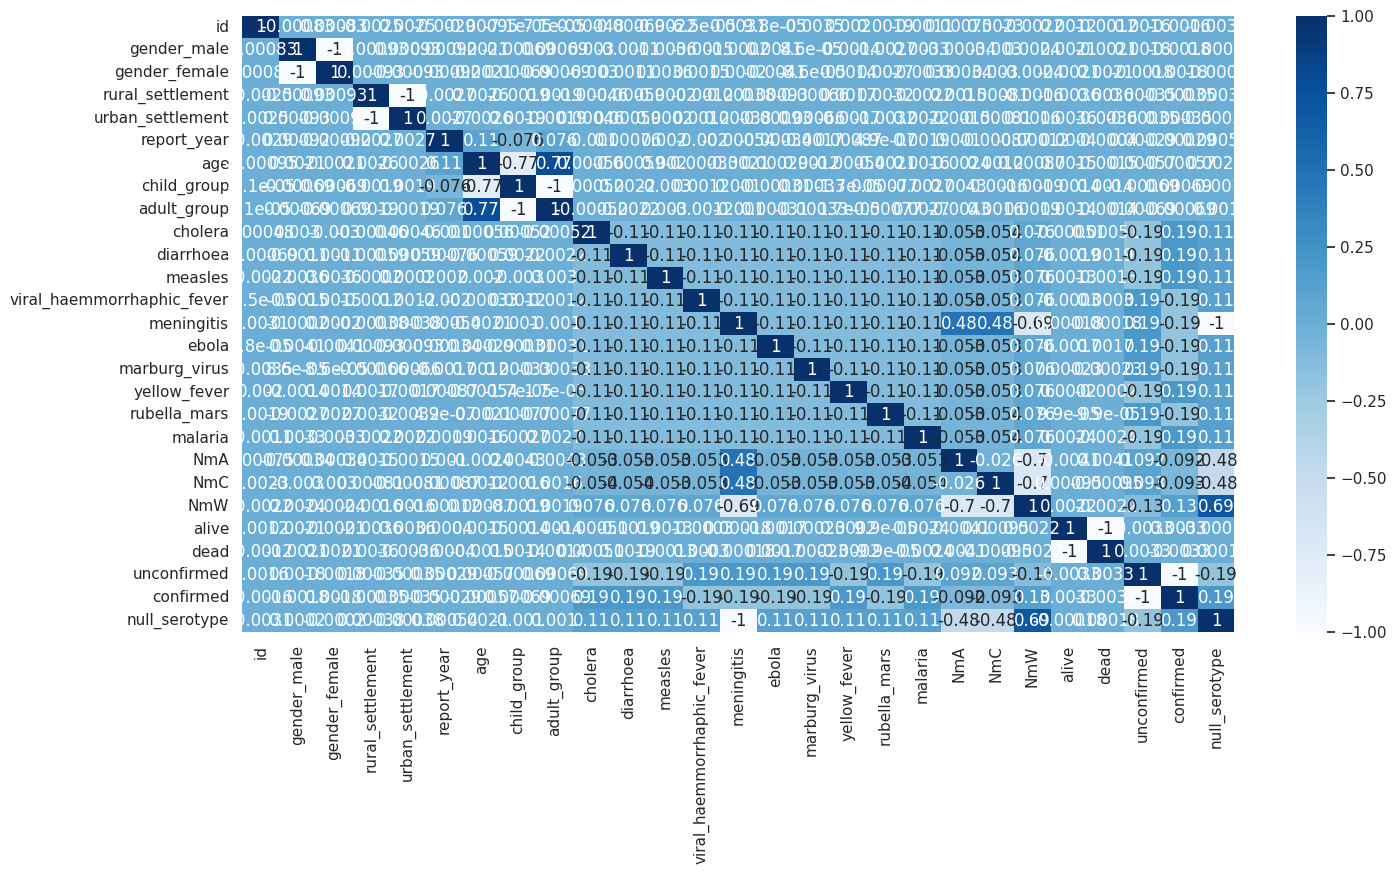

In [ ]:
# Heatmap showing correlation between the attributes.
sns.heatmap(
    pandas_df.corr(), annot=True, cmap="Blues"
)

A heatmap for correlation analysis is a graphical representation of the correlation matrix, which shows the correlation coefficients between variables in a dataset. It is a visual way to display the strength and direction of the linear relationship between pairs of variables.

In this heatmap, each cell's color represents the correlation coefficient between two variables. The color gradient typically ranges from cool colors (such as blue) indicating a high negative correlation, through white representing no correlation, to warm colors (such as red) indicating a high positive correlation.

Here we use Blues and as the color gets darker it means its strongly correlated.
The above heat map shows that:
Age and Child Group is highly correlated

NmW and Meningitis is highly correlated

# Q-Q PLOTS

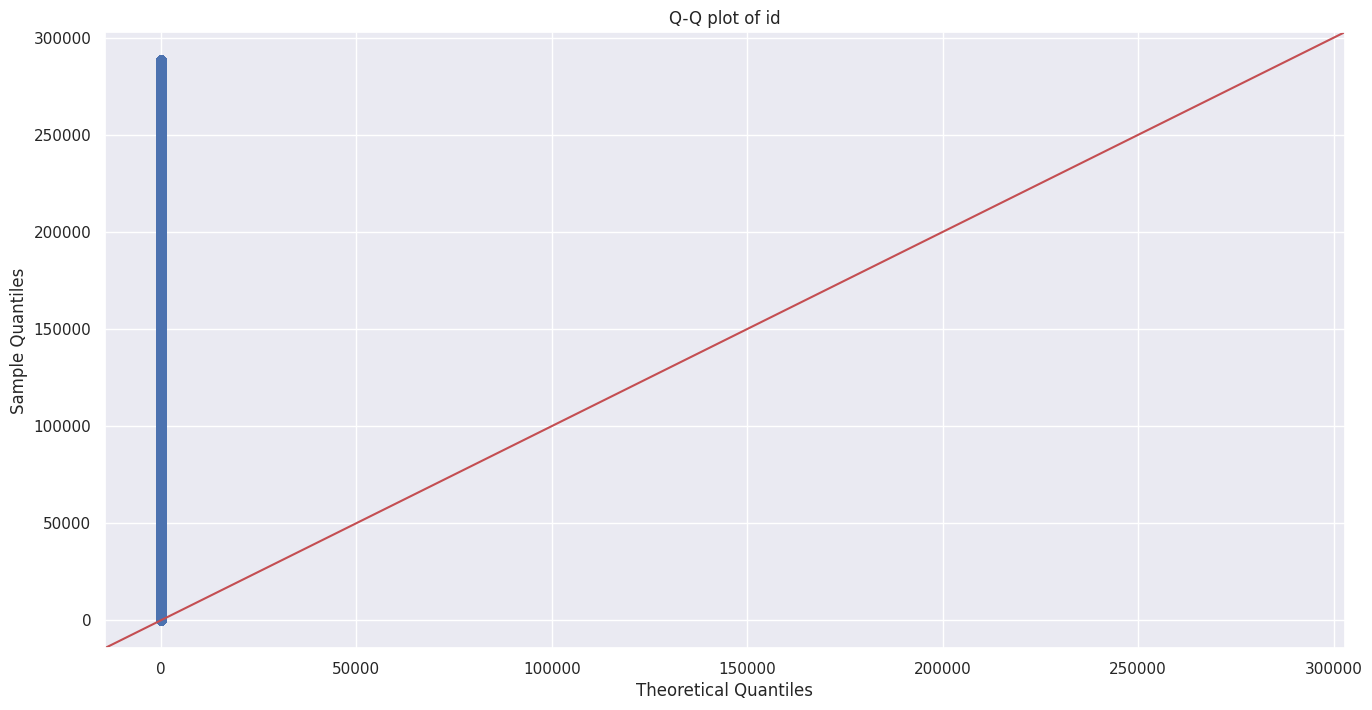

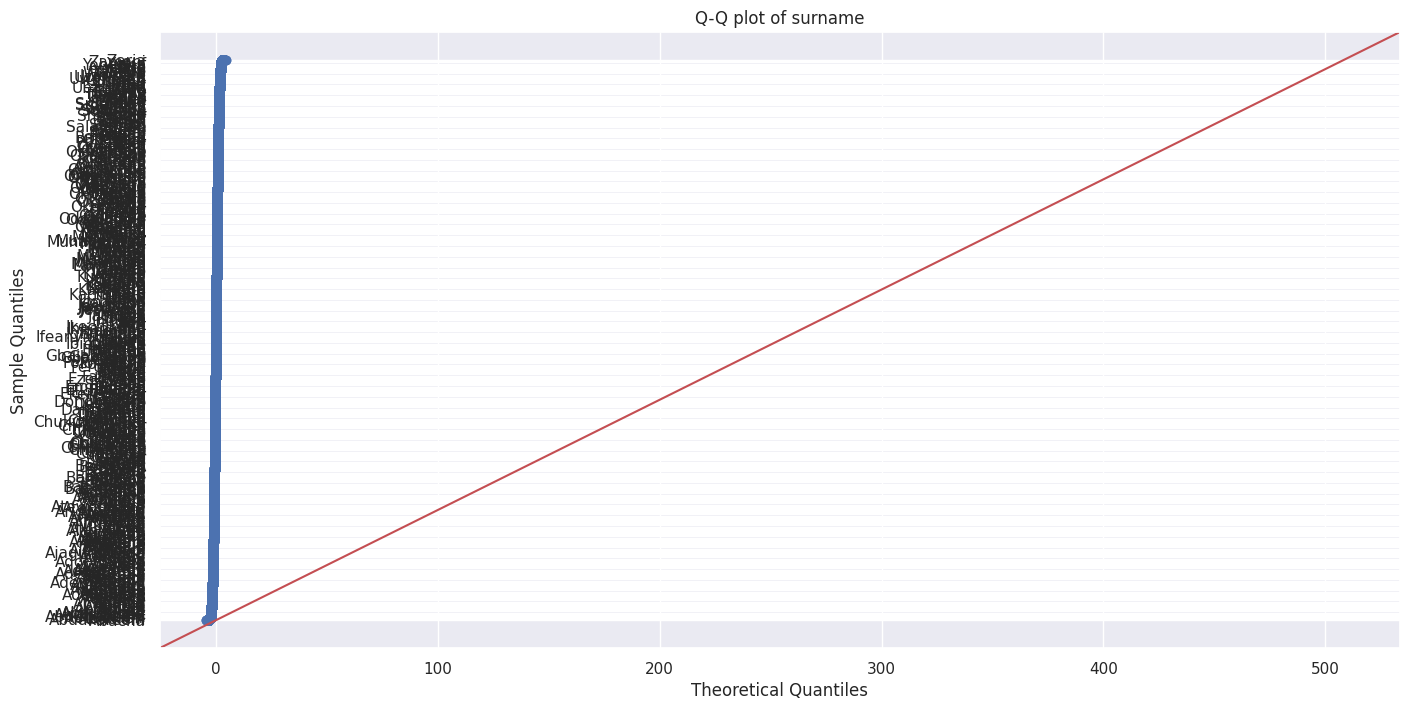

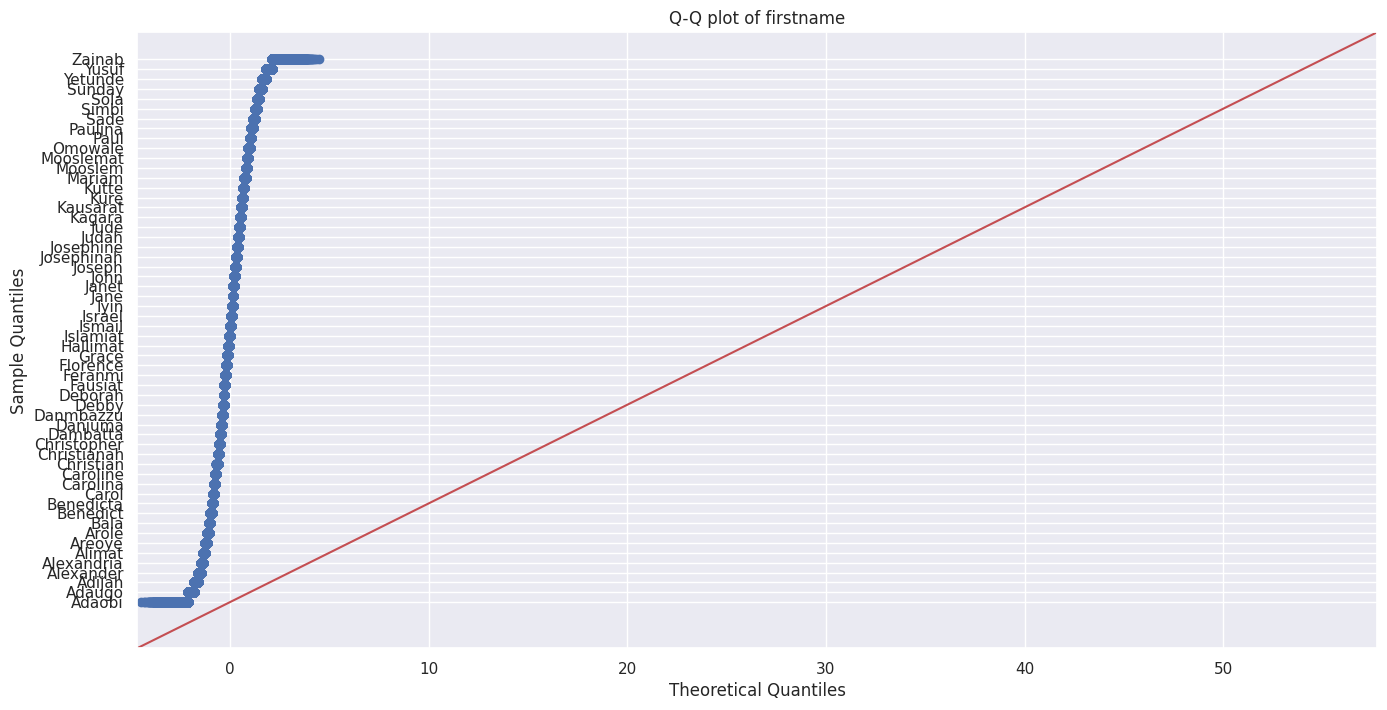

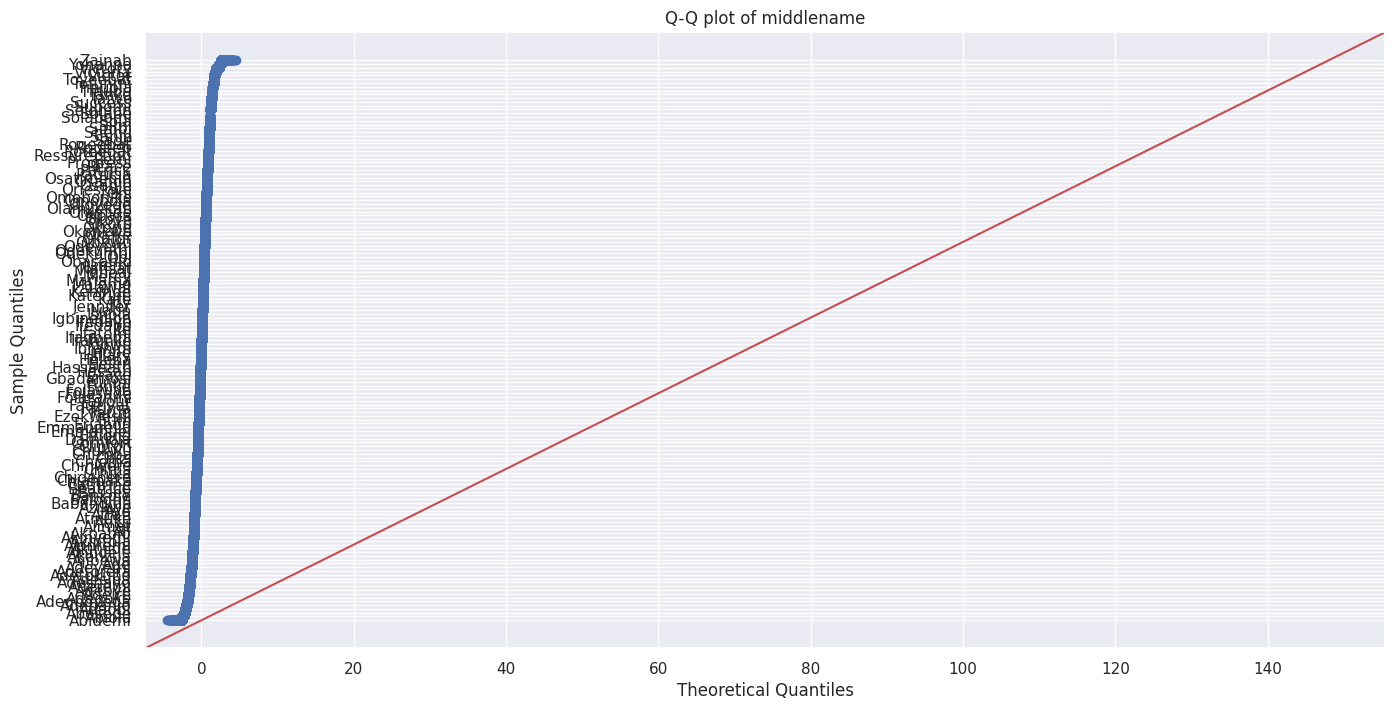

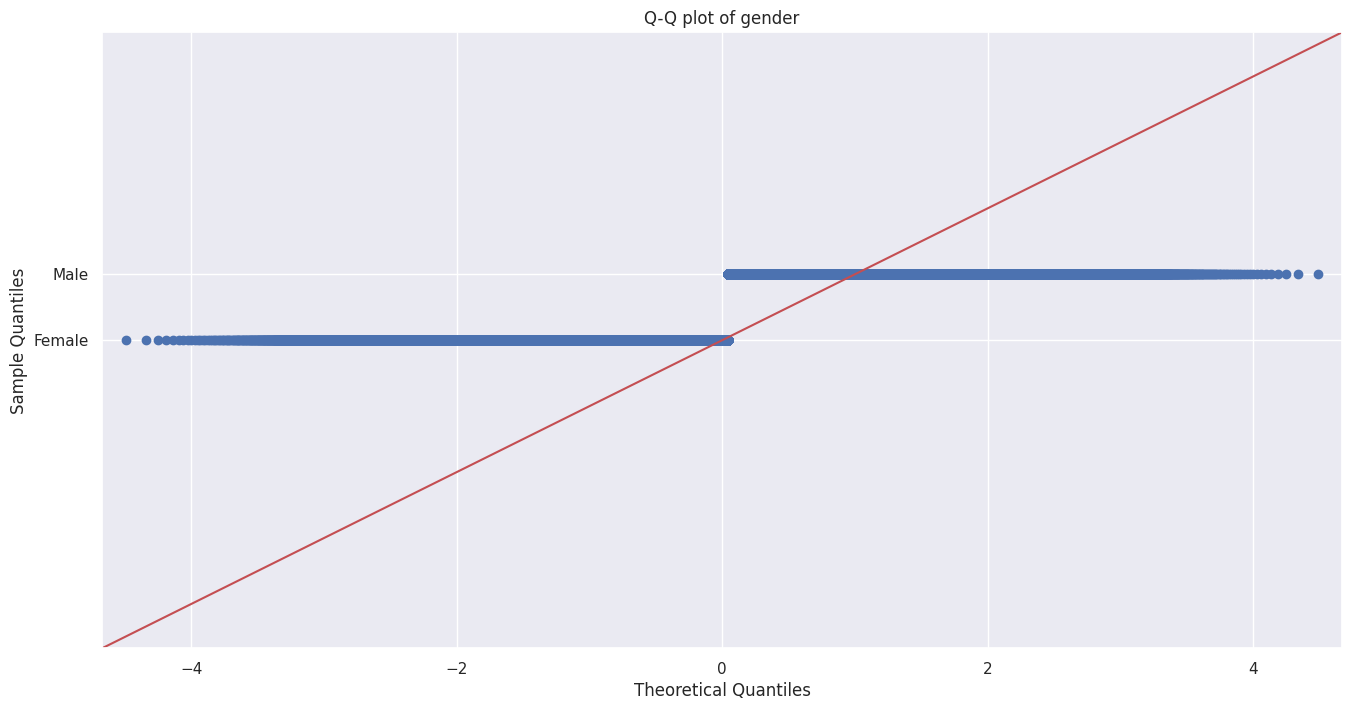

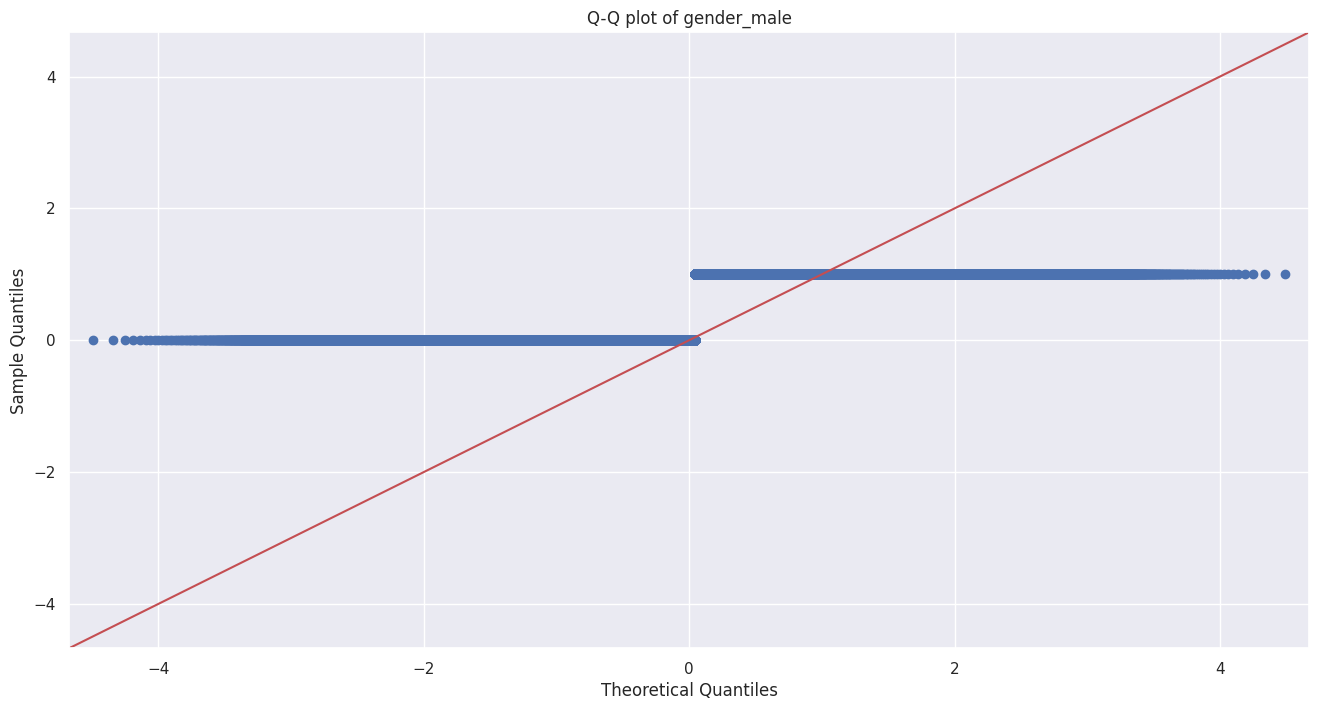

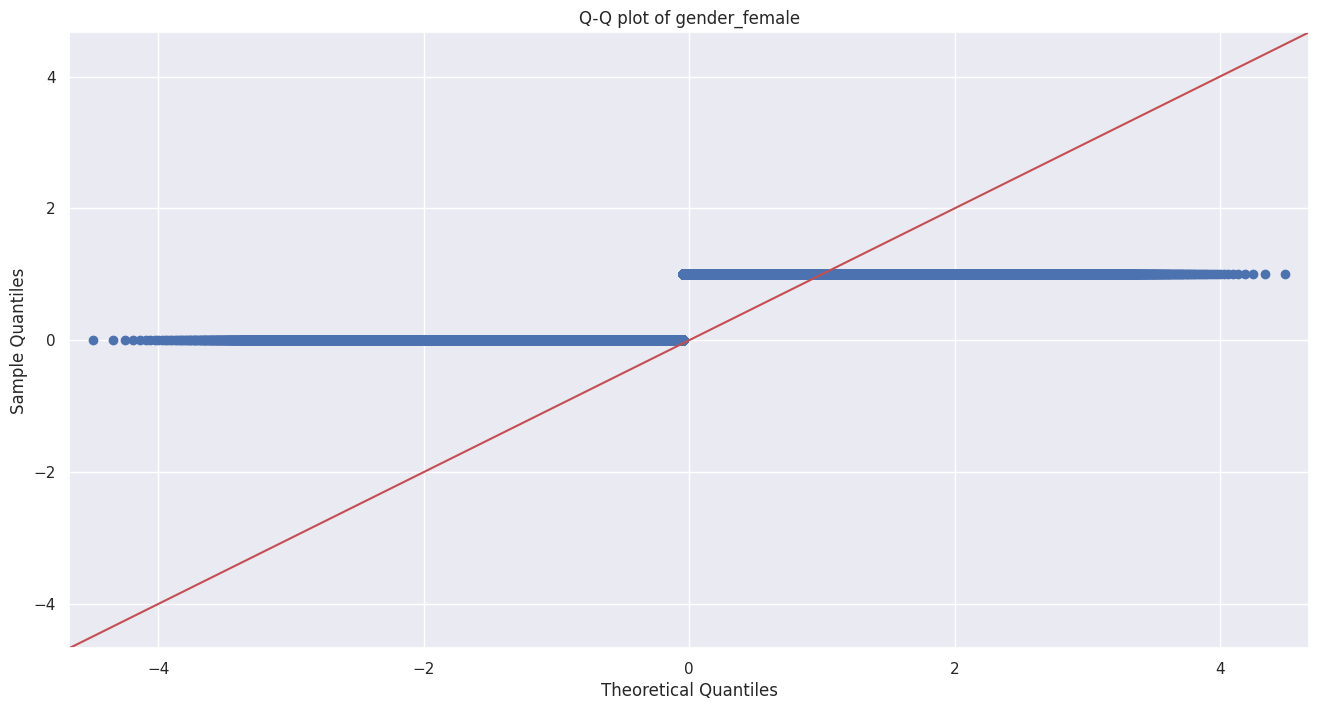

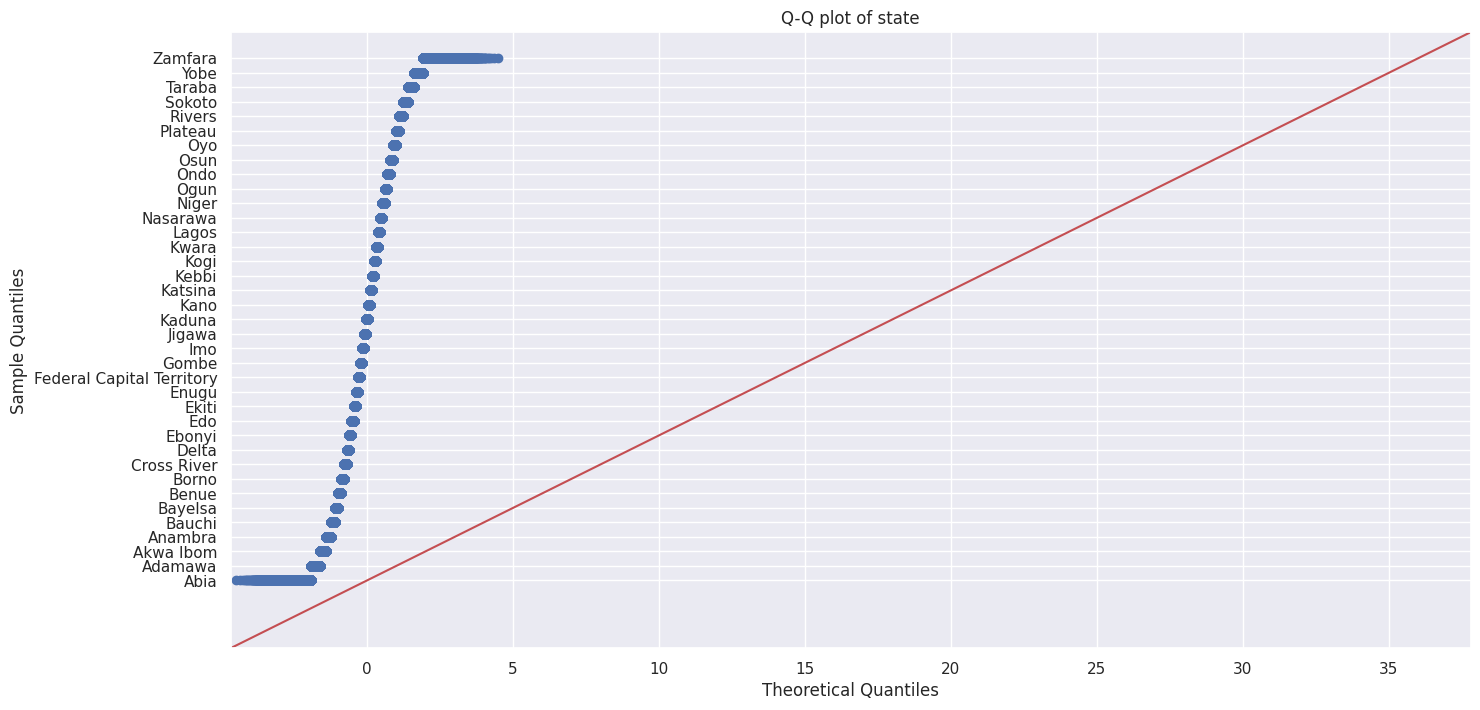

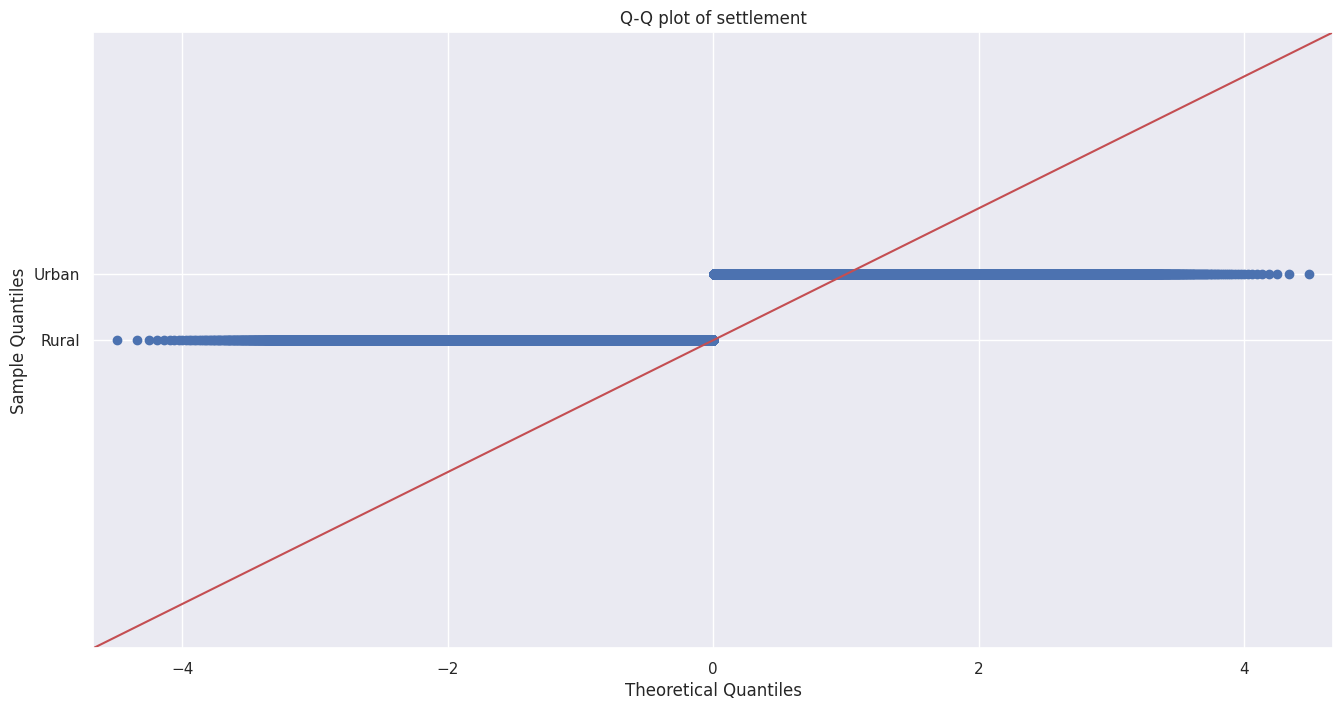

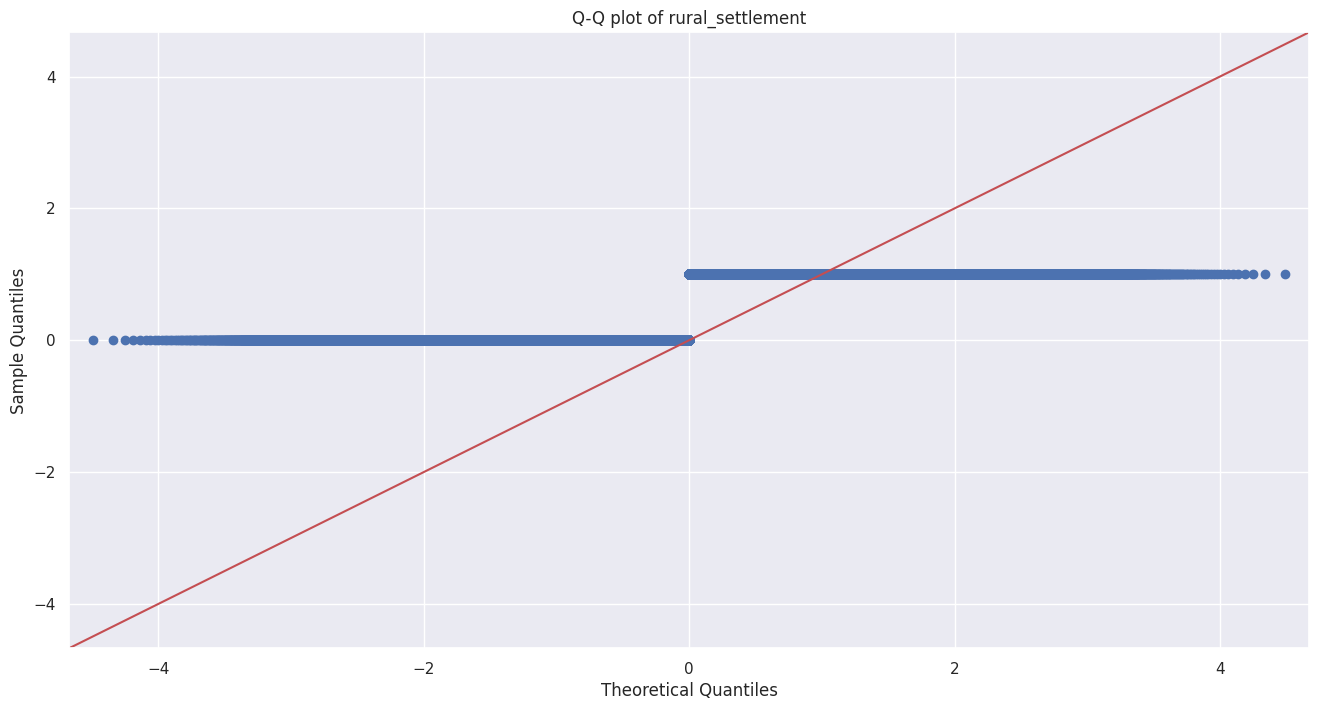

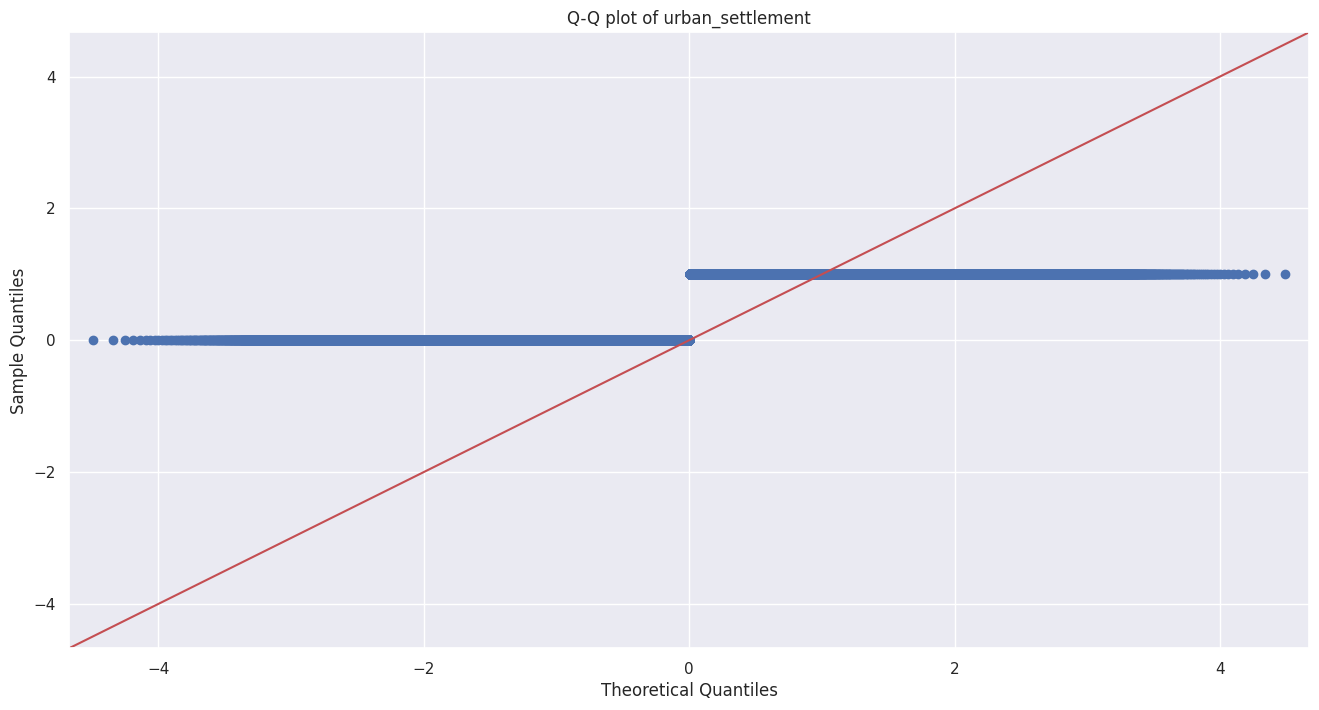

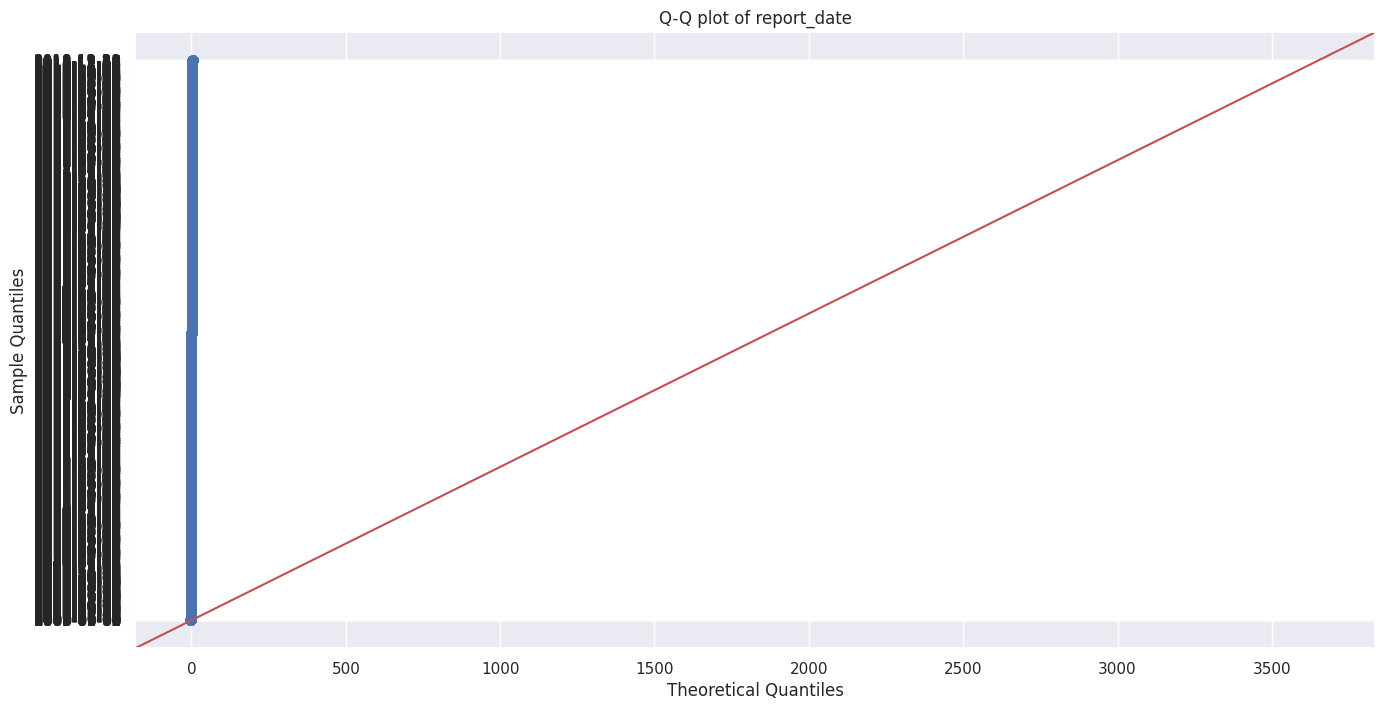

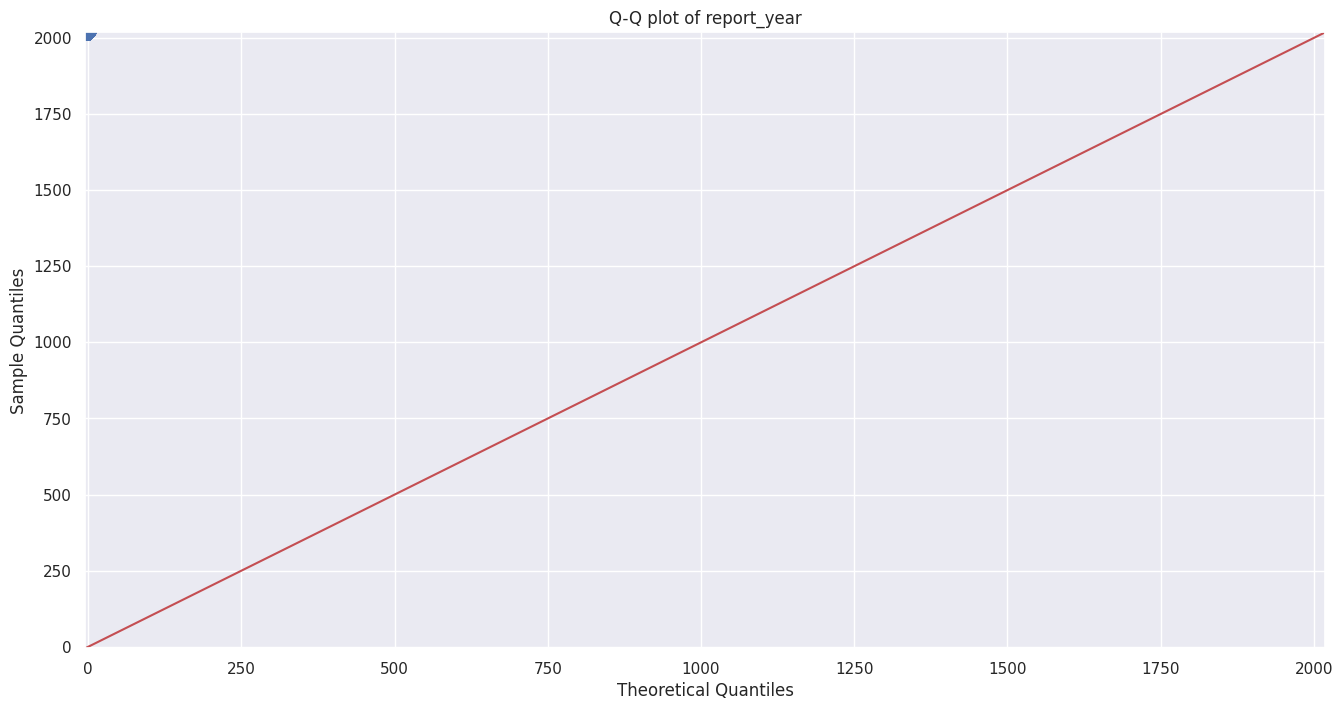

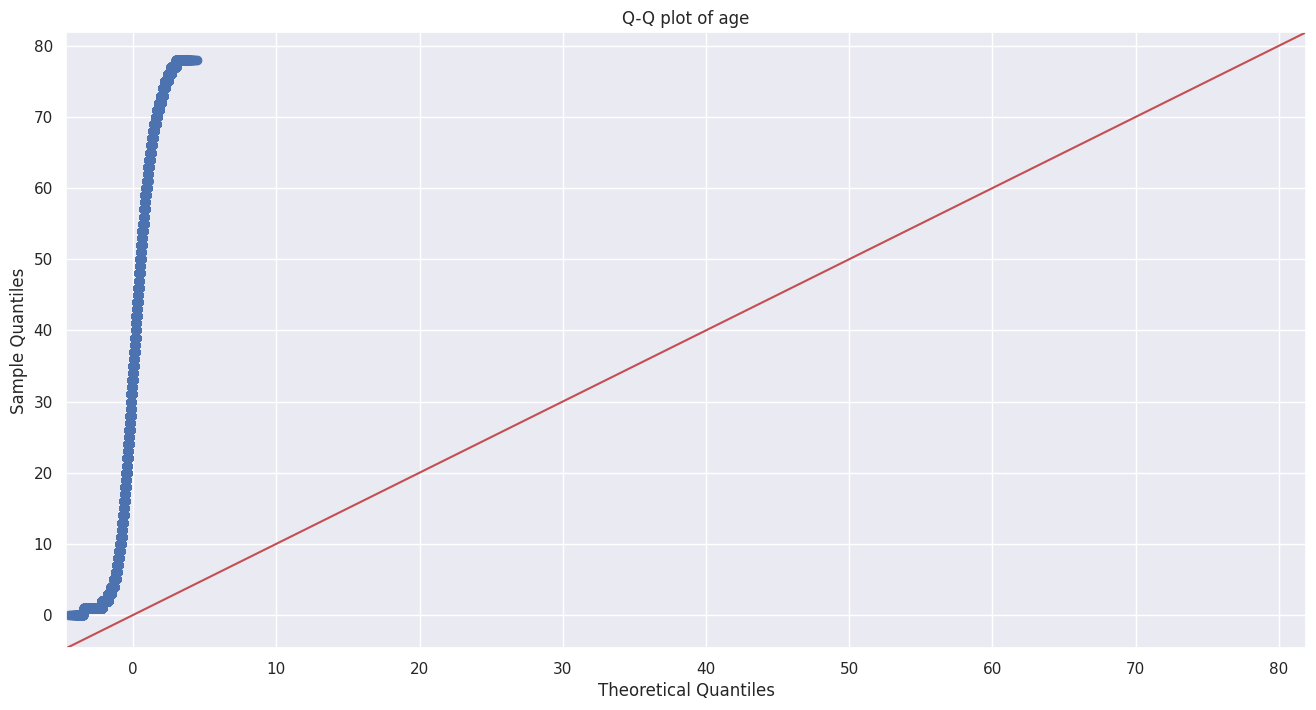

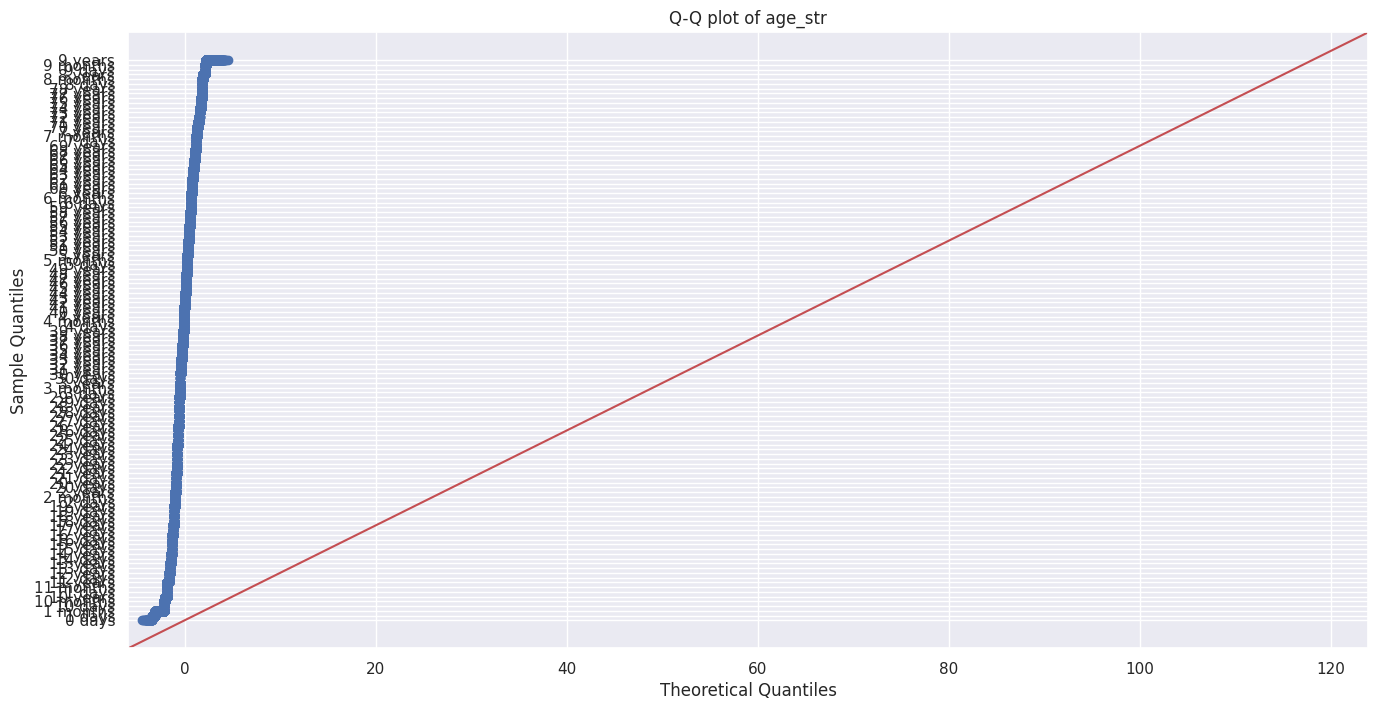

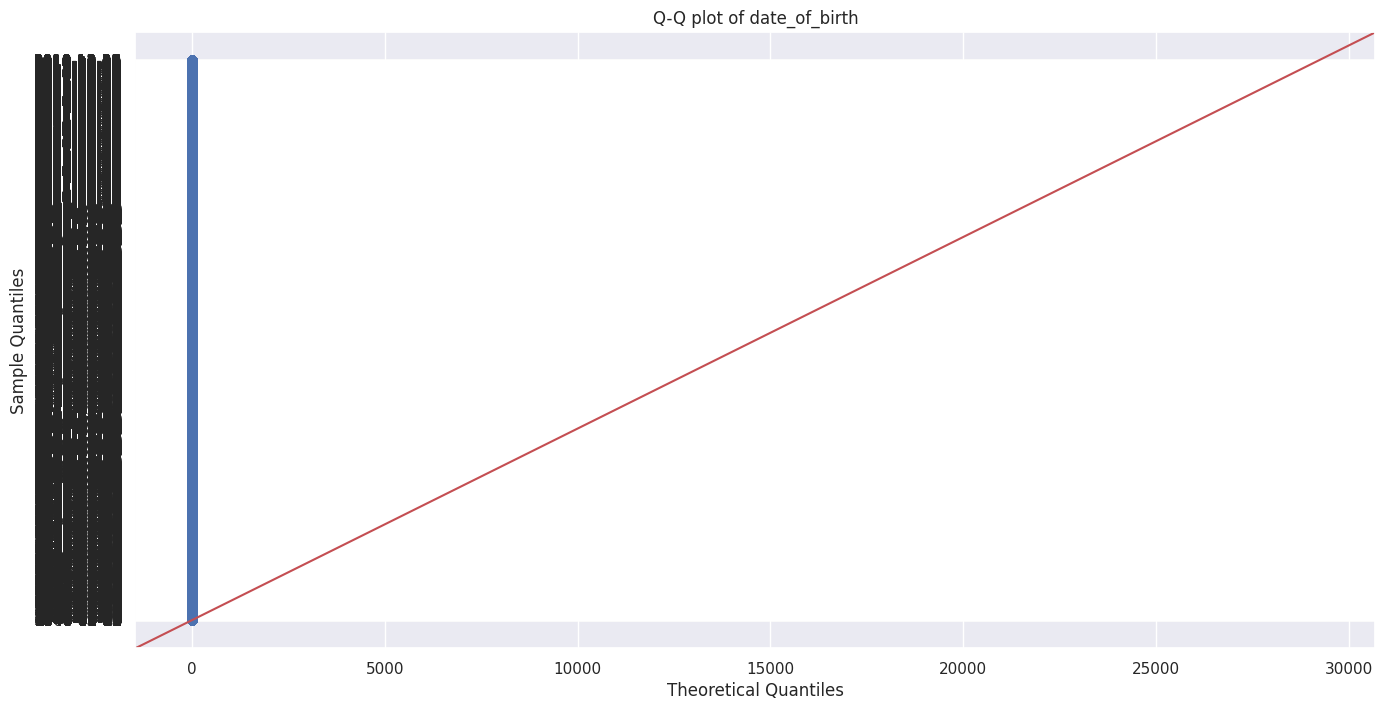

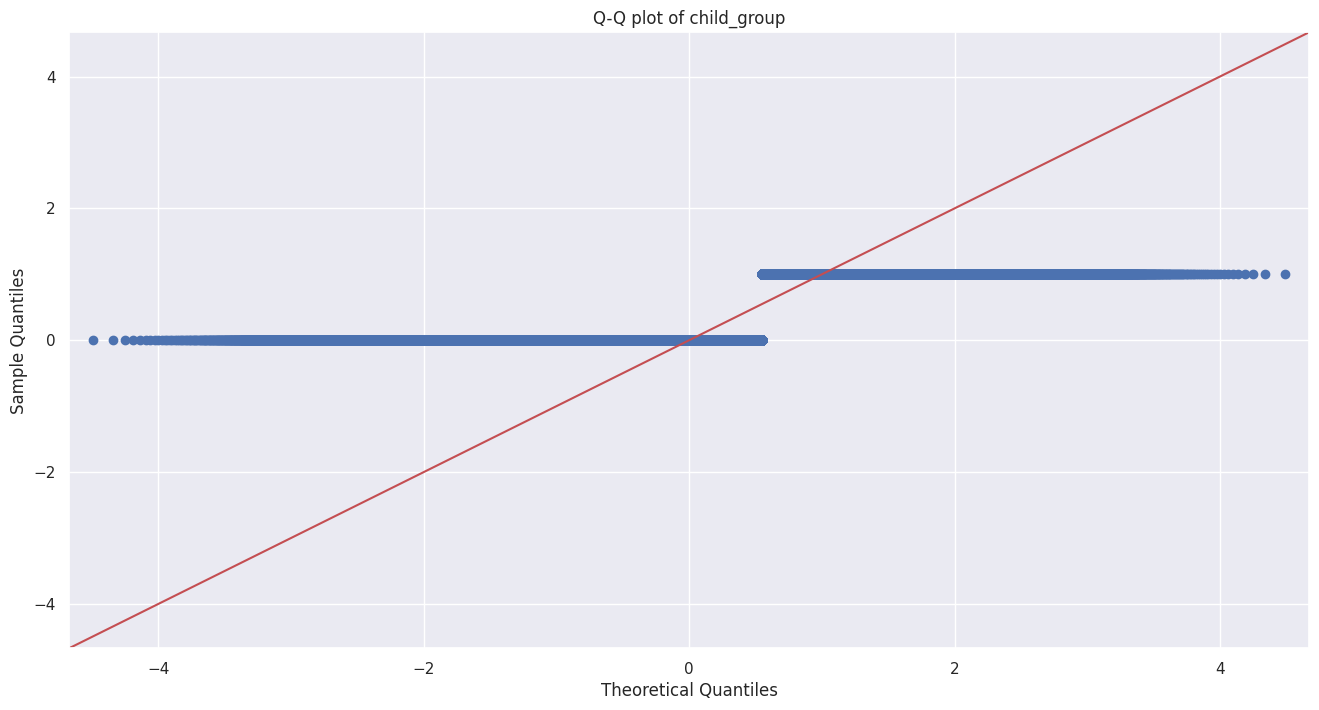

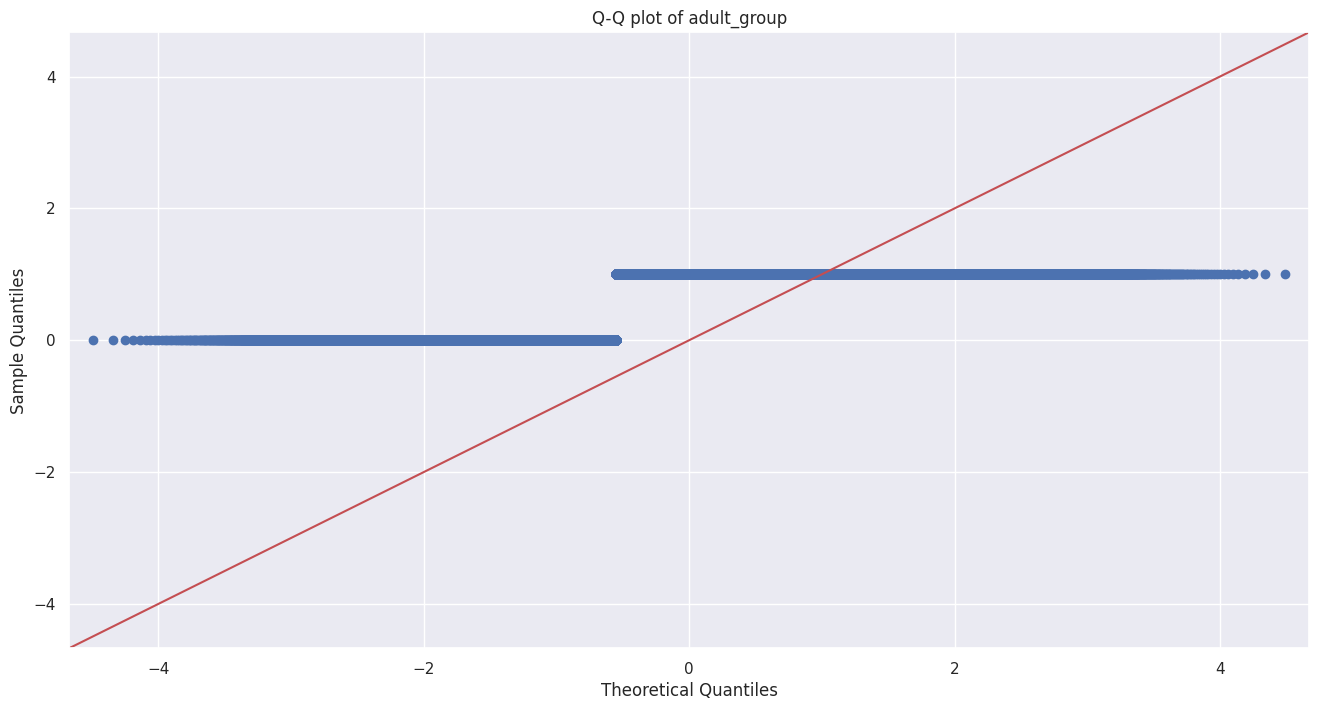

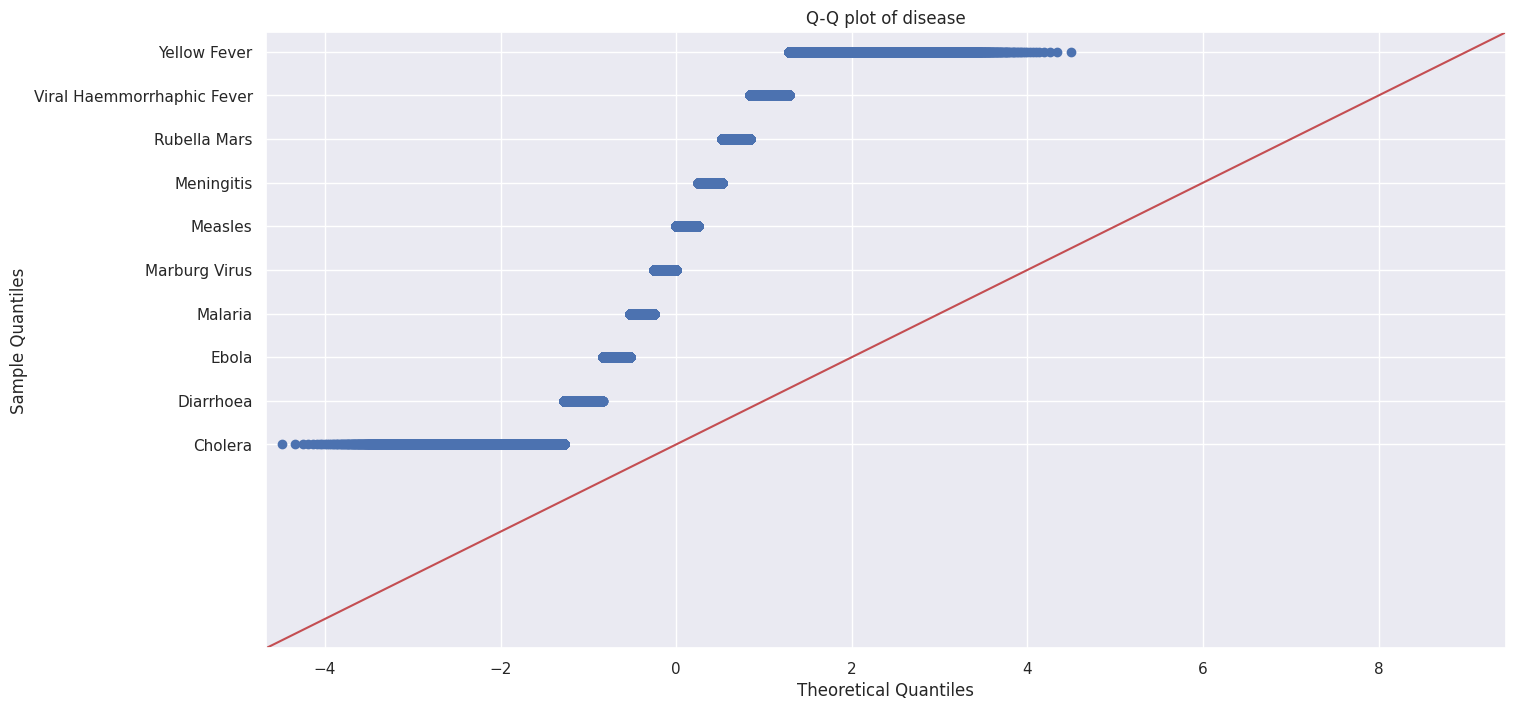

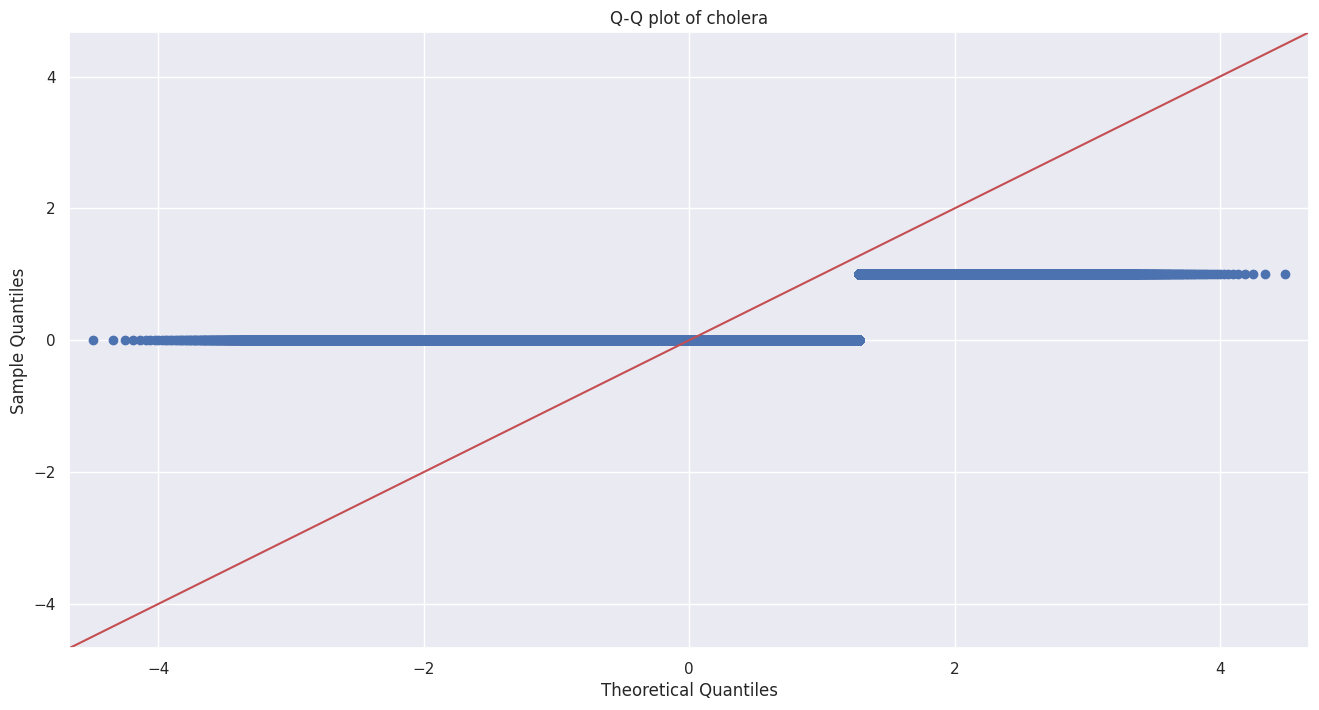

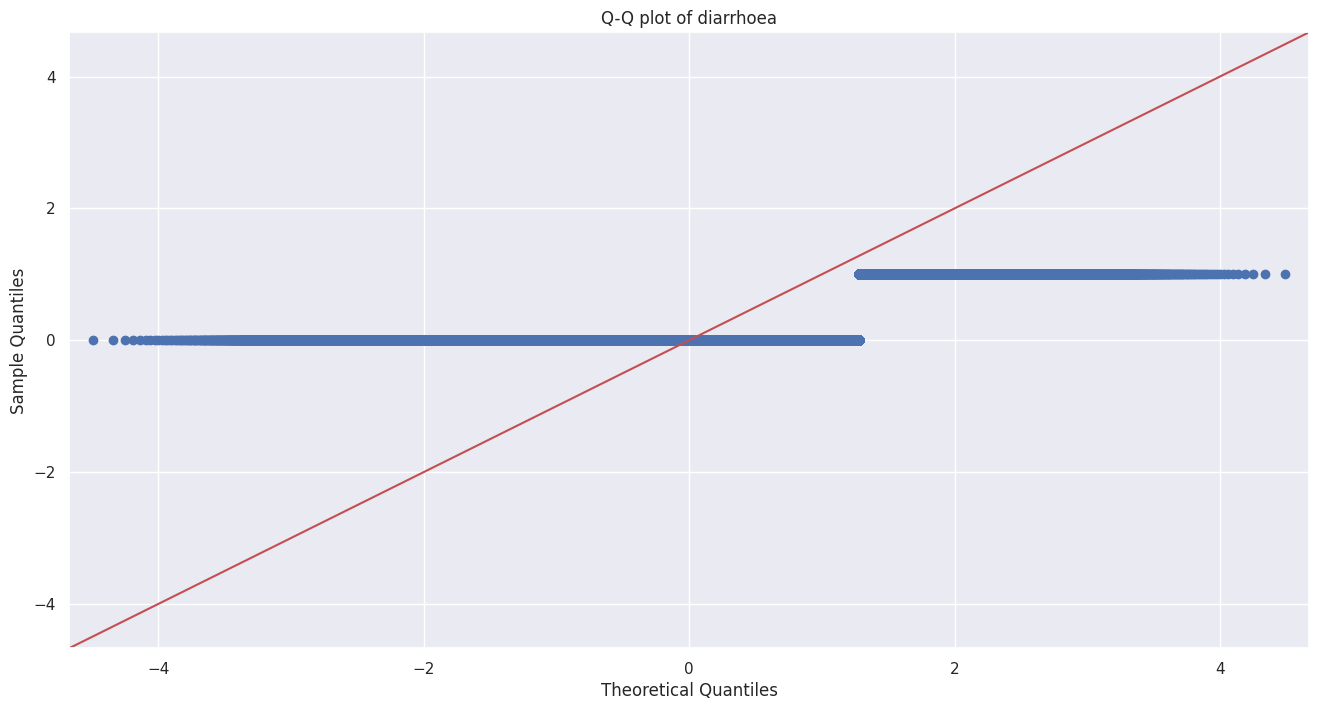

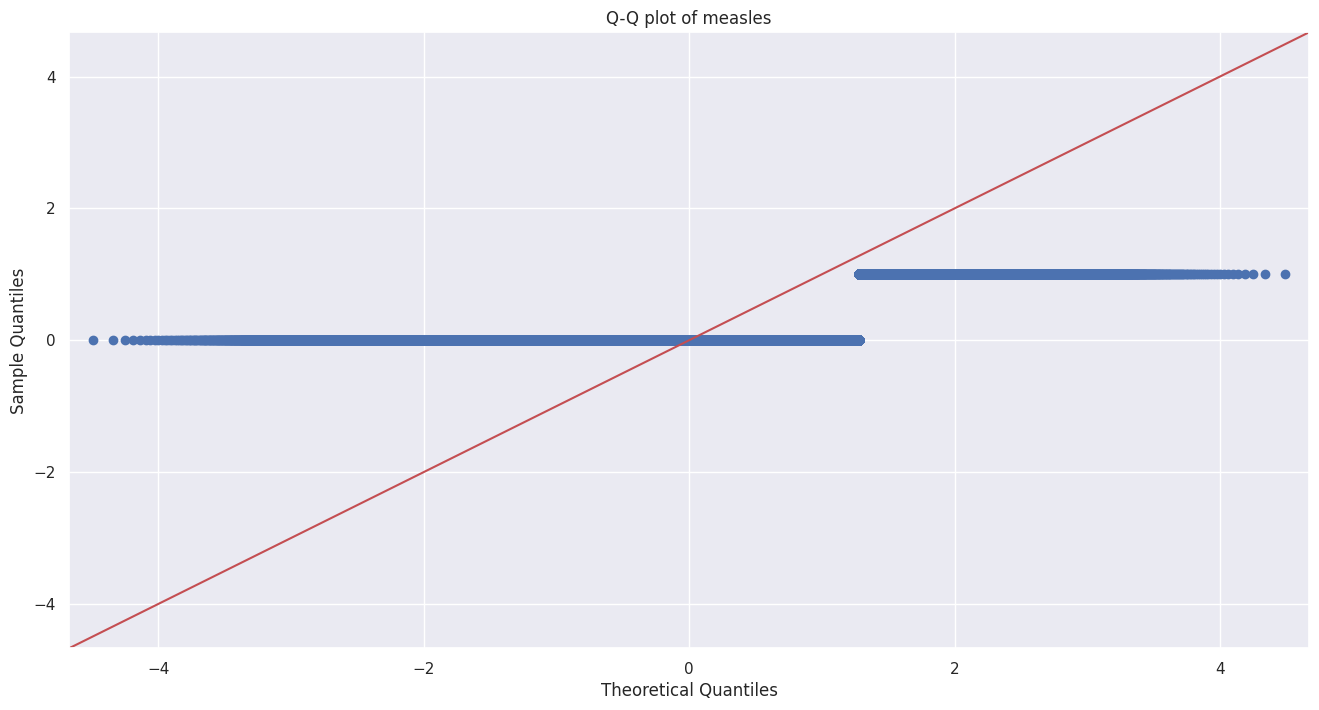

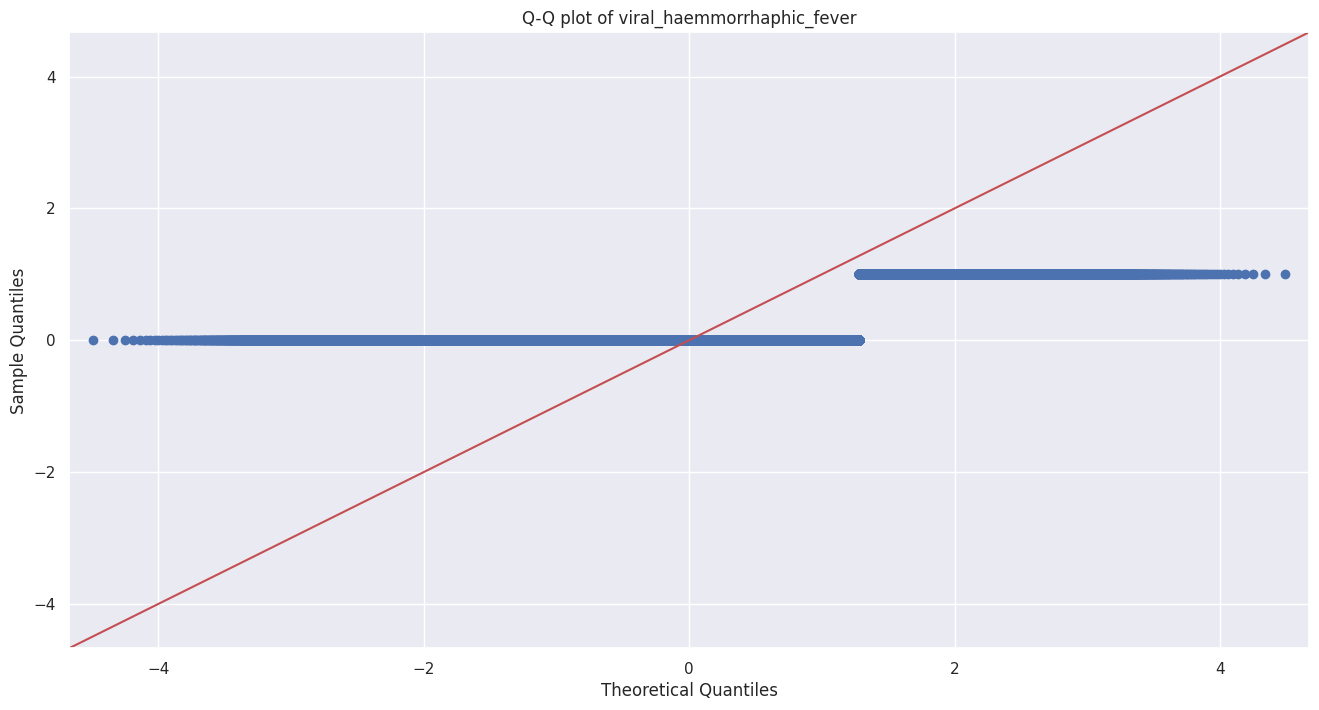

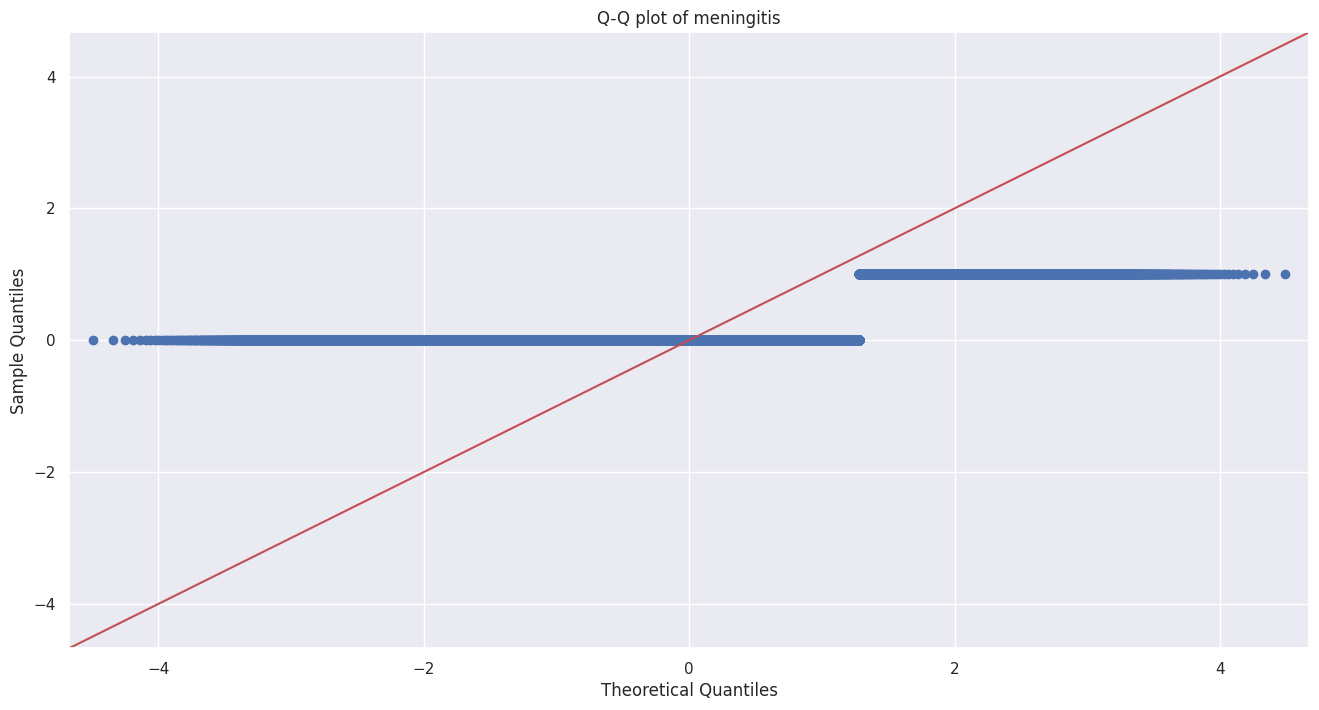

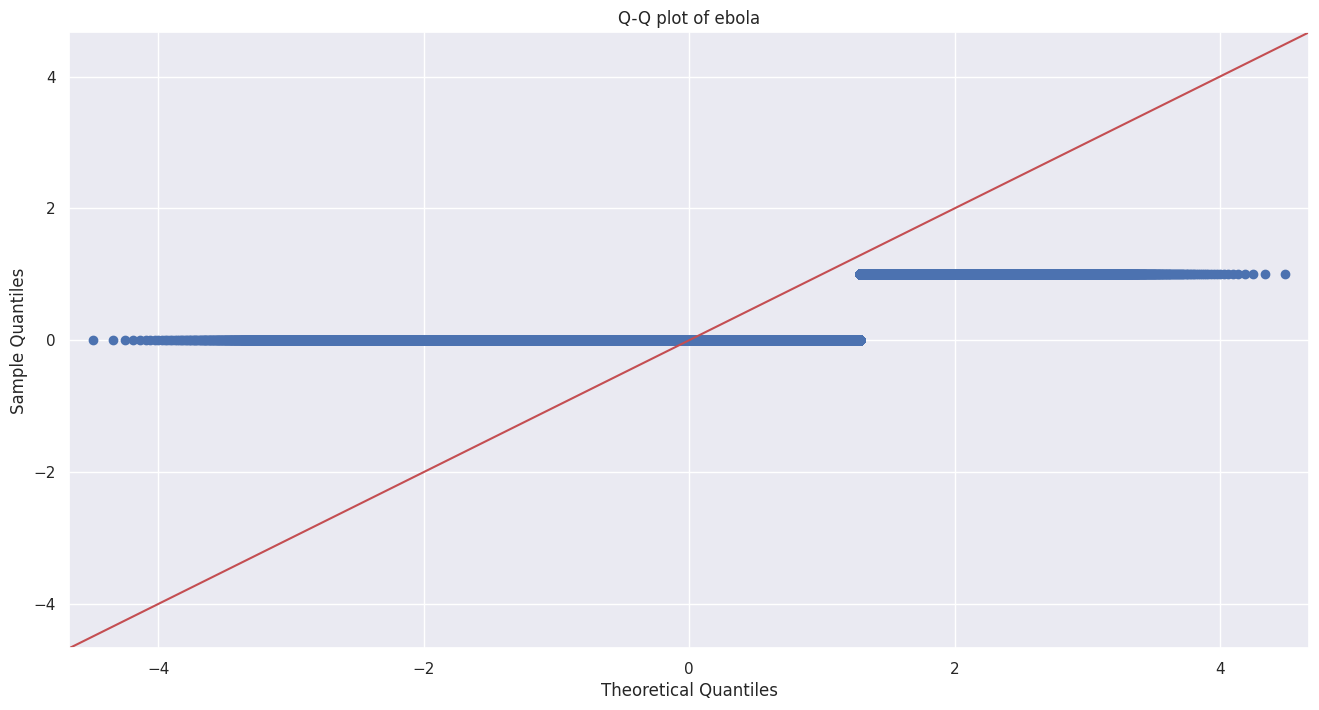

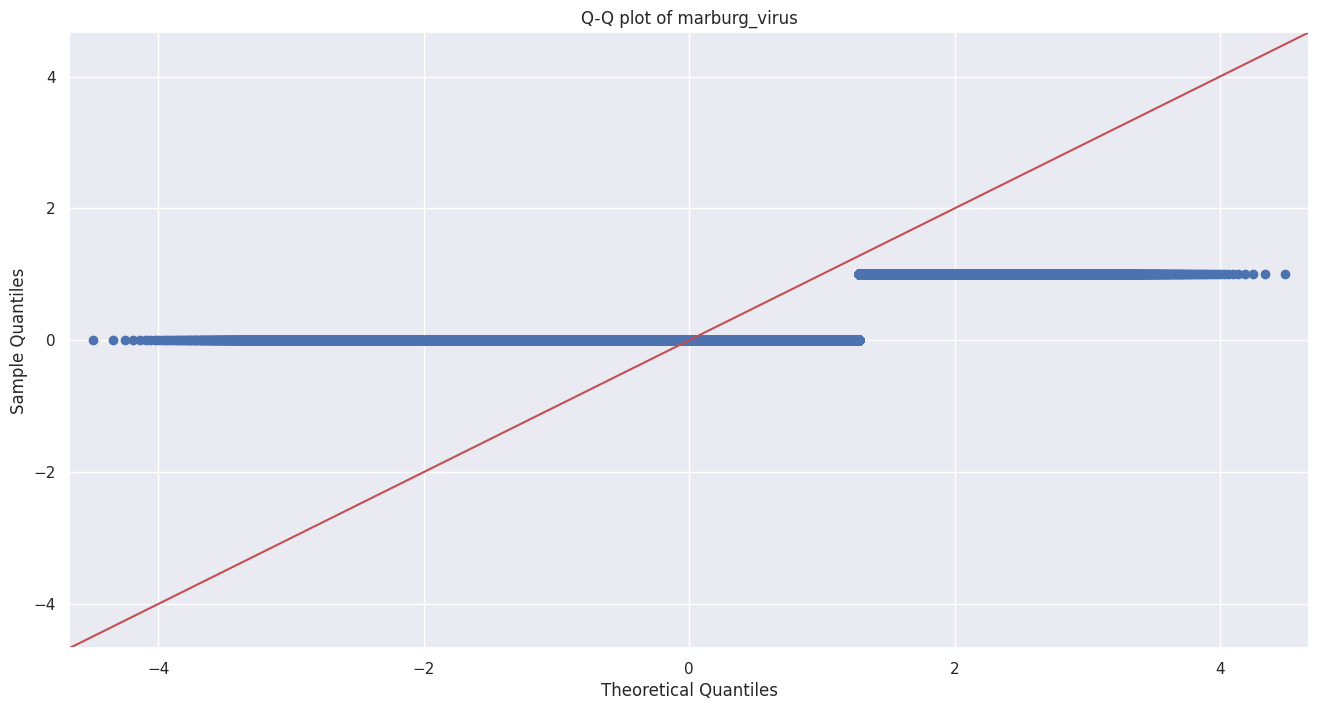

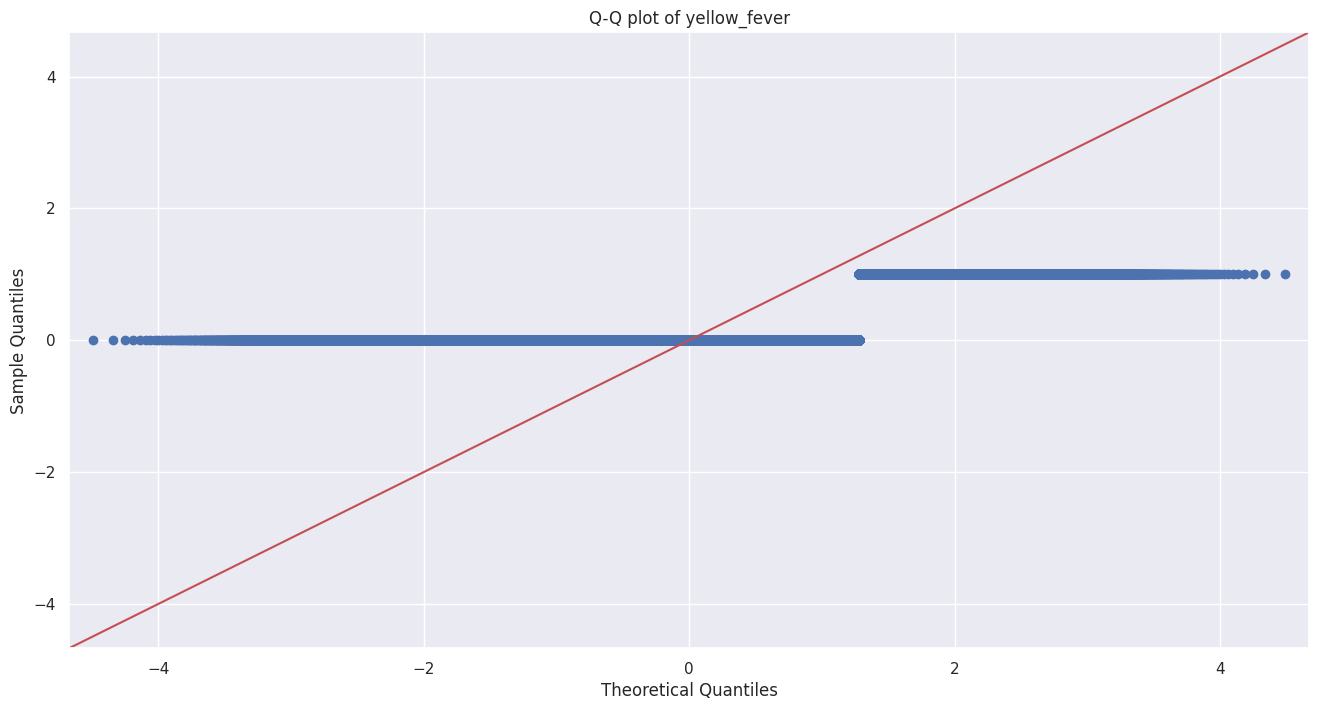

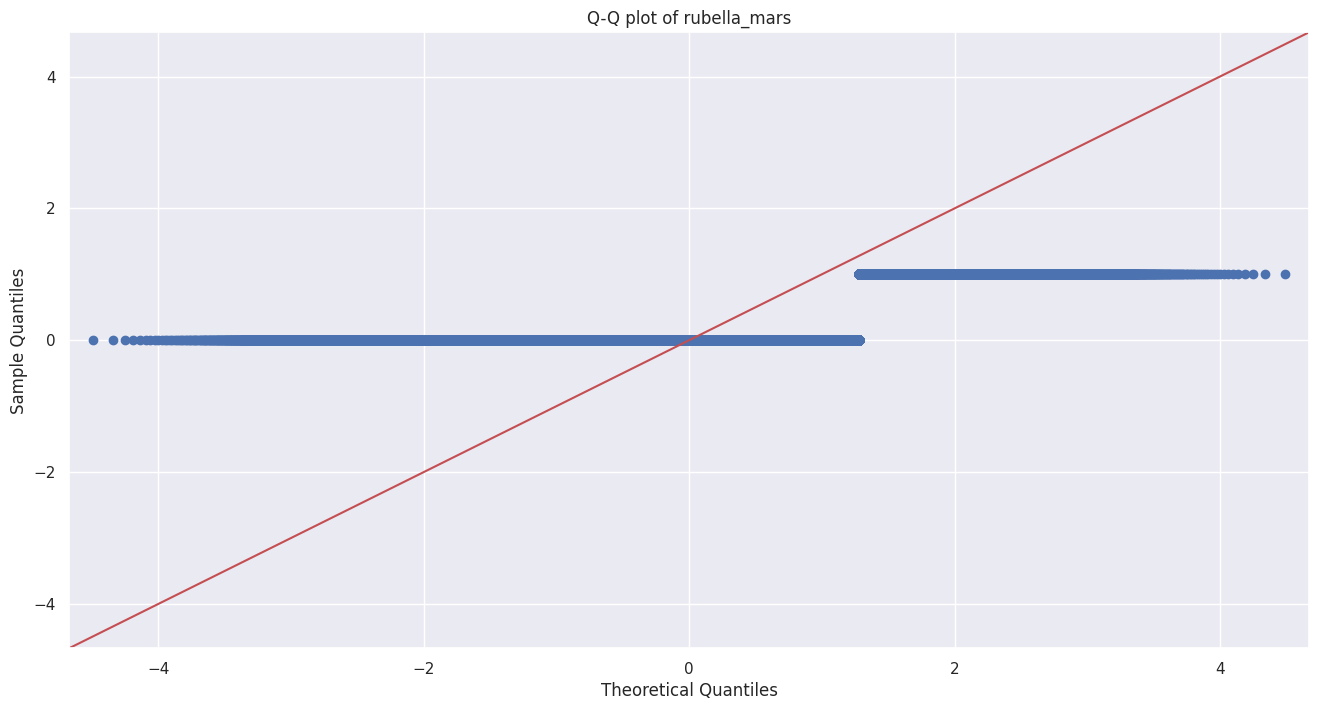

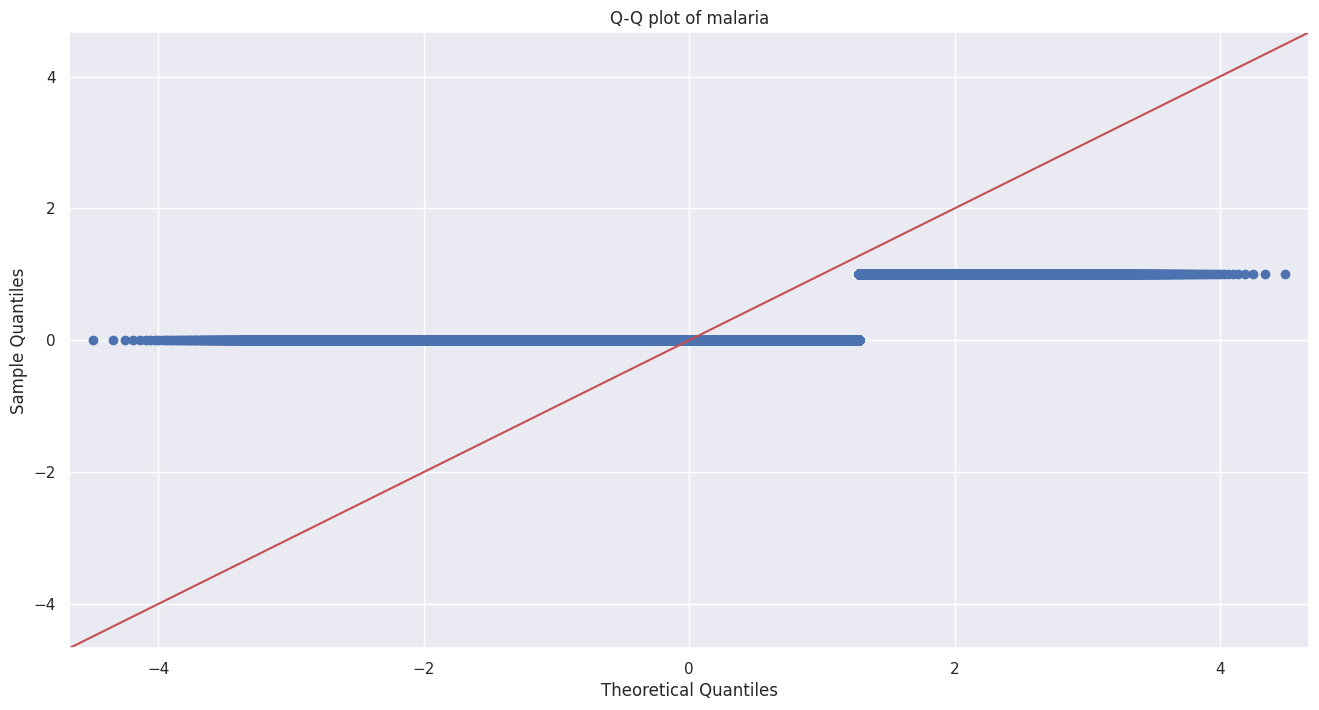

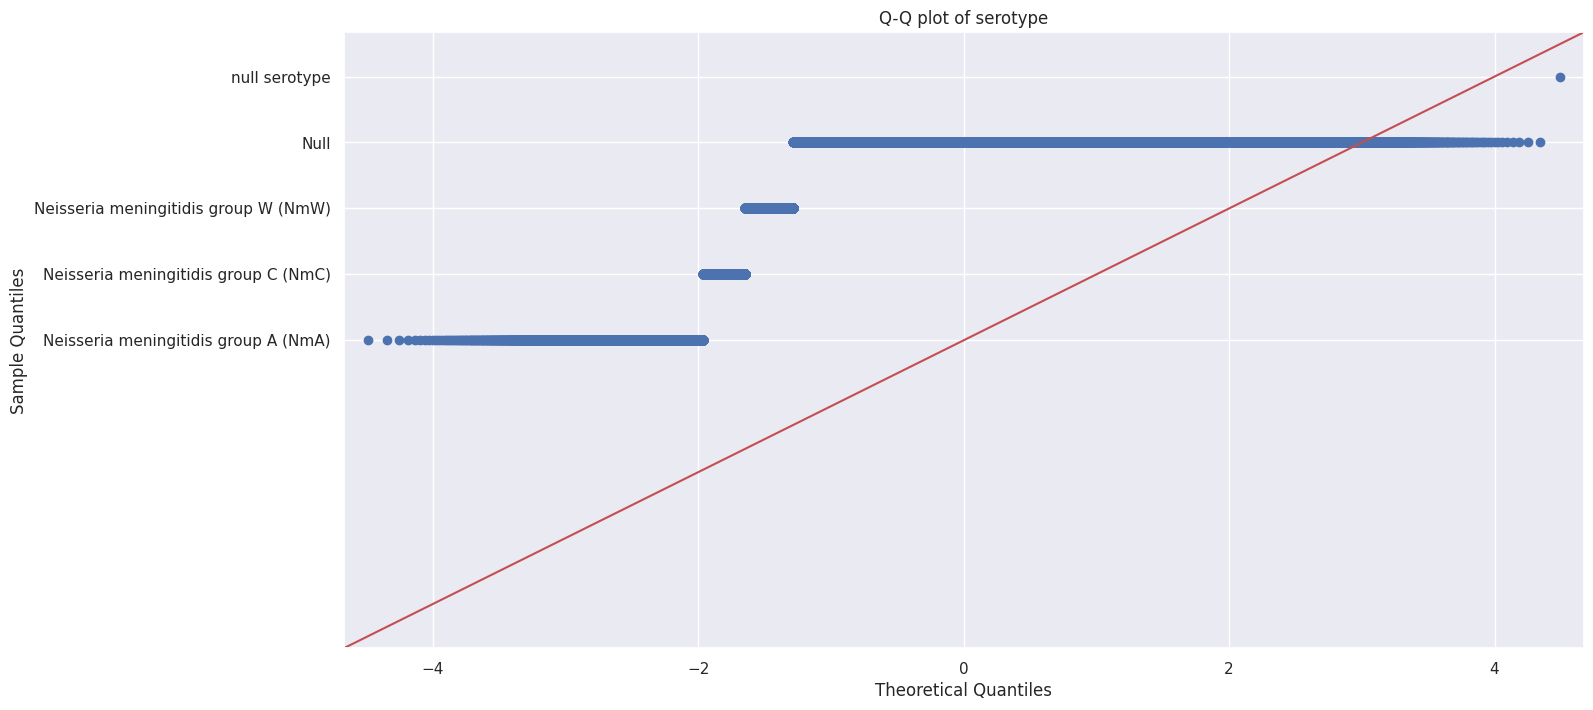

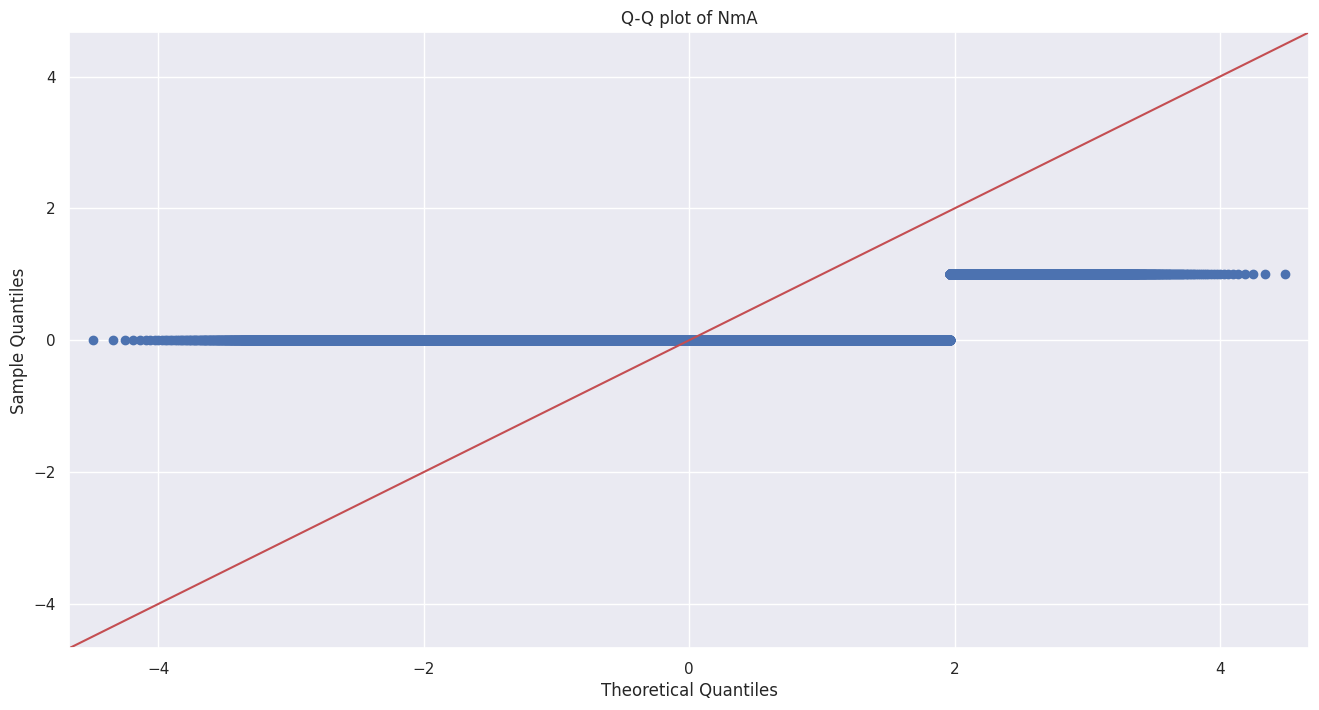

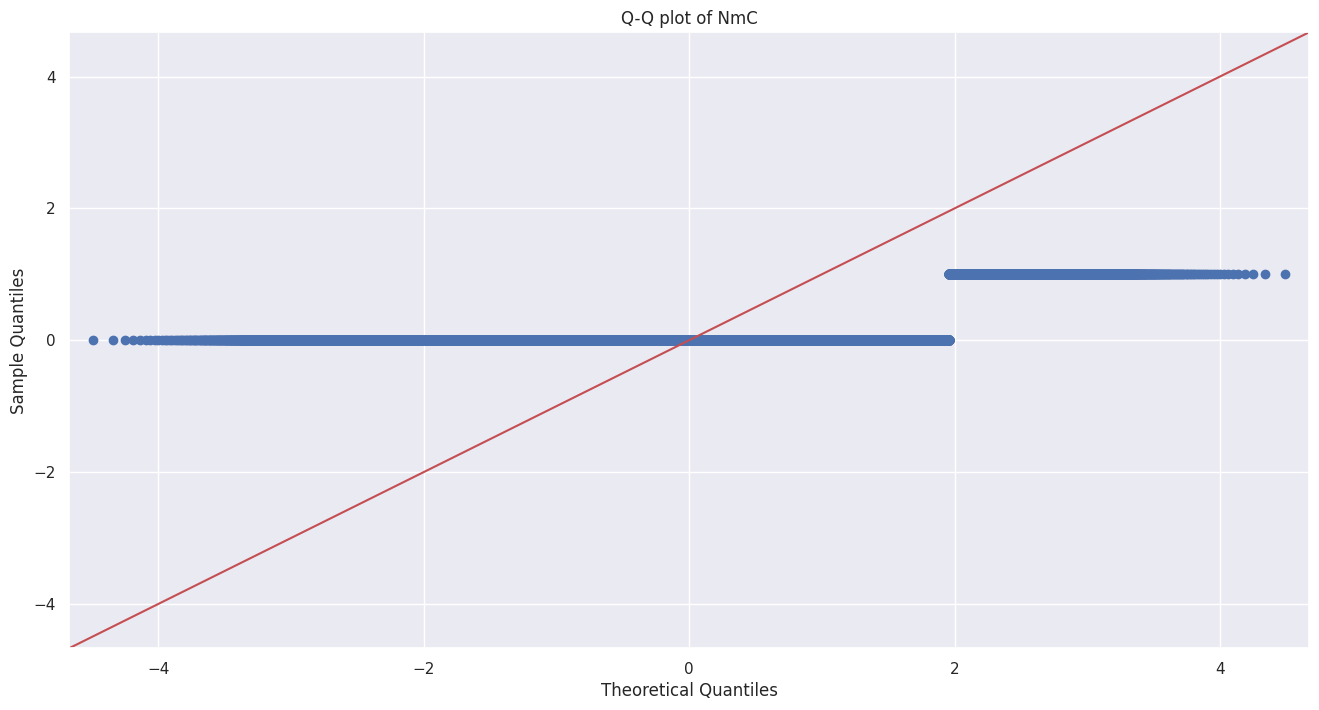

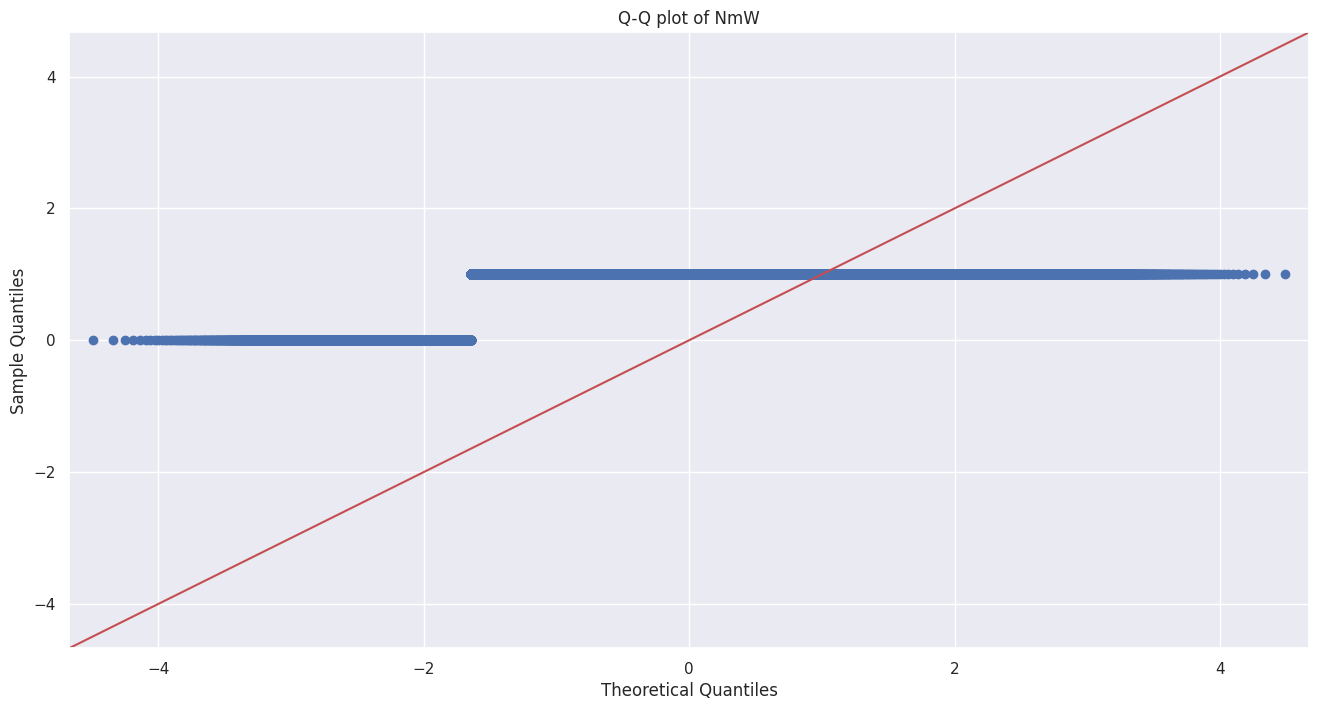

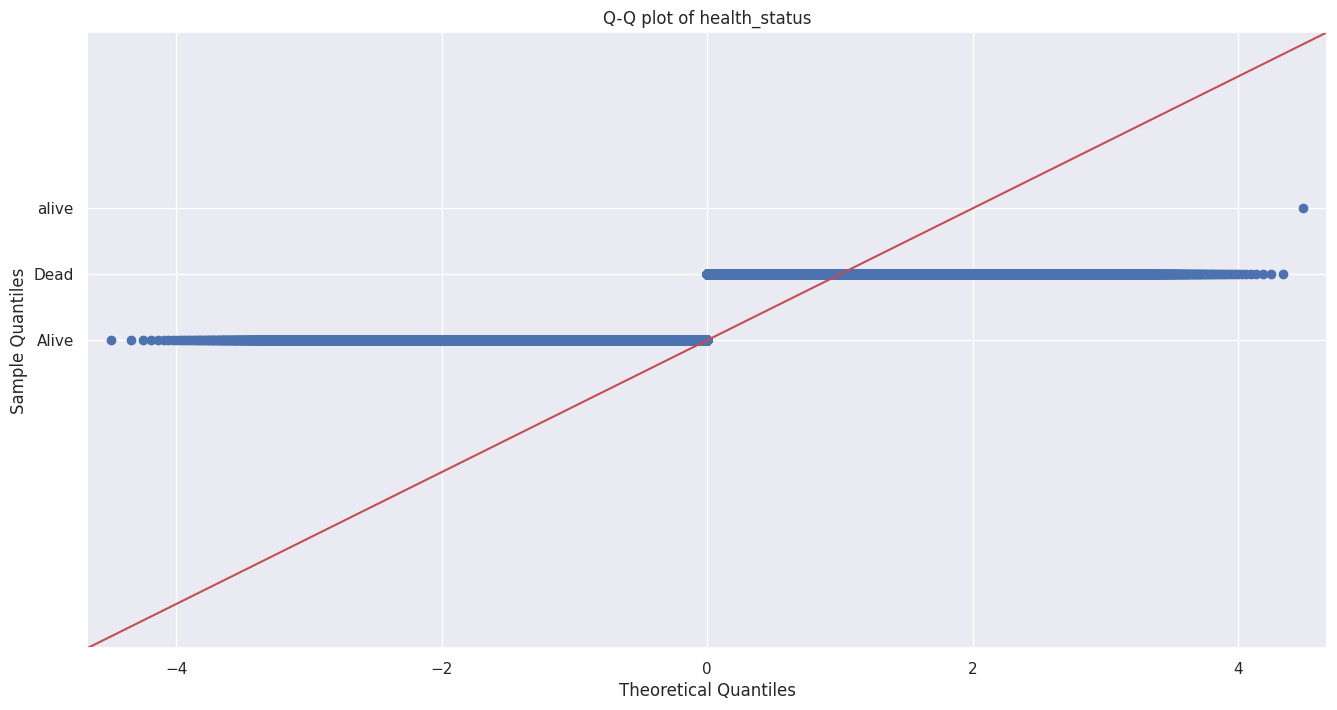

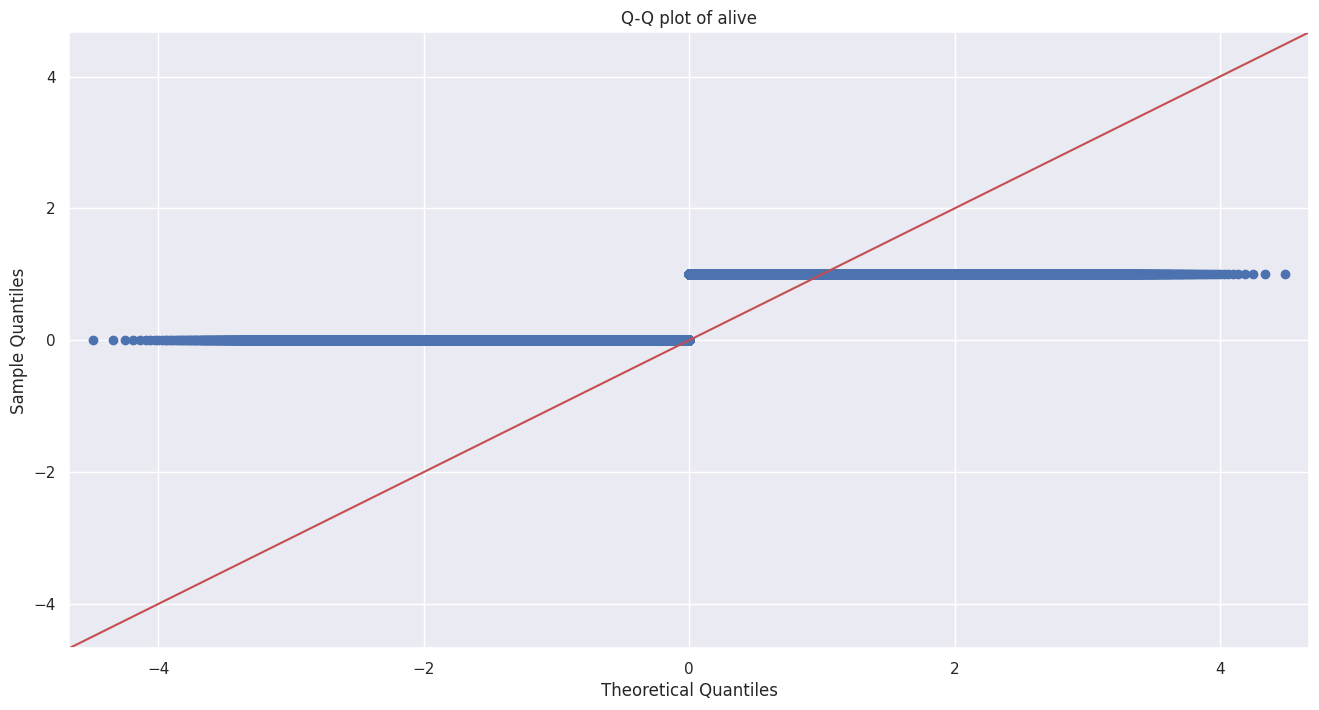

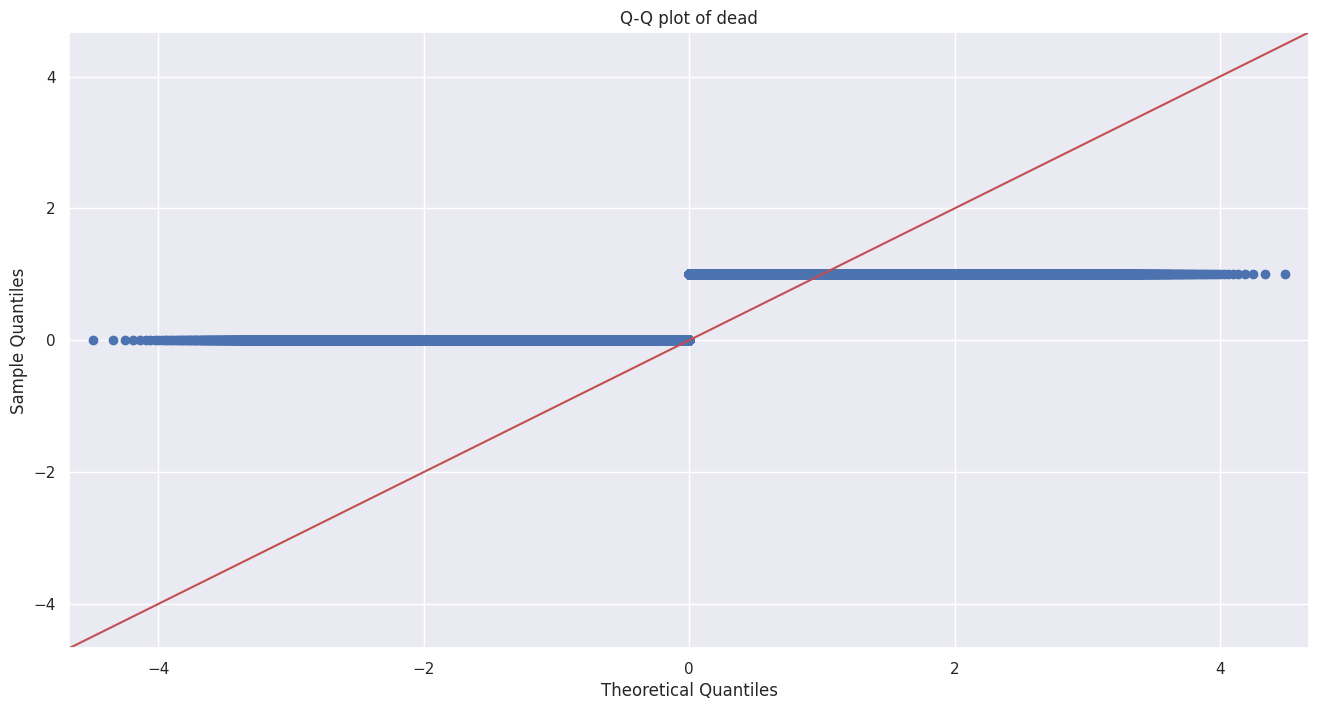

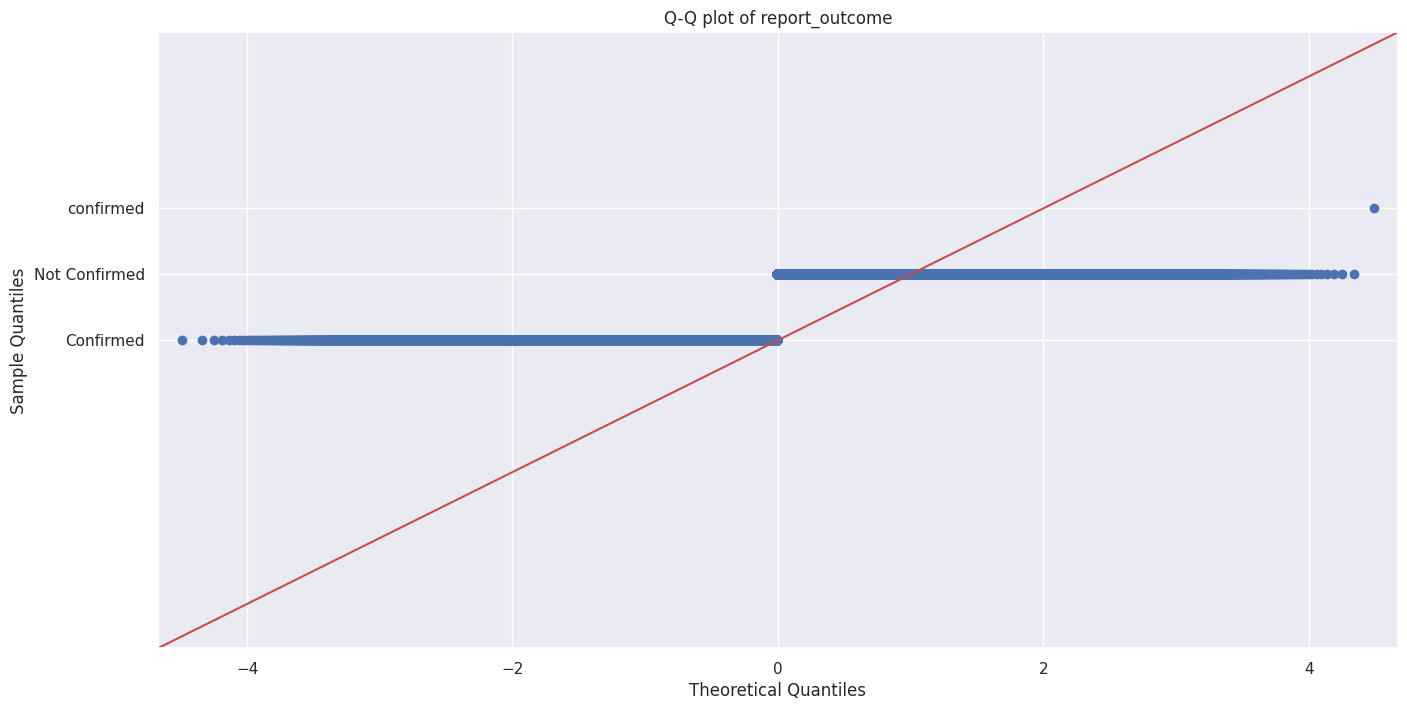

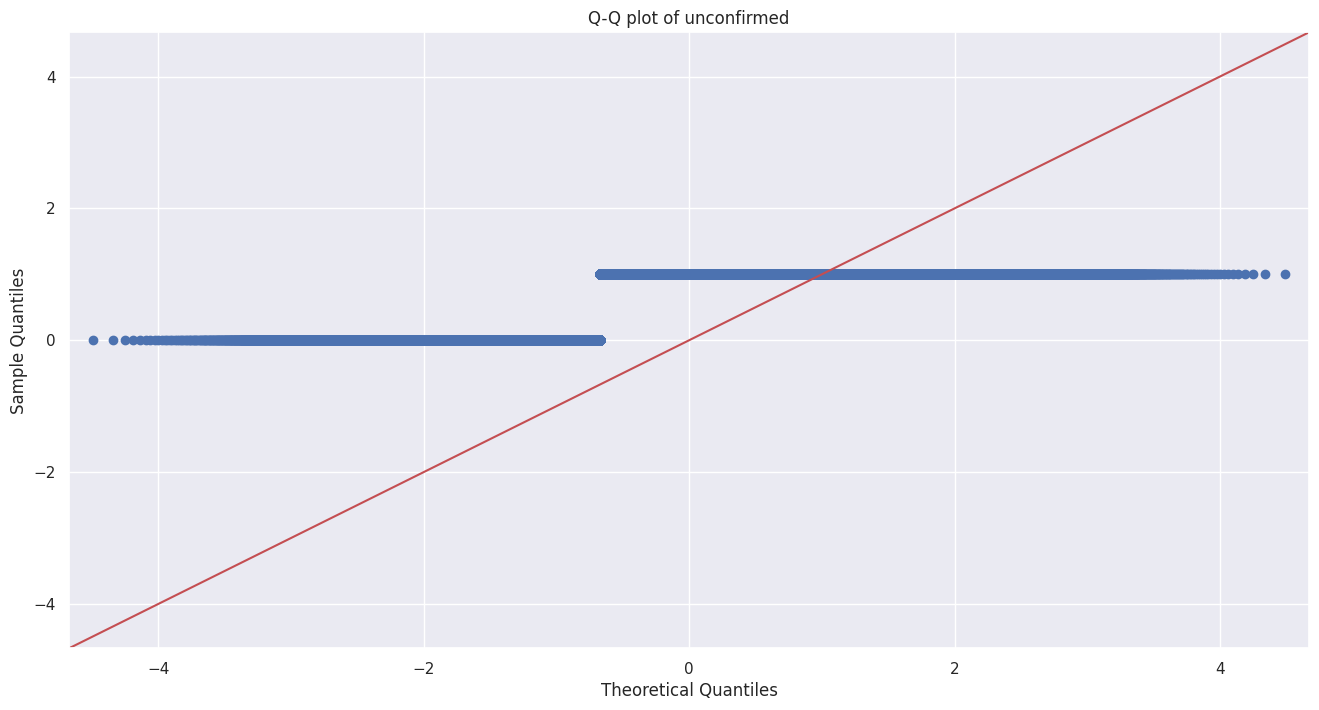

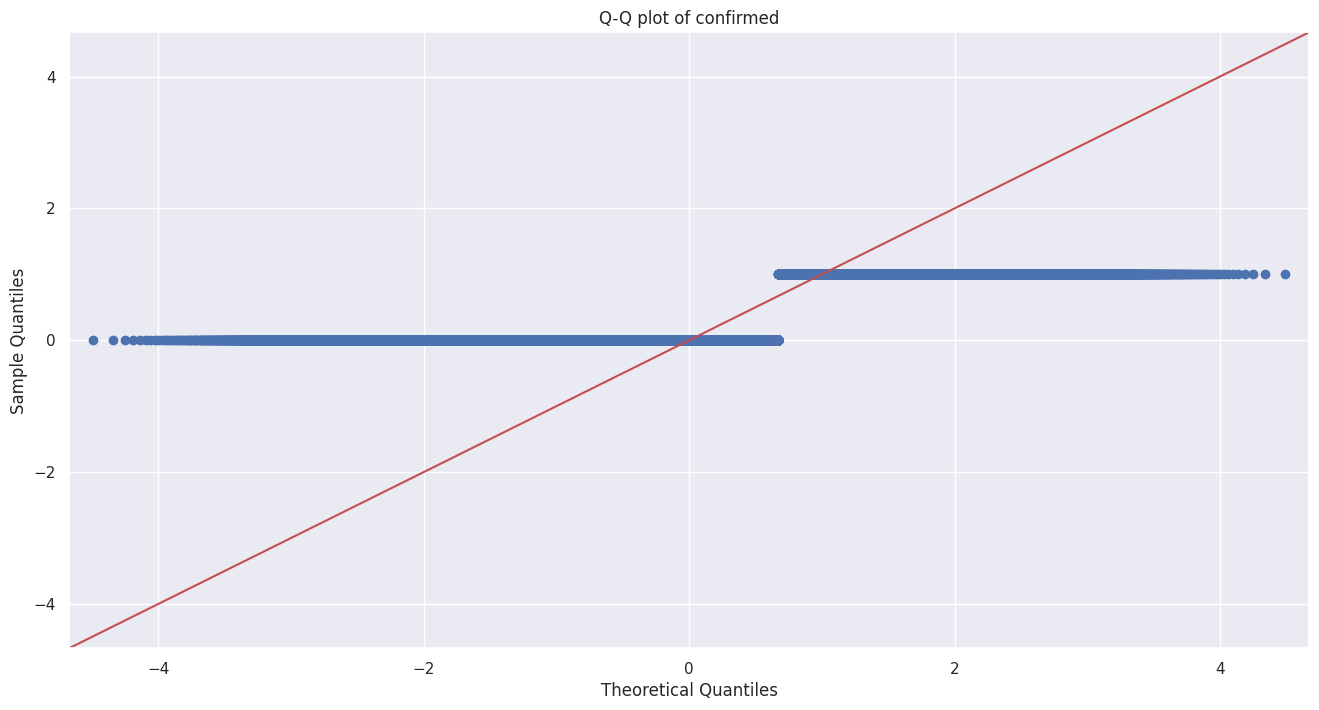

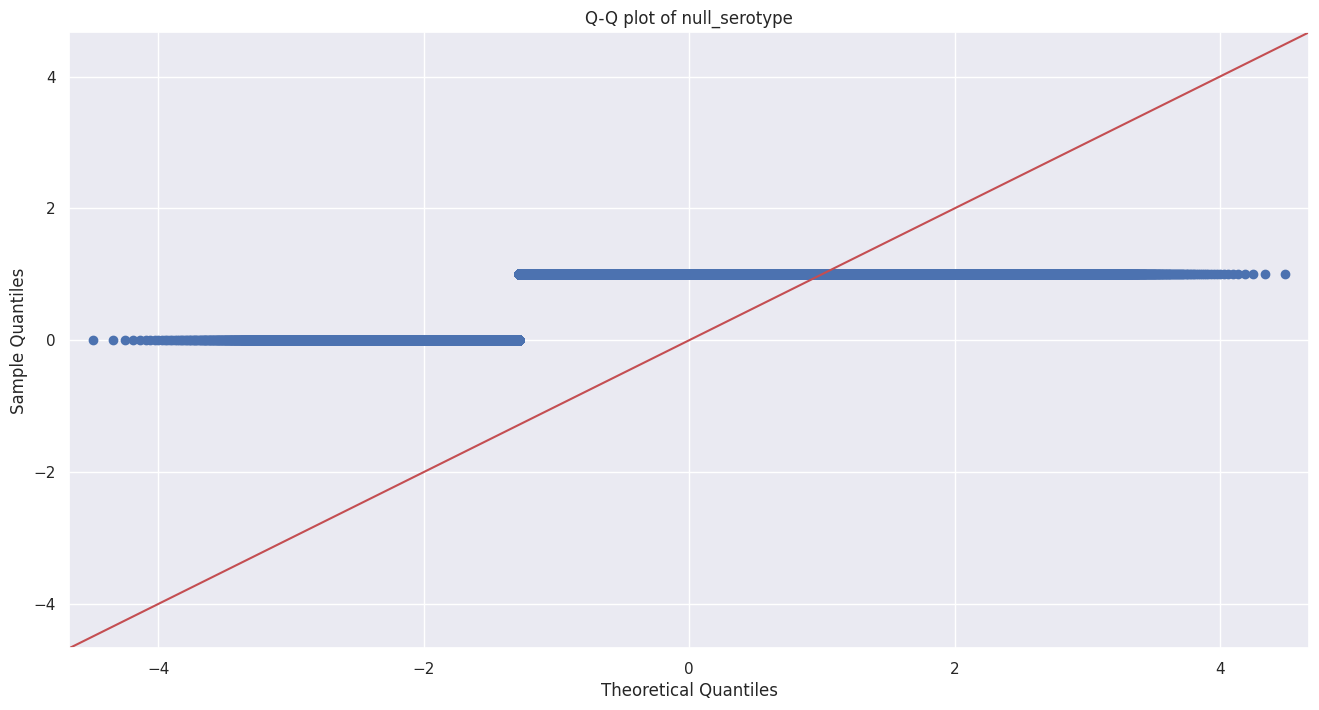

In [ ]:
import statsmodels.api as sm
for col in pandas_df.columns:
    sm.qqplot(pandas_df[col], line='45')
    plt.title('Q-Q plot of ' + col)
    plt.show()

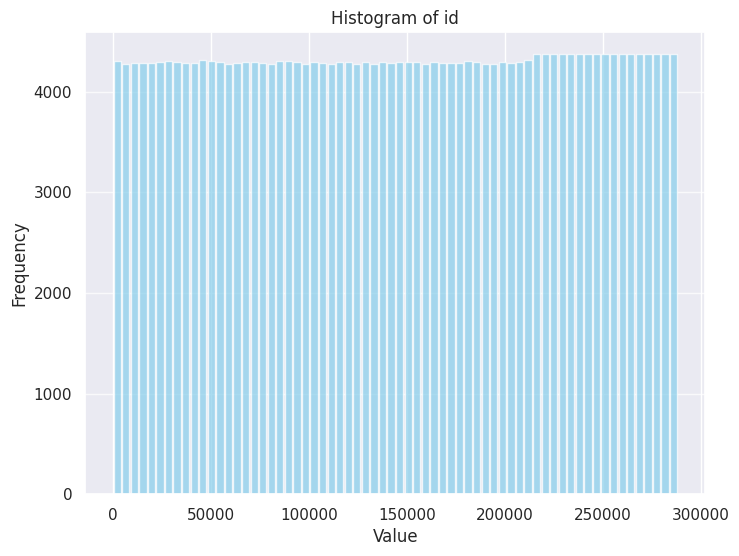

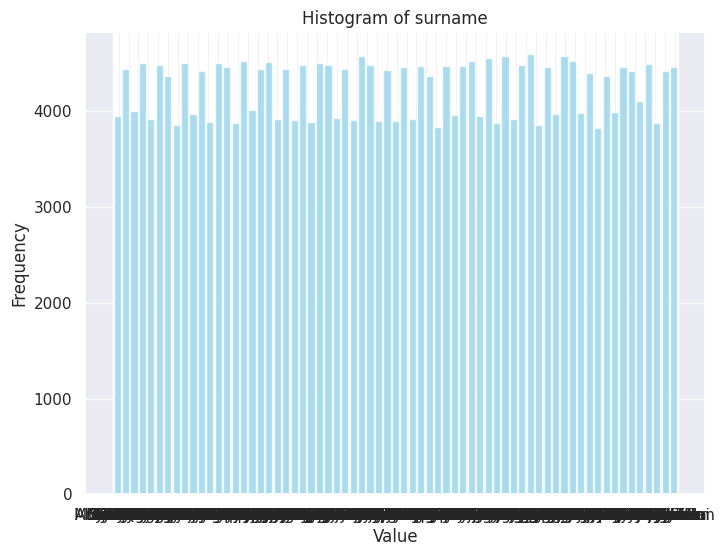

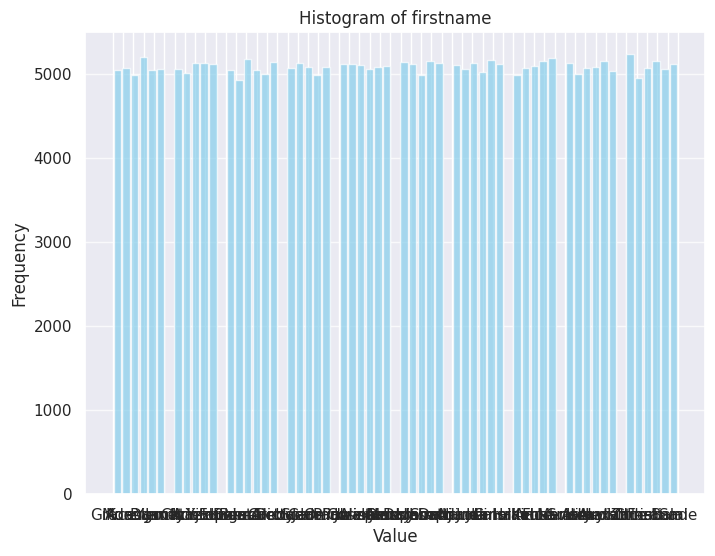

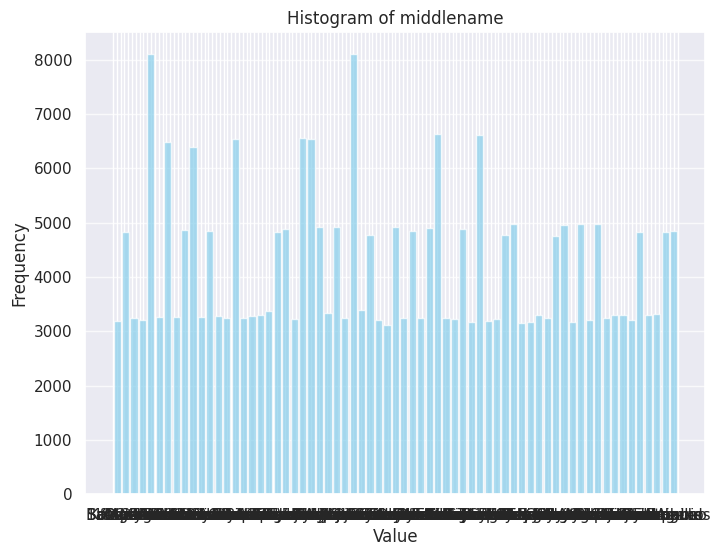

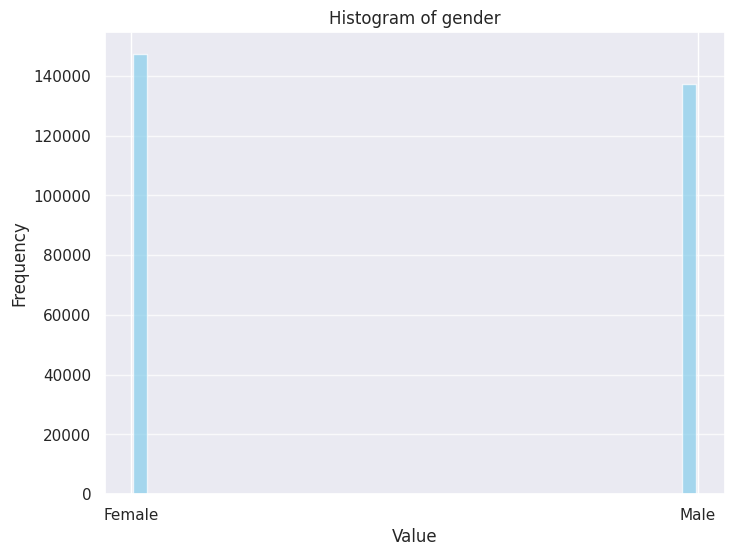

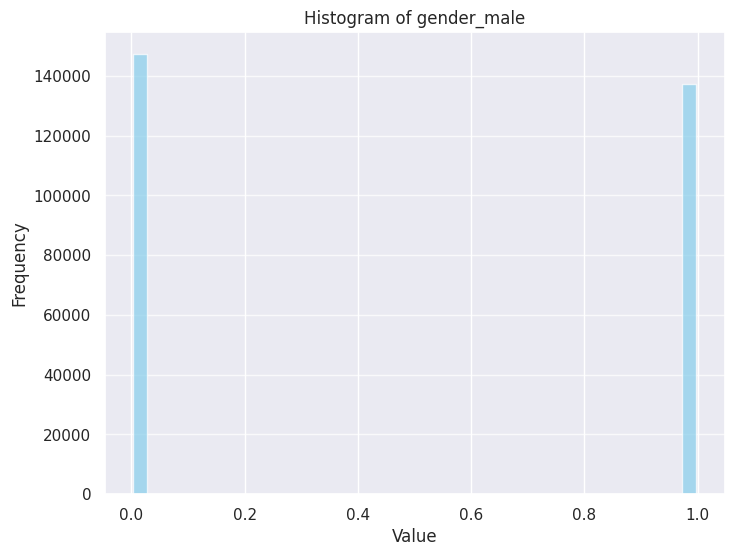

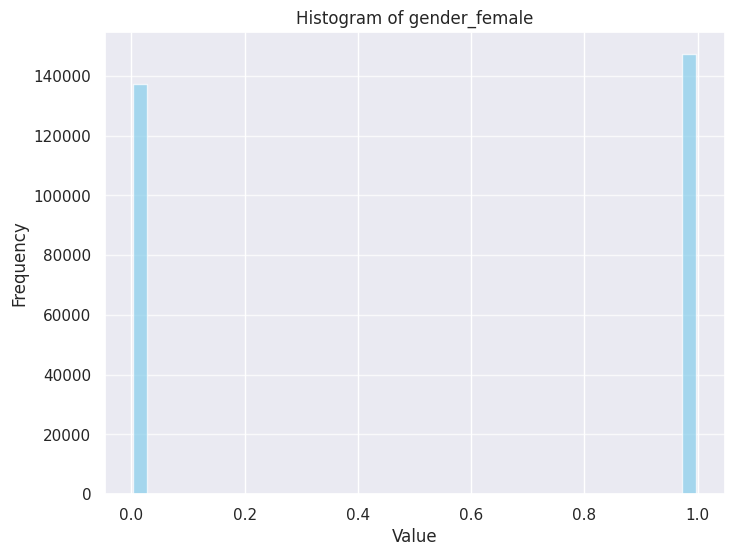

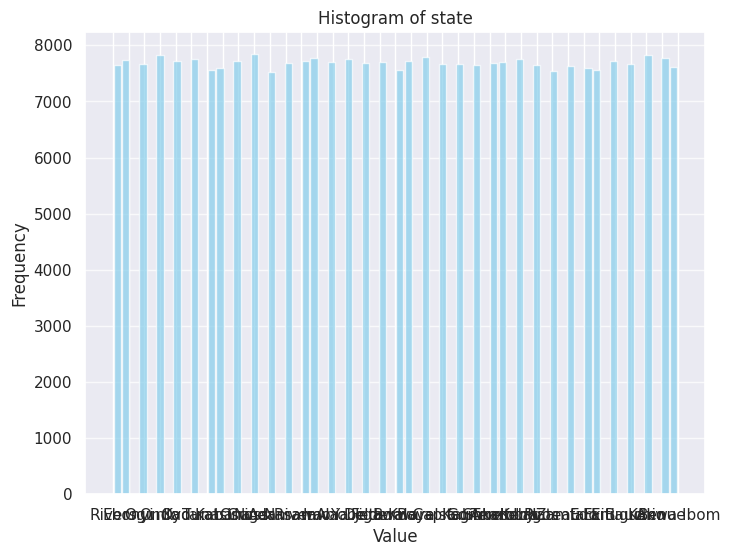

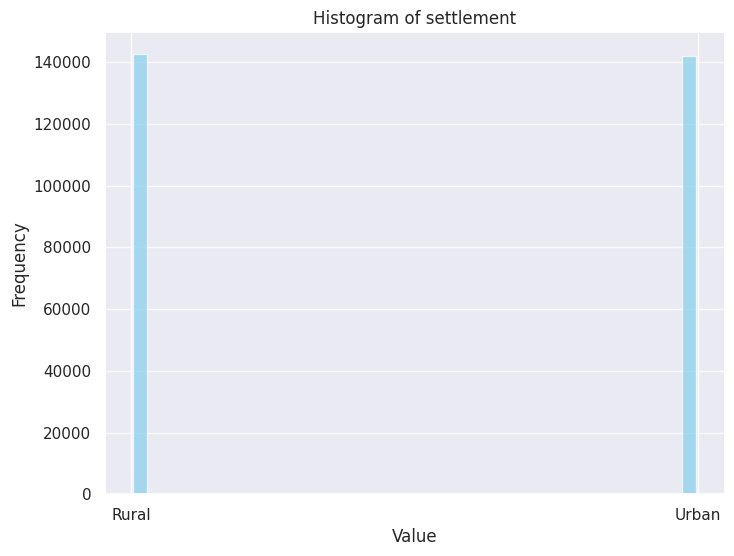

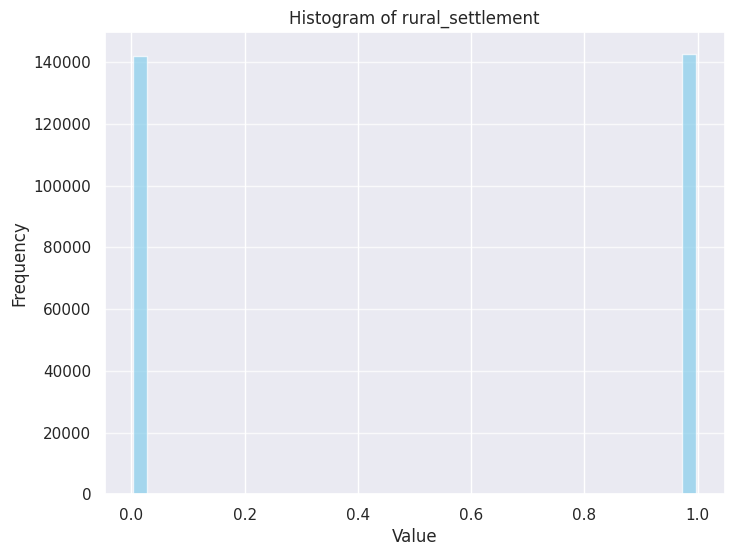

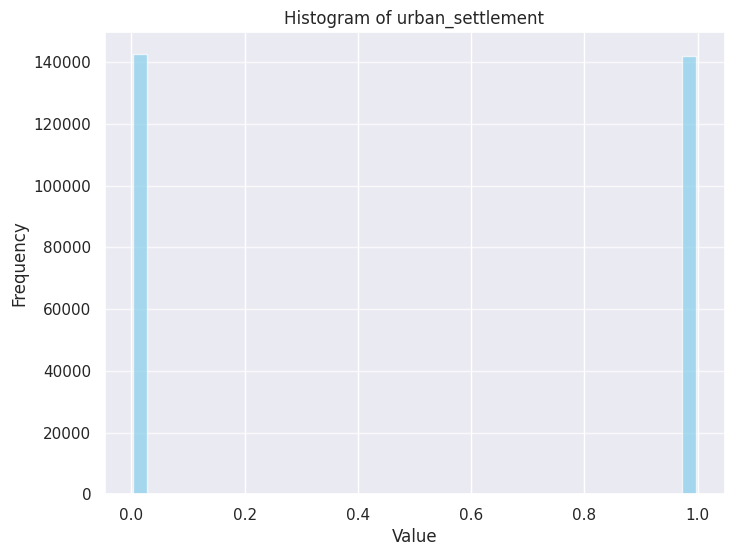

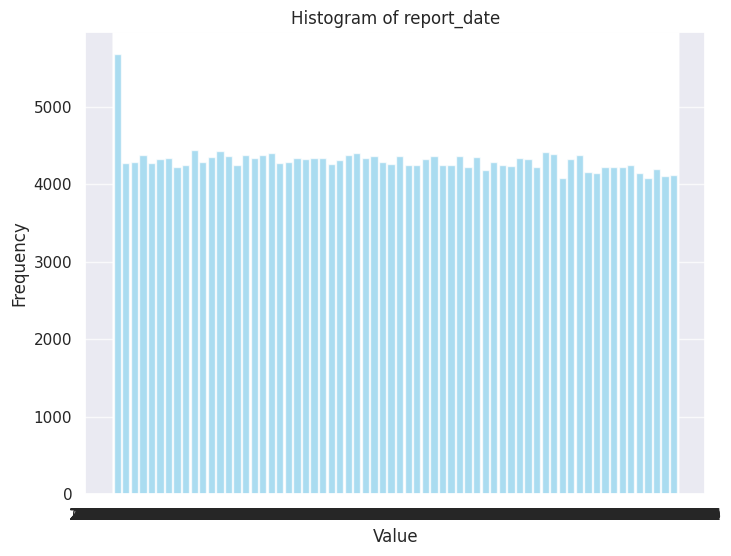

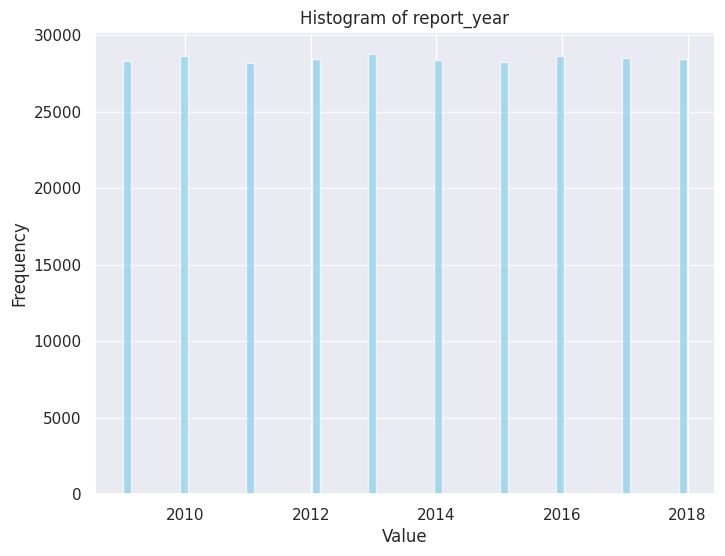

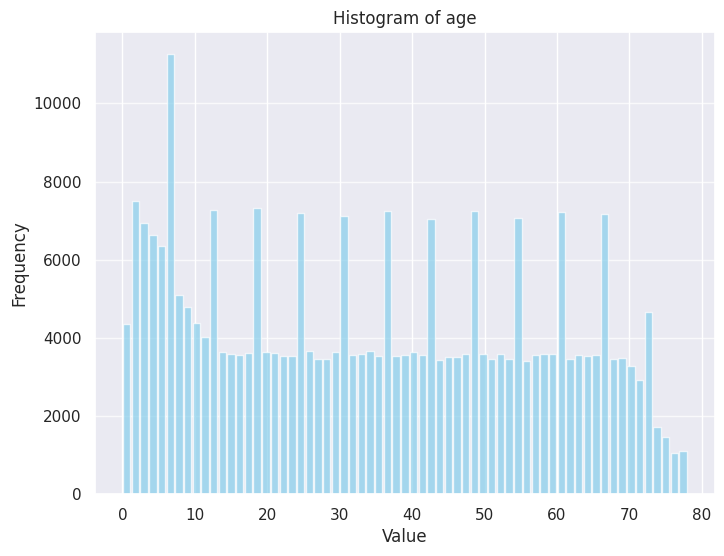

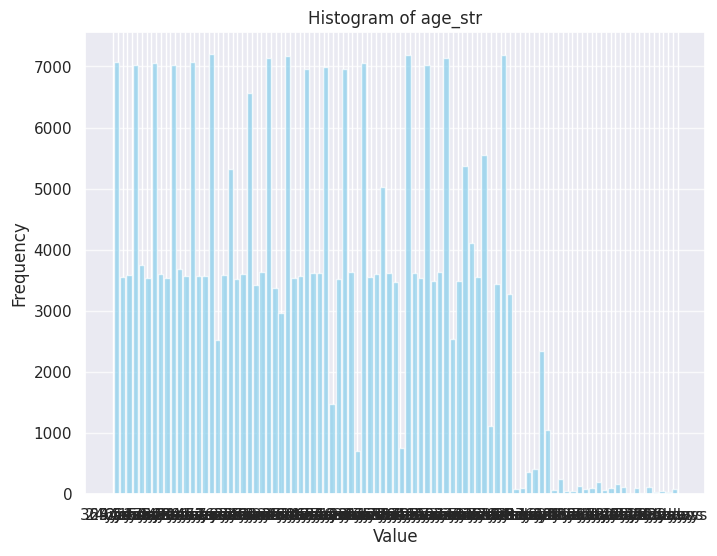

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pandas_df is your pandas DataFrame
for col in pandas_df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(pandas_df[col], bins='auto', color='skyblue', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + col)
    plt.show()


# H2O AutoML Execution

In [ ]:
df = h2o.H2OFrame(
    pandas_df
)  # Converted Pandas Dataframe to H2O dataframe to proceed with AutoML

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
df.head()

id  surname    firstname    middlename    gender      gender_male    gender_female  state    settlement      rural_settlement    urban_settlement  report_date            report_year    age  age_str    date_of_birth          child_group    adult_group  disease          cholera    diarrhoea    measles    viral_haemmorrhaphic_fever    meningitis    ebola    marburg_virus    yellow_fever    rubella_mars    malaria  serotype         NmA    NmC    NmW  health_status      alive    dead  report_outcome      unconfirmed    confirmed    null_serotype
----  ---------  -----------  ------------  --------  -------------  ---------------  -------  ------------  ------------------  ------------------  -------------------  -------------  -----  ---------  -------------------  -------------  -------------  -------------  ---------  -----------  ---------  ----------------------------  ------------  -------  ---------------  --------------  --------------  ---------  -------------  -----  -----  -----  ---------------  -------  ------  ----------------  -------------  -----------  ---------------
   1  Solade     Grace        Solape        Female                0                1  Rivers   Rural                          1                   0  2018-05-15 00:00:00           2018     32  32 years   1986-01-17 00:00:00              0              1  Cholera                1            0          0                             0             0        0                0               0               0          0  null serotype      0      0      0  alive                  1       0  confirmed                     0            1                1
   2  Eneche     Kure         Balogun       Male                  1                0  Ebonyi   Rural                          1                   0  2017-02-28 00:00:00           2017     32  32 years   1985-09-01 00:00:00              0              1  Marburg Virus          0            0          0                             0             0        0                1               0               0          0  Null               0      0      1  Alive                  1       0  Confirmed                     1            0                1
   3  Sanusi     Adaugo       Katerine      Female                0                1  Ogun     Urban                          0                   1  2012-03-02 00:00:00           2012     24  24 years   1988-05-01 00:00:00              0              1  Marburg Virus          0            0          0                             0             0        0                1               0               0          0  Null               0      0      1  Dead                   0       1  Not Confirmed                 1            0                1
   4  Sowore     Mooslemat    Ifedayo       Female                0                1  Ondo     Rural                          1                   0  2010-05-21 00:00:00           2010     63  63 years   1947-05-24 00:00:00              0              1  Measles                0            0          1                             0             0        0                0               0               0          0  Null               0      0      1  Alive                  1       0  Not Confirmed                 1            0                1
   5  Abdusalam  Yusuf        Okafor        Male                  1                0  Oyo      Urban                          0                   1  2017-08-28 00:00:00           2017      9  9 years    2008-01-07 00:00:00              1              0  Rubella Mars           0            0          0                             0             0        0                0               0               1          0  Null               0      0      1  Alive                  1       0  Confirmed                     1            0                1
   6  Yakubu     Janet        Chioma        Female                0                1  Kaduna   Rural                          1                   0  2012-06-27

In [ ]:
df.types  # Datatype of all attributes, here the result ("age") is int hence it can be solved using the regression.
# If this problem was supposed to solved using the classification method - this attributes datatype must be converted into enum

{'id': 'int',
 'surname': 'enum',
 'firstname': 'enum',
 'middlename': 'enum',
 'gender': 'enum',
 'gender_male': 'int',
 'gender_female': 'int',
 'state': 'enum',
 'settlement': 'enum',
 'rural_settlement': 'int',
 'urban_settlement': 'int',
 'report_date': 'time',
 'report_year': 'int',
 'age': 'int',
 'age_str': 'enum',
 'date_of_birth': 'time',
 'child_group': 'int',
 'adult_group': 'int',
 'disease': 'enum',
 'cholera': 'int',
 'diarrhoea': 'int',
 'measles': 'int',
 'viral_haemmorrhaphic_fever': 'int',
 'meningitis': 'int',
 'ebola': 'int',
 'marburg_virus': 'int',
 'yellow_fever': 'int',
 'rubella_mars': 'int',
 'malaria': 'int',
 'serotype': 'enum',
 'NmA': 'int',
 'NmC': 'int',
 'NmW': 'int',
 'health_status': 'enum',
 'alive': 'int',
 'dead': 'int',
 'report_outcome': 'enum',
 'unconfirmed': 'int',
 'confirmed': 'int',
 'null_serotype': 'int'}

In [ ]:
pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = df.split_frame([pct_rows])

In [ ]:
print(df_train.shape)
print(df_test.shape)

(227570, 40)
(56914, 40)


In [ ]:
df_train.head()

id  surname    firstname    middlename    gender      gender_male    gender_female  state    settlement      rural_settlement    urban_settlement  report_date            report_year    age  age_str    date_of_birth          child_group    adult_group  disease          cholera    diarrhoea    measles    viral_haemmorrhaphic_fever    meningitis    ebola    marburg_virus    yellow_fever    rubella_mars    malaria  serotype         NmA    NmC    NmW  health_status      alive    dead  report_outcome      unconfirmed    confirmed    null_serotype
----  ---------  -----------  ------------  --------  -------------  ---------------  -------  ------------  ------------------  ------------------  -------------------  -------------  -----  ---------  -------------------  -------------  -------------  -------------  ---------  -----------  ---------  ----------------------------  ------------  -------  ---------------  --------------  --------------  ---------  -------------  -----  -----  -----  ---------------  -------  ------  ----------------  -------------  -----------  ---------------
   1  Solade     Grace        Solape        Female                0                1  Rivers   Rural                          1                   0  2018-05-15 00:00:00           2018     32  32 years   1986-01-17 00:00:00              0              1  Cholera                1            0          0                             0             0        0                0               0               0          0  null serotype      0      0      0  alive                  1       0  confirmed                     0            1                1
   2  Eneche     Kure         Balogun       Male                  1                0  Ebonyi   Rural                          1                   0  2017-02-28 00:00:00           2017     32  32 years   1985-09-01 00:00:00              0              1  Marburg Virus          0            0          0                             0             0        0                1               0               0          0  Null               0      0      1  Alive                  1       0  Confirmed                     1            0                1
   3  Sanusi     Adaugo       Katerine      Female                0                1  Ogun     Urban                          0                   1  2012-03-02 00:00:00           2012     24  24 years   1988-05-01 00:00:00              0              1  Marburg Virus          0            0          0                             0             0        0                1               0               0          0  Null               0      0      1  Dead                   0       1  Not Confirmed                 1            0                1
   4  Sowore     Mooslemat    Ifedayo       Female                0                1  Ondo     Rural                          1                   0  2010-05-21 00:00:00           2010     63  63 years   1947-05-24 00:00:00              0              1  Measles                0            0          1                             0             0        0                0               0               0          0  Null               0      0      1  Alive                  1       0  Not Confirmed                 1            0                1
   5  Abdusalam  Yusuf        Okafor        Male                  1                0  Oyo      Urban                          0                   1  2017-08-28 00:00:00           2017      9  9 years    2008-01-07 00:00:00              1              0  Rubella Mars           0            0          0                             0             0        0                0               0               1          0  Null               0      0      1  Alive                  1       0  Confirmed                     1            0                1
   6  Yakubu     Janet        Chioma        Female                0                1  Kaduna   Rural                          1                   0  2012-06-27

In [ ]:
X = df.columns
print(X)

['id', 'surname', 'firstname', 'middlename', 'gender', 'gender_male', 'gender_female', 'state', 'settlement', 'rural_settlement', 'urban_settlement', 'report_date', 'report_year', 'age', 'age_str', 'date_of_birth', 'child_group', 'adult_group', 'disease', 'cholera', 'diarrhoea', 'measles', 'viral_haemmorrhaphic_fever', 'meningitis', 'ebola', 'marburg_virus', 'yellow_fever', 'rubella_mars', 'malaria', 'serotype', 'NmA', 'NmC', 'NmW', 'health_status', 'alive', 'dead', 'report_outcome', 'unconfirmed', 'confirmed', 'null_serotype']


# Start to train in 10 models by AutoML

In [ ]:
# Set target and predictor variables
y = "age"
X.remove(y)  # Removing the result from our predictors data
print(X)

['id', 'surname', 'firstname', 'middlename', 'gender', 'gender_male', 'gender_female', 'state', 'settlement', 'rural_settlement', 'urban_settlement', 'report_date', 'report_year', 'age_str', 'date_of_birth', 'child_group', 'adult_group', 'disease', 'cholera', 'diarrhoea', 'measles', 'viral_haemmorrhaphic_fever', 'meningitis', 'ebola', 'marburg_virus', 'yellow_fever', 'rubella_mars', 'malaria', 'serotype', 'NmA', 'NmC', 'NmW', 'health_status', 'alive', 'dead', 'report_outcome', 'unconfirmed', 'confirmed', 'null_serotype']


Run AutoML. The max_runtime_secs argument provides a way to limit the AutoML run by time..

In [ ]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)  # Setting of AutoML

In [ ]:
aml.train(x=X, y=y, training_frame=df_train)  # Trainig the dataset on different models. Pass the data through H20AutoML

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20231103_31810


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    154                154                         5.7586e+06             12           15           14.8117       159           1012          906.487

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0012199132157021877
RMSE: 0.034927256057442985
MAE: 0.010664571735707916
RMSLE: 0.002054013874162043
Mean Residual Deviance: 0.0012199132157021877

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.03595503374079715
RMSE: 0.18961812608713638
MAE: 0.0901544753670116
RMSLE: 0.01845344930908067
Mean Residual Deviance: 0.03595503374079715

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse         training_mae          training_deviance      validation_rmse      validation_mae       validation_deviance
---  -------------------  ----------------  -----------------  --------------------  --------------------  ---------------------  -------------------  -------------------  ---------------------
     2023-11-03 03:19:26  0.010 sec         0.0                22.20446826532547     19.346519790149337    493.0384109458459      22.368262107964124   19.55018040046126    500.33914973058364
     2023-11-03 03:19:32  6.421 sec         5.0                13.111756185417613    11.423984726169305    171.91815026583706     13.209350603573387   11.544581703414776   174.48694336812463
     2023-11-03 03:19:36  10.506 sec        10.0               7.75246405624452      6.752869749197277     60.10069894336324      7.81576802431253     6.827648794653377    61.08622980986618
     2023-11-03 03:19:41  15.484 sec        15.0               4.592916483953435     3.99753640277364      21.094881828571186     4.63613248281591     4.043732496533497    21.493724398220817
     2023-11-03 03:19:45  19.366 sec        20.0               2.7275404981711437    2.3686333317638284    7.439477169163691      2.760589952588522    2.3982849043710446   7.620856886332697
     2023-11-03 03:19:49  23.142 sec        25.0               1.625703444048098     1.4050051955504008    2.6429116879898475     1.661908508461214    1.4283741073377334   2.7619398904957766
     2023-11-03 03:19:52  26.266 sec        30.0               1.0554757972385513    0.9086260300935002    1.1140291585563553     1.114433130340161    0.9452123961756733   1.24196120199977
     2023-11-03 03:19:55  29.019 sec        35.0               0.6341915793843707    0.538400484783511     0.40219895936204253    0.7031615937809609   0.5726801976509098   0.4944362269685811
     2023-11-03 03:19:57  31.687 sec        40.0               0.38905986441941504   0.32149890144933335   0.15136757810205362    0.47144864957666555  0.3560959338836003   0.22226382918766158
     2023-11-03 03:20:00  34.513 sec        45.0               0.24569463759583485   0.19341518161664337   0.06036585494334862    0.34445055178041756  0.23121732232683867  0.1186461826218341
---  ---                  ---               ---                ---                   ---                   ---                    ---                  ---                  ---
     2023-11-03 03:20:42  1 min 16.062 sec  110.0              0.042840452180342437  0.015377018013719643  0.0018353043430162069  0.19082080232618304  0.09024661594039884  0.03641257860040822
     2023-11-03 03:20:44  1 min 18.481 sec  115.0              0.04091260985180498   0.014488543108578987  0.00167384164488601    0.1903396849284431   0.09015804425160504  0.036229195658658994
     2023-11-03 03:20:46  1 min 20.842 sec  120.0              0.03992370738806084   0.01392812920

Interpreting the above results

1. MAE: The mean absolute error (MAE) is the average absolute difference between the target values and the predicted values. This metric ranges from zero to infinity; a lower value indicates a higher quality model.

2. RMSE: The root-mean-square error metric is a frequently used measure of the differences between the values predicted by a model or an estimator and the values observed. This metric ranges from zero to infinity; a lower value indicates a higher quality model.

3. RMSLE: The root-mean-squared logarithmic error metric is similar to RMSE, except that it uses the natural logarithm of the predicted and actual values plus 1. RMSLE penalizes under-prediction more heavily than over-prediction. It can also be a good metric when you don't want to penalize differences for large prediction values more heavily than for small prediction values. This metric ranges from zero to infinity; a lower value indicates a higher quality model. The RMSLE evaluation metric is returned only if all label and predicted values are non-negative.

4. r^2: r squared (r^2) is the square of the Pearson correlation coefficient between the labels and predicted values. This metric ranges between zero and one; a higher value indicates a higher quality model.

5. MAPE: Mean absolute percentage error (MAPE) is the average absolute percentage difference between the labels and the predicted values. This metric ranges between zero and infinity; a lower value indicates a higher quality model.

6. K-fold cross-validation is used to validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split.

Next, we will view the AutoML Leaderboard. Since we specified a leaderboard_frame in the h2o.automl() function for scoring and ranking the models, the AutoML leaderboard uses the performance on this data to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of regression, the default ranking metric is mean residual deviance.

In [ ]:
# View the AutoML Leaderboard
print(
    aml.leaderboard
)

# Leaderboard showing the performance of different models on the dataset.

model_id                                                    rmse        mse        mae        rmsle    mean_residual_deviance
GBM_1_AutoML_1_20231103_31810                           0.189618  0.035955   0.0901545    0.0184534                 0.035955
StackedEnsemble_AllModels_1_AutoML_1_20231103_31810     0.191594  0.0367081  0.0730712    0.0154664                 0.0367081
StackedEnsemble_BestOfFamily_1_AutoML_1_20231103_31810  0.197213  0.0388931  0.0675959    0.0158767                 0.0388931
StackedEnsemble_BestOfFamily_2_AutoML_1_20231103_31810  0.197253  0.0389088  0.0676858    0.0158831                 0.0389088
XGBoost_1_AutoML_1_20231103_31810                       0.323165  0.104436   0.0627127    0.0223537                 0.104436
XGBoost_2_AutoML_1_20231103_31810                       0.87364   0.763247   0.227006     0.0467033                 0.763247
GBM_2_AutoML_1_20231103_31810                           1.21033   1.46489    1.04423      0.149964                  1.464

# Interpreting the leaderboard:

The models listed in the leaderboard are ranked based on their rmse score, where a lower score indicates better performance. The top row in the leaderboard represents the best-performing model with the lowest rmse score. The evaluation metrics can be used to compare the performance of different models and help in selecting the best model for the particular use case.

In this leaderboard, the best performing model is

StackedEnsemble_AllModels_1_AutoML_1_20231103_10716 with an rmse score of 0.137187

The second-best model is StackedEnsemble_BestOfFamily_1_AutoML_1_20231103_10716 with an rmse score of 0.137792

The models are then listed in descending order based on their rmse scores.

In [ ]:
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

{'GBM_1_AutoML_1_20231103_31810': 0, 'GLM_1_AutoML_1_20231103_31810': 7}

In [ ]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])

0


In [ ]:
best_model.algo

'gbm'

In [ ]:
best_model = aml.leader
best_model.model_performance(df_train)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.010471732629299374
RMSE: 0.10233148405695763
MAE: 0.034139742570736015
RMSLE: 0.01062722412470637
Mean Residual Deviance: 0.010471732629299374

The output we received represents the model performance metrics for a stacked ensemble model.

The lower the values of rmse the better the model is.

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

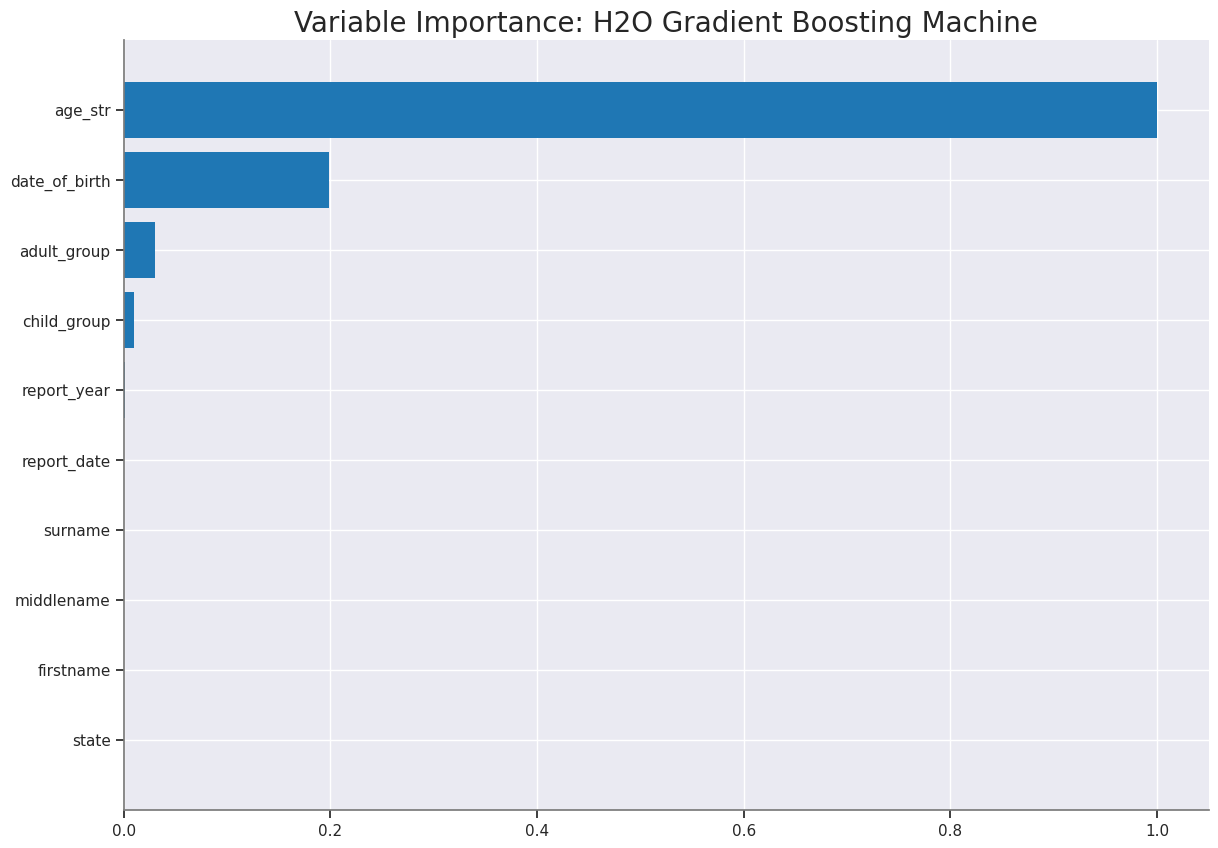

<Figure size 1600x800 with 0 Axes>

In [ ]:
if best_model.algo in [
    "gbm",
    "glm",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

7
glm


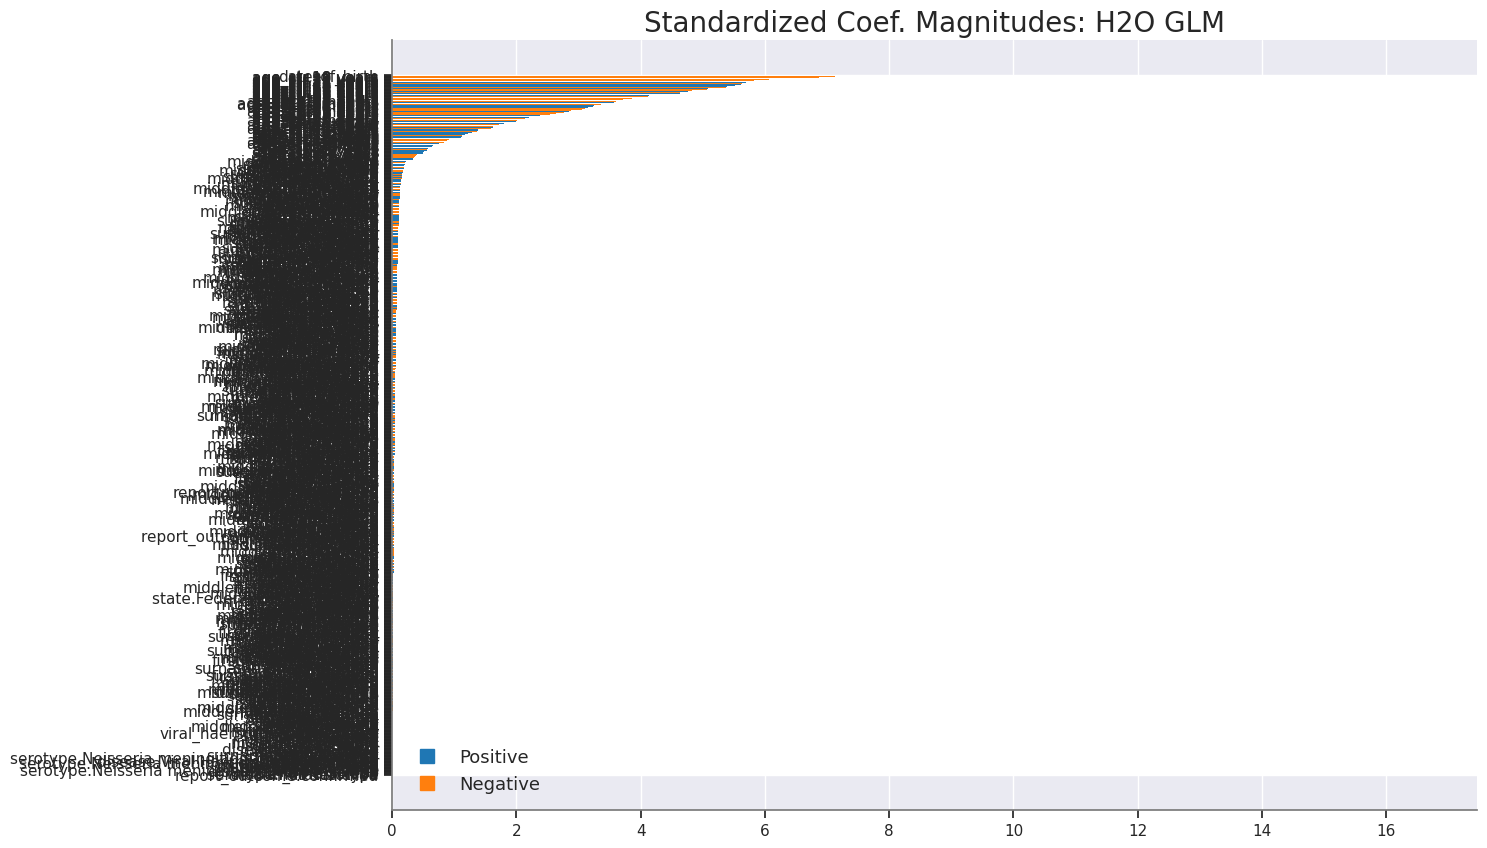

In [ ]:
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

In [ ]:
print(best_model.rmse(train=True))

0.034927256057442985


In [ ]:
def model_performance_stats(perf):
    d = {}
    try:
        d["mse"] = perf.mse()
    except:
        pass
    try:
        d["rmse"] = perf.rmse()
    except:
        pass
    try:
        d["null_degrees_of_freedom"] = perf.null_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_degrees_of_freedom"] = perf.residual_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_deviance"] = perf.residual_deviance()
    except:
        pass
    try:
        d["null_deviance"] = perf.null_deviance()
    except:
        pass
    try:
        d["aic"] = perf.aic()
    except:
        pass
    try:
        d["logloss"] = perf.logloss()
    except:
        pass
    try:
        d["auc"] = perf.auc()
    except:
        pass
    try:
        d["gini"] = perf.gini()
    except:
        pass
    return d

In [ ]:
mod_perf = best_model.model_performance(df_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 0.033451217205818964,
 'rmse': 0.1828967391885896,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [ ]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
y_pred = h2o.as_list(
    predictions
)  # Predictions on Test Dataset using the best model from the leaderboard.
print(y_pred)


         predict
0      32.007797
1      63.157622
2      14.953664
3      48.061954
4      29.958595
...          ...
56909  26.041321
56910  20.045518
56911  43.736024
56912  68.022041
56913  33.029622

[56914 rows x 1 columns]


In [ ]:
print(X)

['id', 'surname', 'firstname', 'middlename', 'gender', 'gender_male', 'gender_female', 'state', 'settlement', 'rural_settlement', 'urban_settlement', 'report_date', 'report_year', 'age_str', 'date_of_birth', 'child_group', 'adult_group', 'disease', 'cholera', 'diarrhoea', 'measles', 'viral_haemmorrhaphic_fever', 'meningitis', 'ebola', 'marburg_virus', 'yellow_fever', 'rubella_mars', 'malaria', 'serotype', 'NmA', 'NmC', 'NmW', 'health_status', 'alive', 'dead', 'report_outcome', 'unconfirmed', 'confirmed', 'null_serotype']


# Analysing relation between all variables

When all independent variables were plotted against 'age' variable it is observed that for'Disease' and 'State' roughly a linear line is obtained. So it can be concluded from this plot that variables Disease and State have linear relation with Price.

VIF stands for Variance Inflation Factor.It signifies multicollinearity among set of different independent variable. A value greater than 10 means that the independent variable is highly correlated with some other variable. Will calculate VIF value for all variables to check the dependency and then will drop the variables with high VIF value.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
vif_X = pandas_df[['gender_male', 'gender_female', 'rural_settlement', 'urban_settlement', 'report_year', 'age' , 'child_group', 'adult_group','cholera'	,'diarrhoea',	'measles',	'viral_haemmorrhaphic_fever',	'meningitis',	'ebola',	'marburg_virus',	'yellow_fever',	'rubella_mars',	'NmA',	'NmC',	'NmW',	'alive',	'dead',	'unconfirmed',	'confirmed'	, 'null_serotype']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                       feature           VIF
0                  gender_male           inf
1                gender_female           inf
2             rural_settlement           inf
3             urban_settlement           inf
4                  report_year  1.012190e+00
5                          age  2.506080e+00
6                  child_group           inf
7                  adult_group           inf
8                      cholera  1.800795e+00
9                    diarrhoea  1.799818e+00
10                     measles  1.797866e+00
11  viral_haemmorrhaphic_fever  1.976339e+00
12                  meningitis           inf
13                       ebola  1.969595e+00
14               marburg_virus  1.977198e+00
15                yellow_fever  1.796813e+00
16                rubella_mars  1.980520e+00
17                         NmA  6.865800e+03
18                         NmC  6.953227e+03
19                         NmW  1.346419e+04
20                       alive           inf
21        

Considering the significance value of 0.05 because accuracy in predicting the age of the abalone is not that critical

Except PM2.5 has the p-value 0.646, which is greater and hence it is a non significant feature, all other features are significant.

VIF for 'alive','dead','unconfirmed','confirmed' and 'meningitis' and many more parameters is inf.

Now, will drop the variables unconfirmed, confirmed and YearBuilt.

Ordinary least squares (OLS) regression is a statistical method of analysis used for multivariate model that estimates the relationship between one or more independent variables and a dependent variable; the method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values of the dependent variable.

In [ ]:
import statsmodels.formula.api as smf #OLS model Library
#Using OLS for finding the p value to check the significant features
results = smf.ols(
    "age ~ gender_male + gender_female + rural_settlement + urban_settlement + report_year + child_group + adult_group + cholera + diarrhoea + measles + viral_haemmorrhaphic_fever + meningitis + ebola + marburg_virus + yellow_fever + rubella_mars + NmA + NmC + NmW + alive + dead + unconfirmed + confirmed + null_serotype",
    data=pandas_df,
).fit()

# Print out the statistics
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 2.380e+04
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:45:36   Log-Likelihood:            -1.1554e+06
No. Observations:              284484   AIC:                         2.311e+06
Df Residuals:                  284465   BIC:                         2.311e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -193.9609      5.820    -33.325      0.000    -205.368    -182.553
gender_male                  -96.9475      2.910    -33.312      0.000    -102.652     -91.243
gender_female                -97.0134      2.910    -33.336      0.000    -102.717     -91.309
rural_settlement             -96.9530      2.910    -33.315      0.000    -102.657     -91.249
urban_settlement             -97.0078      2.910    -33.332      0.000    -102.712     -91.304
report_year                    0.3909      0.009     42.488      0.000       0.373       0.409
child_group                 -115.8125      2.909    -39.818      0.000    -121.513    -110.112
adult_group                  -78.1484      2.912    -26.837      0.000     -83.856     -72.441
cholera                        0.1054      0.118      0.896      0.370      -0.125       0.336
diarrhoea                      0.1090      0.118      0.927      0.354      -0.122       0.339
measles                        0.0115      0.118      0.098      0.922      -0.219       0.242
viral_haemmorrhaphic_fever     0.0769      0.124      0.622      0.534      -0.165       0.319
meningitis                   -97.0846      2.911    -33.351      0.000    -102.790     -91.379
ebola                          0.0335      0.124      0.271      0.787      -0.209       0.276
marburg_virus                  0.1304      0.124      1.056      0.291      -0.112       0.372
yellow_fever                  -0.0023      0.118     -0.020      0.984      -0.233       0.228
rubella_mars                  -0.0712      0.123     -0.577      0.564      -0.313       0.171
NmA                           15.8998     14.052      1.132      0.258     -11.641      43.441
NmC                           15.7803     14.052      1.123      0.261     -11.761      43.321
NmW                           15.5427     14.050      1.106      0.269     -11.995      43.081
alive                        -96.9705      2.910    -33.321      0.000    -102.674     -91.267
dead                         -96.9903      2.910    -33.327      0.000    -102.694     -91.286
unconfirmed                  -96.9725      2.910    -33.319      0.000    -102.677     -91.268
confirmed                    -96.9884      2.910    -33.326      0.000    -102.692     -91.284
null_serotype                -96.8763      2.911    -33.278      0.000    -102.582     -91.170
==============================================================================
Omnibus:                     9151.100   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4252.683
Skew:                           0.015   Prob(JB):                         0.00
Kurtosis:                       2.402   Cond. No.                     1.89e+19
============================

As seen from the OLS summary p-value for 'NmA', 'NmC' and 'NmW', is greater than 0.05. An extra variable 'NmA' is unneccsary as 'NmC','NmB' and 'chloera' will help us tell the location.

Dropping them will give us a model with all variables whose p-values are less than 0.05.

The accuracy for this model is 60.1%. Now will check VIF and p-values again for the selected independent variables.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Indicate which variables to compute VIF
Multic = pandas_df[['gender_male', 'gender_female', 'rural_settlement', 'urban_settlement', 'report_year', 'age' , 'child_group', 'adult_group', 'cholera'	,'diarrhoea',	'measles',	'viral_haemmorrhaphic_fever',	'meningitis',	'ebola',	'marburg_virus',	'yellow_fever',	'rubella_mars',	'alive',	'dead',	'unconfirmed',	'confirmed']]
#Compute VIF
vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

variables       VIF
0                  gender_male       inf
1                gender_female       inf
2             rural_settlement       inf
3             urban_settlement       inf
4                  report_year  1.012178
5                          age  2.506039
6                  child_group       inf
7                  adult_group       inf
8                      cholera  1.800763
9                    diarrhoea  1.799818
10                     measles  1.797866
11  viral_haemmorrhaphic_fever  1.976337
12                  meningitis  1.975139
13                       ebola  1.969594
14               marburg_virus  1.977197
15                yellow_fever  1.796813
16                rubella_mars  1.980519
17                       alive       inf
18                        dead       inf
19                 unconfirmed       inf
20                   confirmed       inf

VIF for all variables is less than 10.

In [ ]:
import statsmodels.formula.api as smf #OLS model Library
results = smf.ols("age ~ gender_male + gender_female + rural_settlement + urban_settlement + report_year + child_group + adult_group + cholera + diarrhoea + measles + viral_haemmorrhaphic_fever + meningitis + ebola + marburg_virus + yellow_fever + rubella_mars + NmA + NmC + NmW + alive + dead",
                   data=pandas_df,
                  ).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 2.520e+04
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:46:07   Log-Likelihood:            -1.1554e+06
No. Observations:              284484   AIC:                         2.311e+06
Df Residuals:                  284466   BIC:                         2.311e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -258.5852      7.760    -33.321      0.000    -273.795    -243.375
gender_male                 -129.2597      3.880    -33.312      0.000    -136.865    -121.654
gender_female               -129.3256      3.880    -33.329      0.000    -136.931    -121.720
rural_settlement            -129.2652      3.880    -33.314      0.000    -136.870    -121.660
urban_settlement            -129.3200      3.880    -33.327      0.000    -136.925    -121.715
report_year                    0.3909      0.009     42.489      0.000       0.373       0.409
child_group                 -148.1247      3.879    -38.191      0.000    -155.727    -140.523
adult_group                 -110.4605      3.882    -28.455      0.000    -118.069    -102.852
cholera                        0.1054      0.118      0.897      0.370      -0.125       0.336
diarrhoea                      0.1090      0.118      0.927      0.354      -0.122       0.340
measles                        0.0115      0.118      0.098      0.922      -0.219       0.242
viral_haemmorrhaphic_fever     0.0848      0.118      0.720      0.471      -0.146       0.316
meningitis                    -0.2004      0.144     -1.388      0.165      -0.483       0.082
ebola                          0.0415      0.118      0.351      0.725      -0.190       0.273
marburg_virus                  0.1383      0.118      1.175      0.240      -0.092       0.369
yellow_fever                  -0.0023      0.118     -0.020      0.984      -0.233       0.228
rubella_mars                  -0.0632      0.118     -0.538      0.591      -0.294       0.167
NmA                           15.9078     14.052      1.132      0.258     -11.633      43.449
NmC                           15.7883     14.052      1.124      0.261     -11.752      43.329
NmW                           15.5507     14.050      1.107      0.268     -11.987      43.089
alive                       -129.2827      3.880    -33.318      0.000    -136.888    -121.678
dead                        -129.3025      3.880    -33.323      0.000    -136.908    -121.697
==============================================================================
Omnibus:                     9151.159   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4252.703
Skew:                           0.015   Prob(JB):                         0.00
Kurtosis:                       2.402   Cond. No.                     2.96e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.32e-27. This might indicate that there are
strong multicollinearity problems or that the design matri

P-values for all the variables are less than 0.05 and the accuracy is 76.4%. It is unaffected even after removing 'Address' and 'Date' tells us that these two variables were not important for calculating 'Price'.

In [ ]:
#Dropping the unecessary features as discussed above
dfpd = pd.read_csv("https://raw.githubusercontent.com/ronakmishra619/Data_Science_Assignment/main/meningitis_dataset.csv")
dfpd1=dfpd.drop(['alive','dead','unconfirmed','confirmed','age_str','null_serotype', 'id','middlename','gender_male', 'gender_female', 'urban_settlement', 'rural_settlement', 'cholera', 'diarrhoea', 'measles', 'viral_haemmorrhaphic_fever' , 'meningitis', 'ebola', 'marburg_virus', 'yellow_fever', 'rubella_mars', 'malaria', 'NmA', 'NmC', 'NmW', 'serotype','report_outcome', 'date_of_birth'], axis=1)


In [ ]:
dfpd1

surname  firstname  gender        state settlement report_date  \
0          Solade      Grace  Female       Rivers      Rural  2018-05-15   
1          Eneche       Kure    Male       Ebonyi      Rural  2017-02-28   
2          Sanusi     Adaugo  Female         Ogun      Urban  2012-03-02   
3          Sowore  Mooslemat  Female         Ondo      Rural  2010-05-21   
4       Abdusalam      Yusuf    Male          Oyo      Urban  2017-08-28   
...           ...        ...     ...          ...        ...         ...   
284479    Mukthar     Alimat  Female  Cross River      Rural  2012-08-24   
284480    Akenzua    Deborah  Female        Kwara      Urban  2009-01-19   
284481        Isa    Deborah  Female      Katsina      Rural  2010-06-10   
284482        Uba     Ismail    Male       Jigawa      Rural  2016-01-11   
284483       Alao    Paulina  Female         Kogi      Urban  2013-08-18   

        report_year  age  child_group  adult_group        disease  \
0              2018   32            0            1        Cholera   
1              2017   32            0            1  Marburg Virus   
2              2012   24            0            1  Marburg Virus   
3              2010   63            0            1        Measles   
4              2017    9            1            0   Rubella Mars   
...             ...  ...          ...          ...            ...   
284479         2012   67            0            1          Ebola   
284480         2009   64            0            1          Ebola   
284481         2010   33            0            1        Malaria   
284482         2016   18            0            1        Malaria   
284483         2013    7            1            0   Yellow Fever   

       health_status  
0              alive  
1              Alive  
2               Dead  
3              Alive  
4              Alive  
...              ...  
284479          Dead  
284480          Dead  
284481         Alive  
284482          Dead  
284483         Alive  

[284484 rows x 12 columns]

In [ ]:
dfpd1.corr()

report_year       age  child_group  adult_group
report_year     1.000000  0.108755    -0.075731     0.075731
age             0.108755  1.000000    -0.773576     0.773576
child_group    -0.075731 -0.773576     1.000000    -1.000000
adult_group     0.075731  0.773576    -1.000000     1.000000

Text(0.5, 1.0, 'Variable Correlation')

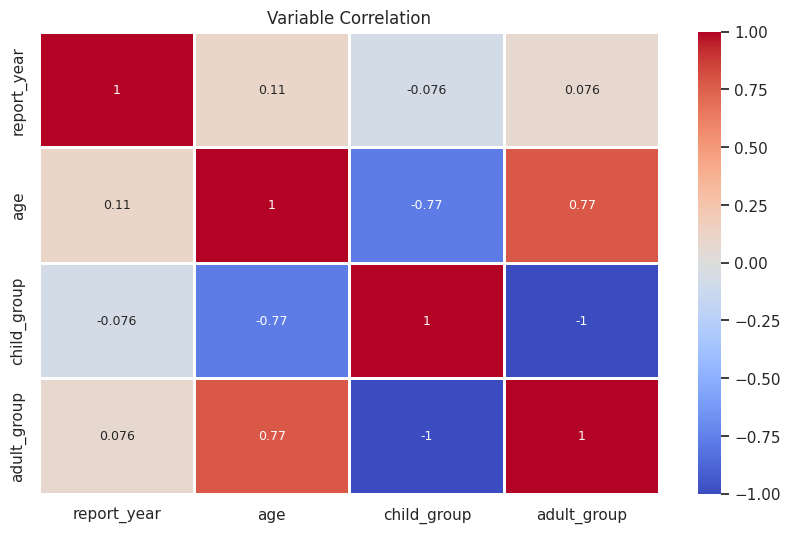

In [ ]:
#Representing the same matrix in form of heatmap where shades of blue signify inverse relation and shades of red signify direct relation.

from IPython.core.pylabtools import figsize
f,ax=plt.subplots(figsize=(10,6))

sns.heatmap(dfpd1.corr(),center=0, linewidths=0.8,cmap='coolwarm',annot=True, annot_kws={"size": 9})
plt.title('Variable Correlation')

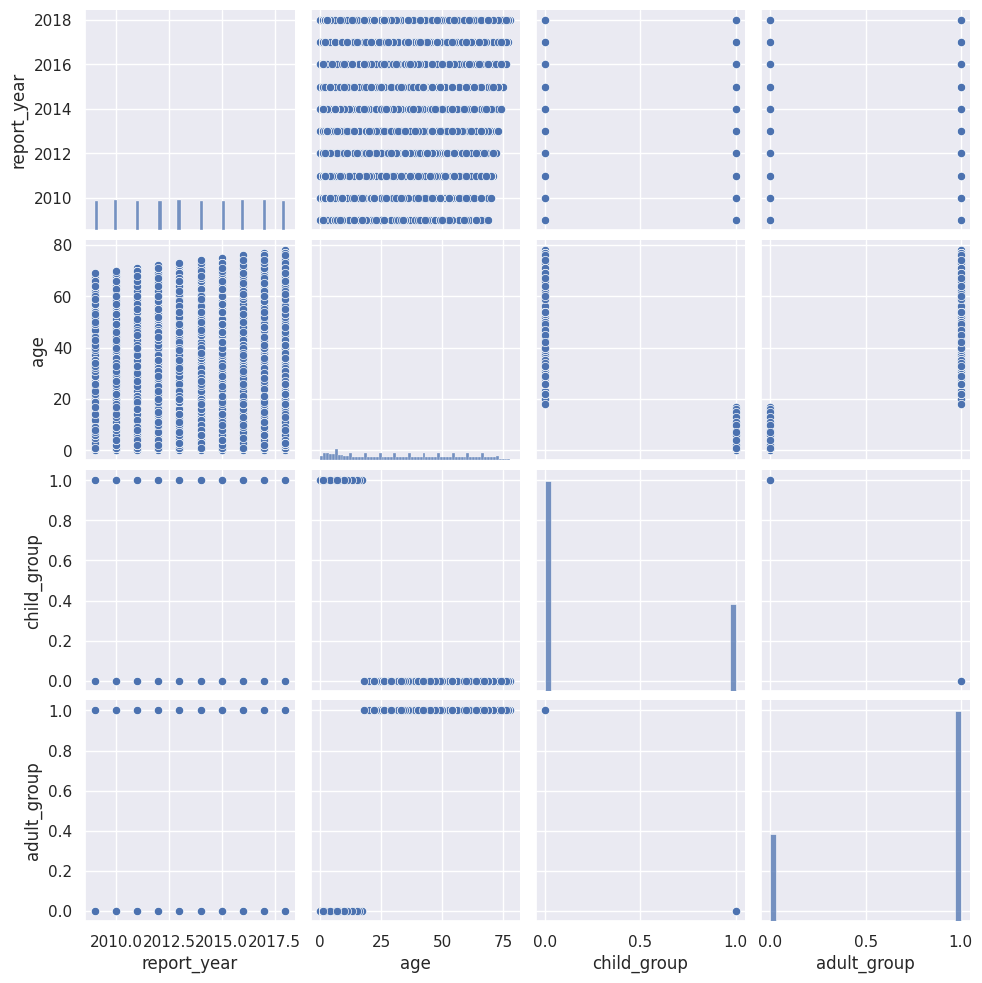

In [ ]:
sns.pairplot(dfpd1)

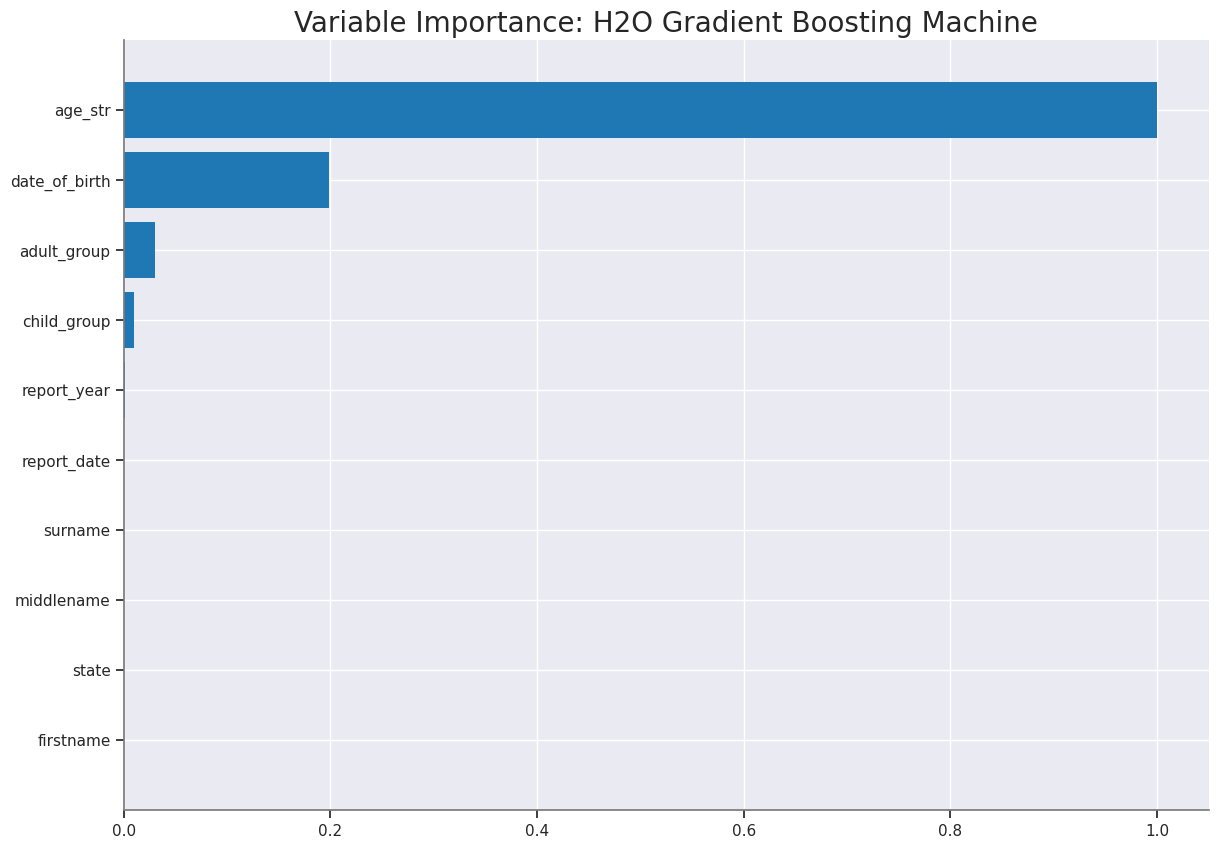

<Figure size 1600x800 with 0 Axes>

In [ ]:
if best_model.algo in ['xgboost','drf','gbm']:
  best_model.varimp_plot()
else:
  print(best_model.params)

In [ ]:
other_best_model = h2o.get_model(aml.leaderboard[5,'model_id'])
other_best_model.varimp(use_pandas=True)

variable  relative_importance  scaled_importance    percentage
0       date_of_birth         6.624528e+07       1.000000e+00  7.153271e-01
1         child_group         2.044910e+07       3.086877e-01  2.208127e-01
2         report_date         5.630477e+05       8.499439e-03  6.079879e-03
3    age_str.18 years         5.034186e+05       7.599313e-03  5.435995e-03
4    age_str.19 years         4.900822e+05       7.397995e-03  5.291986e-03
..                ...                  ...                ...           ...
250      state.Rivers         3.123474e-02       4.715014e-10  3.372777e-10
251      yellow_fever         1.888138e-02       2.850223e-10  2.038842e-10
252       state.Lagos         1.325224e-02       2.000481e-10  1.430998e-10
253        state.Yobe         8.127138e-03       1.226825e-10  8.775813e-11
254    firstname.Sade         3.081620e-03       4.651833e-11  3.327582e-11

[255 rows x 4 columns]

In [ ]:
#assign index values to all the models generated
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_pandas_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_pandas_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in aml_leaderboard_pandas_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break
  glm_index=glm_index+1
models_dict

{'GBM_1_AutoML_1_20231103_13911': 0, 'GLM_1_AutoML_1_20231103_13911': 7}

In [ ]:
#print the index value of best model
print(model_index)
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])

0


In [ ]:
best_model.algo

'gbm'

In [ ]:
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

{'GBM_1_AutoML_1_20231103_13911': 0, 'GLM_1_AutoML_1_20231103_13911': 7}

In [ ]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])
best_model.algo

0


'gbm'

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

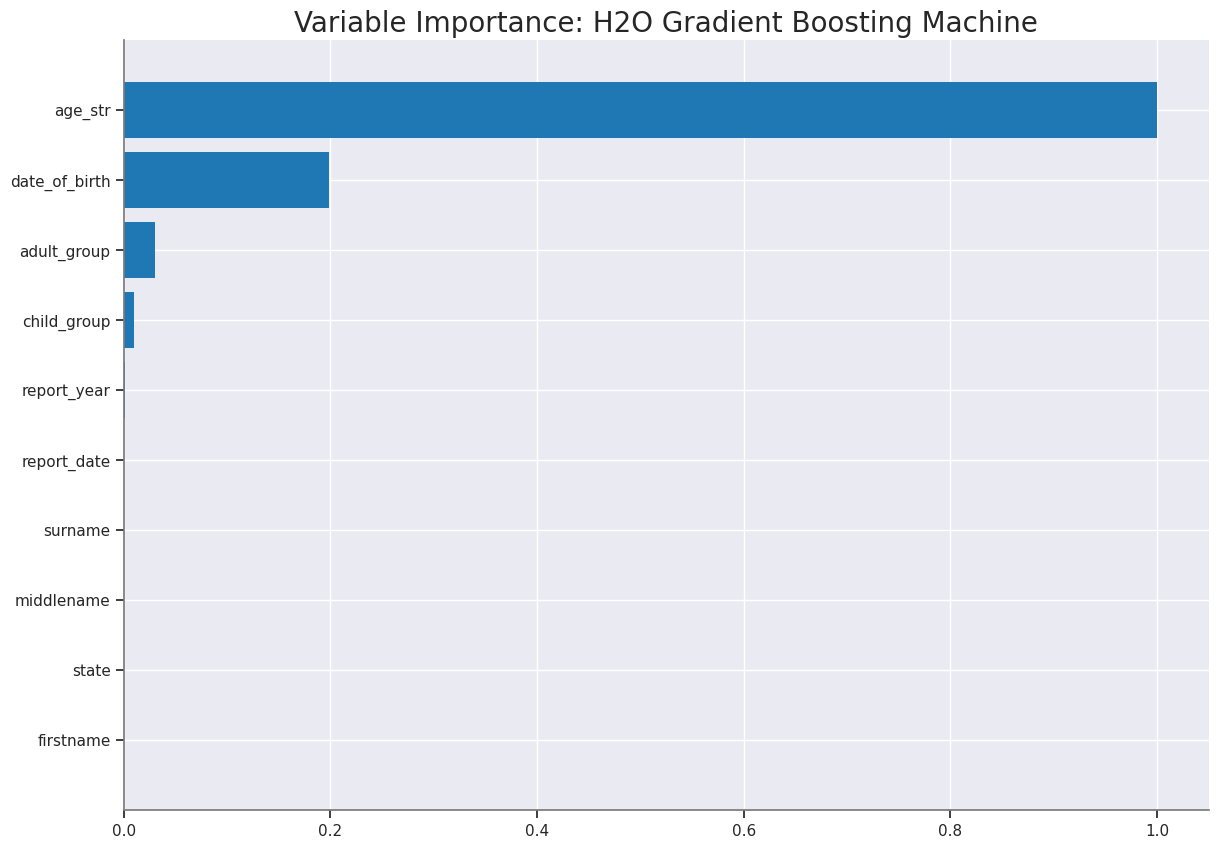

<Figure size 1600x800 with 0 Axes>

In [ ]:
if best_model.algo in [
    "gbm",
    "glm",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

7
glm


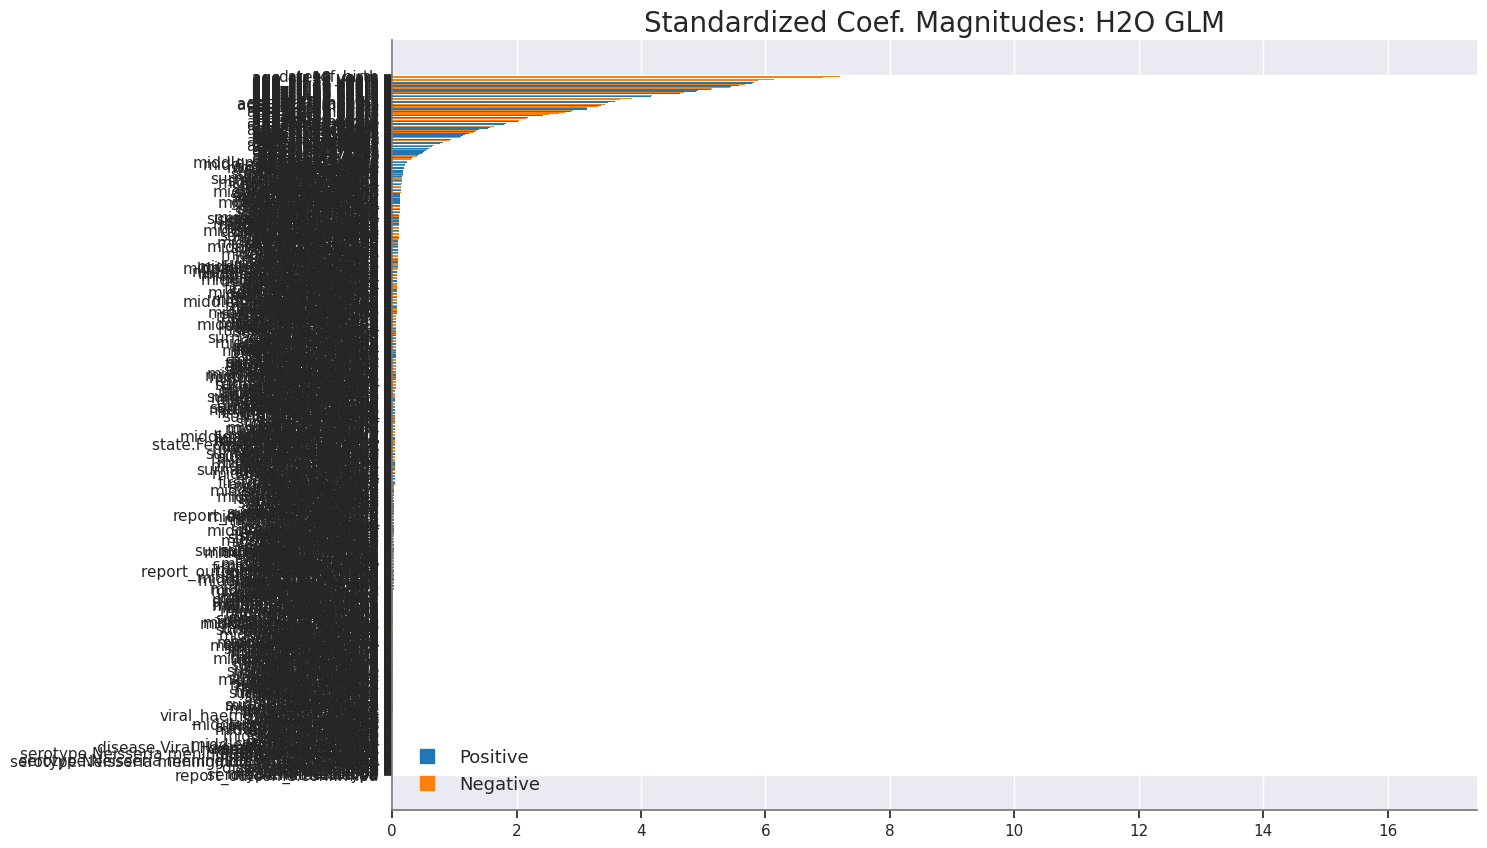

In [ ]:
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

In [ ]:
print(best_model.rmse(train=True))

0.03339138307392818


In [ ]:
def model_performance_stats(perf):
    d = {}
    try:
        d["mse"] = perf.mse()
    except:
        pass
    try:
        d["rmse"] = perf.rmse()
    except:
        pass
    try:
        d["null_degrees_of_freedom"] = perf.null_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_degrees_of_freedom"] = perf.residual_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_deviance"] = perf.residual_deviance()
    except:
        pass
    try:
        d["null_deviance"] = perf.null_deviance()
    except:
        pass
    try:
        d["aic"] = perf.aic()
    except:
        pass
    try:
        d["logloss"] = perf.logloss()
    except:
        pass
    try:
        d["auc"] = perf.auc()
    except:
        pass
    try:
        d["gini"] = perf.gini()
    except:
        pass
    return d

In [ ]:
mod_perf = best_model.model_performance(df_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 0.03309981405997084,
 'rmse': 0.1819335429764694,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [ ]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
y_pred = h2o.as_list(
    predictions
)  # Predictions on Test Dataset using the best model from the leaderboard.
print(y_pred)

         predict
0       3.035510
1      58.903686
2      59.282689
3       6.917159
4       2.179103
...          ...
56845  60.033633
56846  10.008381
56847  10.998470
56848  43.173594
56849  64.003386

[56850 rows x 1 columns]


In [ ]:
y_test = h2o.as_list(df_test[y])  # Real Answers
y_test

age
0        3
1       59
2       59
3        7
4        2
...    ...
56845   60
56846   10
56847   11
56848   43
56849   64

[56850 rows x 1 columns]

In [ ]:
print(X)

['gender_male', 'gender_female', 'rural_settlement', 'urban_settlement', 'report_year', 'age', 'child_group', 'adult_group', 'cholera', 'diarrhoea', 'measles', 'meningitis', 'yellow_fever', 'rubella_mars', 'NmA', 'NmC', 'NmW', 'alive', 'dead', 'unconfirmed', 'confirmed', 'null_serotype']


# Regularization

In this Section, we will be using the GLM model to check if regularization is helping us to improve the accuracy and reduce overfitting.

Ridge and Lasso are regularization techniques used in linear regression to prevent overfitting and improve the model's generalization ability.

Ridge regularization adds a penalty term to the least-squares objective function of the linear regression model. This penalty term is proportional to the square of the magnitude of the coefficients of the model, which shrinks the coefficients towards zero. The strength of the penalty is controlled by a hyperparameter called the regularization parameter, which needs to be tuned to achieve the best performance. Ridge regularization is particularly useful when there are many input variables that are correlated with each other, as it can help to reduce the variance of the model by reducing the effect of these correlated variables.

Lasso regularization is similar to Ridge regularization, but instead of adding a penalty term proportional to the square of the coefficients, it adds a penalty term proportional to the absolute value of the coefficients. This penalty term can set some coefficients to exactly zero, which makes Lasso regularization a useful method for feature selection. By setting some coefficients to zero, Lasso can effectively remove irrelevant variables from the model, which can lead to a simpler and more interpretable model.

The main difference between Ridge and Lasso regularization is the type of penalty function used. Ridge uses L2 regularization, while Lasso uses L1 regularization. L2 regularization tends to distribute the penalty evenly across all coefficients, while L1 regularization tends to concentrate the penalty on a smaller subset of the most important coefficients. Which method to use depends on the specific problem and the properties of the input variables.

In [ ]:
# Create an H2OGeneralizedLinearEstimator with L0 (Ridge) regularization
disease_glm = H2OGeneralizedLinearEstimator(
    family="gaussian",
    alpha=0,  # Adjust the alpha value for L1 regularization
    nfolds=5,
)

# Train the model
disease_glm.train(x=X,y=y,training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698981391730_14


GLM Model: summary
    family    link      regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Ridge ( lambda = 0.02159 )  923                           923                            1                       py_71_sid_8d5f

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 11.66809909335547
RMSE: 3.4158599346805003
MAE: 1.8191882126176107
RMSLE: NaN
Mean Residual Deviance: 11.66809909335547
R^2: 0.9764159378344992
Null degrees of freedom: 227569
Residual degrees of freedom: 226646
Null deviance: 112589141.43124795
Residual deviance: 2655309.3106749044
AIC: 1206772.9830235662

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 12.243416159320448
RMSE: 3.499059324921549
MAE: 1.9570249932374921
RMSLE: NaN
Mean Residual Deviance: 12.243416159320448
R^2: 0.9752530823136442
Null degrees of freedom: 227569
Residual degrees of freedom: 226651
Null deviance: 112589855.09474601
Residual deviance: 2786234.2153765545
AIC: 1217715.87965526

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     1.95702     0.0126763    1.96998       1.96843       1.9406        1.94837       1.95771
mean_residual_deviance  12.2434     0.401402     12.8371       12.356        11.7488       12.0594       12.2158
mse                     12.2434     0.401402     12.8371       12.356        11.7488       12.0594       12.2158
null_deviance           2.2518e+07  119953       2.25011e+07   2.25927e+07   2.23432e+07   2.2661e+07    2.24919e+07
r2                      0.975254    0.000774657  0.97413       0.975062      0.9762        0.975701      0.975176
residual_deviance       557247      18370        582099        563397        531760        550643        558335
rmse                    3.49868     0.0572223    3.58289       3.51511       3.42765       3.47266       3.49511
rmsle                   nan         0            nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  ------------------  -------------------  ------------------  ------------------
    2023-11-03 03:30:17  0.000 sec   0             112589141.43124795         494.7450957122993
    2023-11-03 03:30:17  0.658 sec   1                                                           3.4158599346805003  11.66809909335547    1.8191882126176107  0.9764159378344992

Variable Importances: 
variable              relative_importance     scaled_importance       percentage
--------------------  ----------------------  ----------------------  ----------------------
date_of_birth         19.459209442138672      1.0                     0.17739035354427035
age_str.18 years      1.7822941541671753      0.09159129303103342     0.016247411852351883
age_str.19 years      1.7766445875167847      0.09130096434799059     0.016195910344622873
age_str.20 years      1.6669487953186035      0.08566374704353852     0.015195922373980243
age_str.21 years      1.6275579929351807      0.08363947146849267     0.014836835414051829
age_str.22 years      1.5182456970214844      0.07802196186520007     0.013840343399485418
age_str.23 years      1.448846697807312       0.0744555785842899      

In [ ]:
df_train.head()

id  surname    firstname    middlename    gender      gender_male    gender_female  state    settlement      rural_settlement    urban_settlement  report_date            report_year    age  age_str    date_of_birth          child_group    adult_group  disease          cholera    diarrhoea    measles    viral_haemmorrhaphic_fever    meningitis    ebola    marburg_virus    yellow_fever    rubella_mars    malaria  serotype         NmA    NmC    NmW  health_status      alive    dead  report_outcome      unconfirmed    confirmed    null_serotype
----  ---------  -----------  ------------  --------  -------------  ---------------  -------  ------------  ------------------  ------------------  -------------------  -------------  -----  ---------  -------------------  -------------  -------------  -------------  ---------  -----------  ---------  ----------------------------  ------------  -------  ---------------  --------------  --------------  ---------  -------------  -----  -----  -----  ---------------  -------  ------  ----------------  -------------  -----------  ---------------
   1  Solade     Grace        Solape        Female                0                1  Rivers   Rural                          1                   0  2018-05-15 00:00:00           2018     32  32 years   1986-01-17 00:00:00              0              1  Cholera                1            0          0                             0             0        0                0               0               0          0  null serotype      0      0      0  alive                  1       0  confirmed                     0            1                1
   2  Eneche     Kure         Balogun       Male                  1                0  Ebonyi   Rural                          1                   0  2017-02-28 00:00:00           2017     32  32 years   1985-09-01 00:00:00              0              1  Marburg Virus          0            0          0                             0             0        0                1               0               0          0  Null               0      0      1  Alive                  1       0  Confirmed                     1            0                1
   3  Sanusi     Adaugo       Katerine      Female                0                1  Ogun     Urban                          0                   1  2012-03-02 00:00:00           2012     24  24 years   1988-05-01 00:00:00              0              1  Marburg Virus          0            0          0                             0             0        0                1               0               0          0  Null               0      0      1  Dead                   0       1  Not Confirmed                 1            0                1
   4  Sowore     Mooslemat    Ifedayo       Female                0                1  Ondo     Rural                          1                   0  2010-05-21 00:00:00           2010     63  63 years   1947-05-24 00:00:00              0              1  Measles                0            0          1                             0             0        0                0               0               0          0  Null               0      0      1  Alive                  1       0  Not Confirmed                 1            0                1
   5  Abdusalam  Yusuf        Okafor        Male                  1                0  Oyo      Urban                          0                   1  2017-08-28 00:00:00           2017      9  9 years    2008-01-07 00:00:00              1              0  Rubella Mars           0            0          0                             0             0        0                0               0               1          0  Null               0      0      1  Alive                  1       0  Confirmed                     1            0                1
   6  Yakubu     Janet        Chioma        Female                0                1  Kaduna   Rural                          1                   0  2012-06-27

This code is creating two generalized linear regression models using the H2O machine learning platform with different regularization methods: Ridge and Lasso.

The first model, "disease_glm_regularization_ridge," is using Ridge regularization. The "family" argument is set to "gaussian," which means that the response variable is continuous and the model is using a normal (Gaussian) error distribution. The "alpha" argument is set to 0, which means that the model is using Ridge regularization. The "nfolds" argument is set to 5, which means that the model is using 5-fold cross-validation to evaluate the performance of the model.

The second model, "disease_glm_regularization_lasso," is using Lasso regularization. The "family" and "nfolds" arguments are the same as in the Ridge model, but the "alpha" argument is set to 1, which means that the model is using Lasso regularization.

This code creates a generalized linear regression model using H2O with the option of performing lambda search for L1 and L2 regularization.

# Lasso Regularization

In [ ]:
# Create an H2OGeneralizedLinearEstimator with L1 (Lasso) regularization
model_lasso = H2OGeneralizedLinearEstimator(
    family="Gaussian",
    alpha=1,  # Adjust the alpha value for L1 regularization
    nfolds=5
)

# Train the model
model_lasso.train(x=X,y=y,training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698981391730_15


GLM Model: summary
    family    link      regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Lasso (lambda = 0.02159 )  923                           27                             1                       py_71_sid_8d5f

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 12.502423310431812
RMSE: 3.5358765971724484
MAE: 1.5537773407181767
RMSLE: NaN
Mean Residual Deviance: 12.502423310431812
R^2: 0.974729565954703
Null degrees of freedom: 227569
Residual degrees of freedom: 227542
Null deviance: 112589141.43124795
Residual deviance: 2845176.4727549674
AIC: 1220697.8651325074

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 13.055011079114854
RMSE: 3.61317188618461
MAE: 1.6499253677787484
RMSLE: NaN
Mean Residual Deviance: 13.055011079114854
R^2: 0.9736126518640489
Null degrees of freedom: 227569
Residual degrees of freedom: 227553
Null deviance: 112589341.69948031
Residual deviance: 2970928.871274167
AIC: 1230518.1676033074

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     1.64991      0.0106174    1.66344       1.65602       1.63794       1.64069       1.65146
mean_residual_deviance  13.0546      0.445027     13.2671       13.6365       12.4757       12.7887       13.1051
mse                     13.0546      0.445027     13.2671       13.6365       12.4757       12.7887       13.1051
null_deviance           2.25179e+07  55200.5      2.254e+07     2.25448e+07   2.25056e+07   2.24282e+07   2.25707e+07
r2                      0.973614     0.000894932  0.973184      0.972451      0.974761      0.97419       0.973481
residual_deviance       594186       21017.5      604423        621087        568016        578866        598536
rmse                    3.61269      0.061609     3.6424        3.69276       3.53209       3.57612       3.6201
rmsle                   nan          0            nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  ------------------  -------------------  ------------------  -----------------
    2023-11-03 03:30:52  0.000 sec   0             112589141.43124795         494.7450957122993
    2023-11-03 03:30:52  0.165 sec   1                                                           3.5358765971724484  12.502423310431812   1.5537773407181767  0.974729565954703

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
date_of_birth      21.687040328979492     1.0                  0.4266771892192544
age_str.7 months   4.026859760284424      0.18568046626922616  0.079225619440674
age_str.8 months   3.7352919578552246     0.17223613278681965  0.07348922901947448
age_str.9 months   3.584887981414795      0.16530093212509306  0.07053013709445746
age_str.6 months   3.203547477722168      0.14771713563152278  0.0630275322307775
age_str.5 months   2.8901612758636475     0.13326674511697406  0.05686188022290929
report_year        2.465162515640259      0.11366984513539934  0.04850033002136013
age_str.4 months   2.2327826023101807     0.10295

# Which Regularization Method Helps ?
The Lasso regularization appears to have increased the MSE, RMSE, MAE, and RMSLE values compared to the non-regularized and Ridge regularized models, indicating worse performance. The R-squared value also decreased, indicating a worse fit to the data.

Both the regularization methods have not helped increase the performance. It can be concluded that Ridge regularization helps us avoid the overfitting of model and improvements of metrics on the validation dataset but hasn't helped us.

 However, it's always a good practice to try multiple regularization techniques and compare their performance using different metrics, as the optimal regularization method can depend on the specific dataset and modeling task.

In [ ]:
disease_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)  # Lambda Search

lambda_search = disease_glm_regularization_lamba_search.train(
    x=X, y=y, training_frame=df_train
)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698981391730_16


GLM Model: summary
    family    link      regularization                                 lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.004318 )  nlambda = 100, lambda.max = 43.181, lambda.min = 0.004318, lambda.1se = -1.0  923                           108                            100                     py_71_sid_8d5f

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 6.925259089081212
RMSE: 2.6315887005915672
MAE: 0.9725816066352031
RMSLE: NaN
Mean Residual Deviance: 6.925259089081212
R^2: 0.9860023694037618
Null degrees of freedom: 227569
Residual degrees of freedom: 227461
Null deviance: 112589141.43124795
Residual deviance: 1575981.2109022115
AIC: 1086423.564563555

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      alpha    iterations    training_rmse       training_deviance    training_mae        training_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  -------  ------------  ------------------  -------------------  ------------------  ------------------
     2023-11-03 03:34:48  0.000 sec   1            .43E2     1             494.7450957122972   0.5
     2023-11-03 03:34:48  0.077 sec   2            .39E2     2             490.7437491075293   0.5
     2023-11-03 03:34:48  0.155 sec   3            .36E2     2             486.4102548586928   0.5
     2023-11-03 03:34:48  0.193 sec   4            .33E2     4             479.4473556424872   0.5
     2023-11-03 03:34:48  0.244 sec   5            .3E2      4             469.12716878927847  0.5
     2023-11-03 03:34:48  0.280 sec   6            .27E2     4             458.2625633446182   0.5
     2023-11-03 03:34:48  0.315 sec   7            .25E2     4             446.86291858581023  0.5
     2023-11-03 03:34:48  0.351 sec   8            .23E2     4             434.9445858266581   0.5
     2023-11-03 03:34:48  0.388 sec   9            .21E2     4             422.5293676609091   0.5
     2023-11-03 03:34:48  0.437 sec   10           .19E2     4             409.6488527092887   0.5
---  ---                  ---         ---          ---       ---           ---                 ---      ---           ---                 ---                  ---                 ---
     2023-11-03 03:34:53  5.130 sec   91           .1E-1     94            9.491322675130329   0.5
     2023-11-03 03:34:53  5.250 sec   92           .91E-2    96            9.214584336725245   0.5
     2023-11-03 03:34:53  5.352 sec   93           .83E-2    96            8.937139150880471   0.5
     2023-11-03 03:34:53  5.443 sec   94           .75E-2    99            8.65839972587966    0.5
     2023-11-03 03:34:53  5.528 sec   95           .69E-2    102           8.37734413539116    0.5
     2023-11-03 03:34:53  5.648 sec   96           .63E-2    105           8.093155734216715   0.5
     2023-11-03 03:34:53  5.684 sec   97           .57E-2    105           7.807221492675118   0.5
     2023-11-03 03:34:53  5.784 sec   98           .52E-2    110           7.515621840895681   0.5
     2023-11-03 03:34:53  5.889 sec   99           .47E-2    110           7.220830327937163   0.5
     2023-11-03 03:34:54  5.994 sec   100          .43E-2    109           6.9252590890775565  0.5      100           2.6315887005915672  6.925259089081212    0.9725816066352031  0.9860023694037618
[100 rows x 13 columns]


Variable Importances: 
var

Above parameters are from a lambda search, which means that the model was trained on a range of different values of the regularization parameter lambda to find the value that minimized the selected loss function. Based on the reported metrics, it seems that the optimal value of lambda resulted in a slightly improved model compared to the non-regularized model. The MSE, RMSE, and MAE all decreased slightly, indicating that the model is making slightly more accurate predictions on the training data. The R^2 value, which measures how well the model fits the data, decreased slightly, which may indicate that the model is not overfitting the training data as much. Overall, the lambda search seems to have resulted in a slightly improved model in comparison to ridge regularized and Lasso.

Data Report

In [ ]:
coeff_table = disease_glm._model_json["output"]["coefficients_table"]

In [ ]:
coeff_table.as_data_frame()  # Z-Value and P-Value showing the significance of each attributes.

names  coefficients  standardized_coefficients
0             Intercept   -985.340625                  34.858327
1        surname.Abacha      0.015171                   0.015171
2    surname.Abdukareem      0.024802                   0.024802
3      surname.Abdulahi     -0.004207                  -0.004207
4    surname.Abdulkabir      0.011543                   0.011543
..                  ...           ...                        ...
919               alive      0.000433                   0.000217
920                dead     -0.000433                  -0.000217
921         unconfirmed      0.006854                   0.002966
922           confirmed     -0.006854                  -0.002966
923       null_serotype      0.020419                   0.006125

[924 rows x 3 columns]

In [ ]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =X,
               y               =y,
               training_frame  =df_train
               )

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1698981391730_17


GLM Model: summary
    family    link      regularization                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.04318 )  923                           54                             2                       py_71_sid_8d5f

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 13.678262243033817
RMSE: 3.6984134764833714
MAE: 2.12347571675225
RMSLE: NaN
Mean Residual Deviance: 13.678262243033817
R^2: 0.9723529098892009
Null degrees of freedom: 227569
Residual degrees of freedom: 227515
Null deviance: 112589141.43124795
Residual deviance: 3112762.1386472057
AIC: 1241207.0821409975

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse       training_deviance    training_mae      training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  ------------------  -------------------  ----------------  ------------------
    2023-11-03 03:38:36  0.000 sec   0             112589141.43124795         494.7450957122993
    2023-11-03 03:38:36  0.715 sec   2                                                           3.6984134764833714  13.678262243033817   2.12347571675225  0.9723529098892009

Variable Importances: 
variable          relative_importance    scaled_importance     percentage
----------------  ---------------------  --------------------  --------------------
date_of_birth     20.201217651367188     1.0                   0.49042689210559565
report_year       1.4691334962844849     0.072724997158033     0.0356662943346024
report_date       0.8419461846351624     0.041677991850069526  0.020440008012231944
age_str.19 years  0.8223727941513062     0.040709070529500936  0.01996482294029064
age_str.18 years  0.8150407671928406     0.04034612077642161   0.01978682262089745
child_group       0.768735945224762      0.03805394102927925   0.018662676031359033
adult_group       0.768735945224762      0.03805394102927925   0.018662676031359033
age_str.20 years  0.7230674624443054     0.03579326132330292   0.017553977909110872
age_str.21 years  0.69649338722229       0.03447779234115387   0.016908836544534202
age_str.7 months  0.6883971691131592     0.03407701362331342   0.016712283883521643
---               ---                    ---                   ---
rubella_mars      0.0                    0.0                   0.0
malaria           0.0                    0.0                   0.0
NmA               0.0                    0.0                   0.0
NmC               0.0                    0.0                   0.0
NmW               0.0                    0.0                   0.0
alive             0.0                    0.0                   0.0
dead              0.0                    0.0                   0.0
unconfirmed       0.0                    0.0                   0.0
confirmed         0.0                    0.0                   0.0
null_serotype     0.0                    0.0                   0.0
[923 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

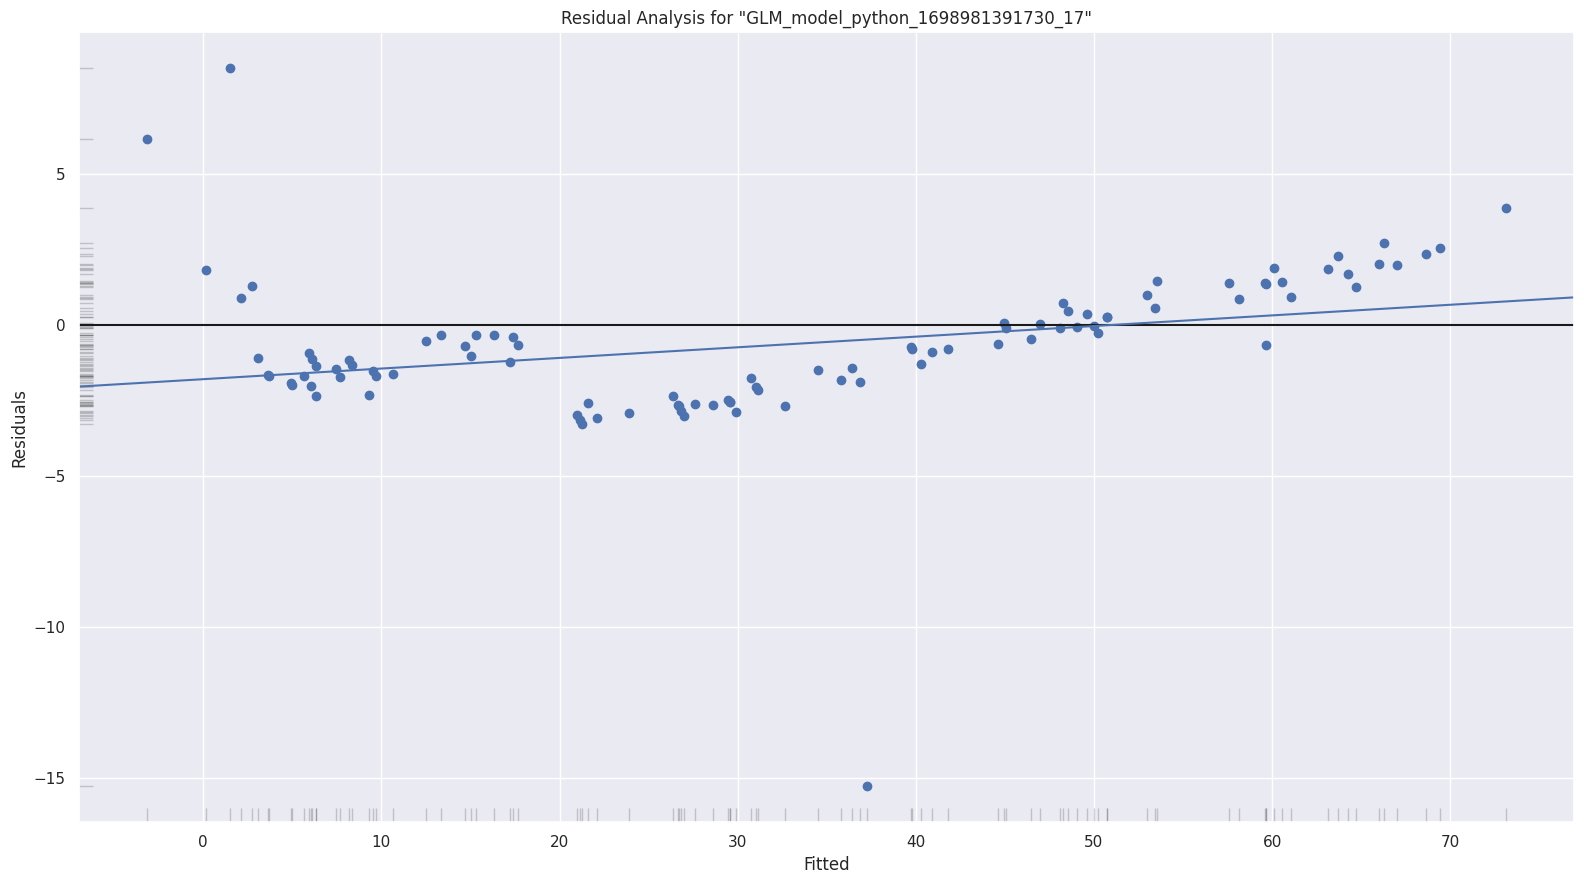

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

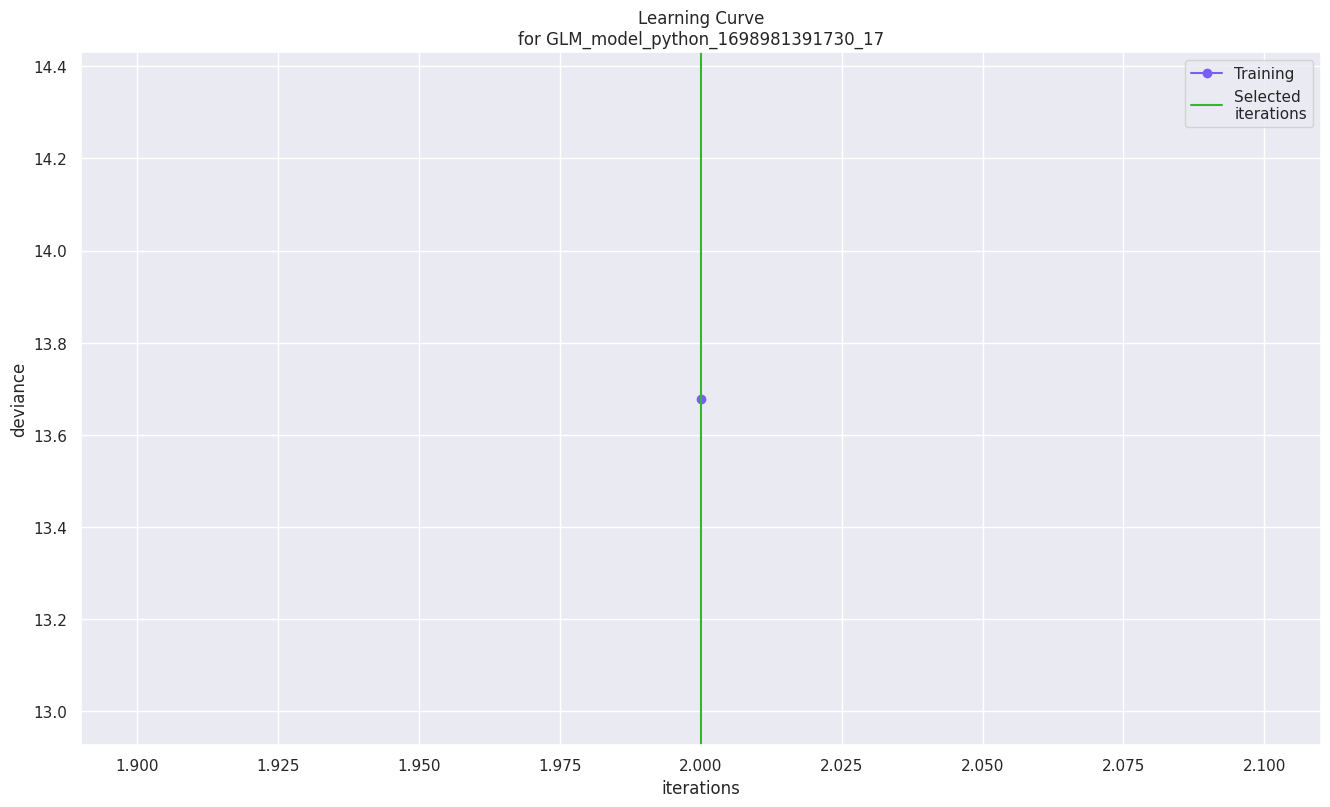

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

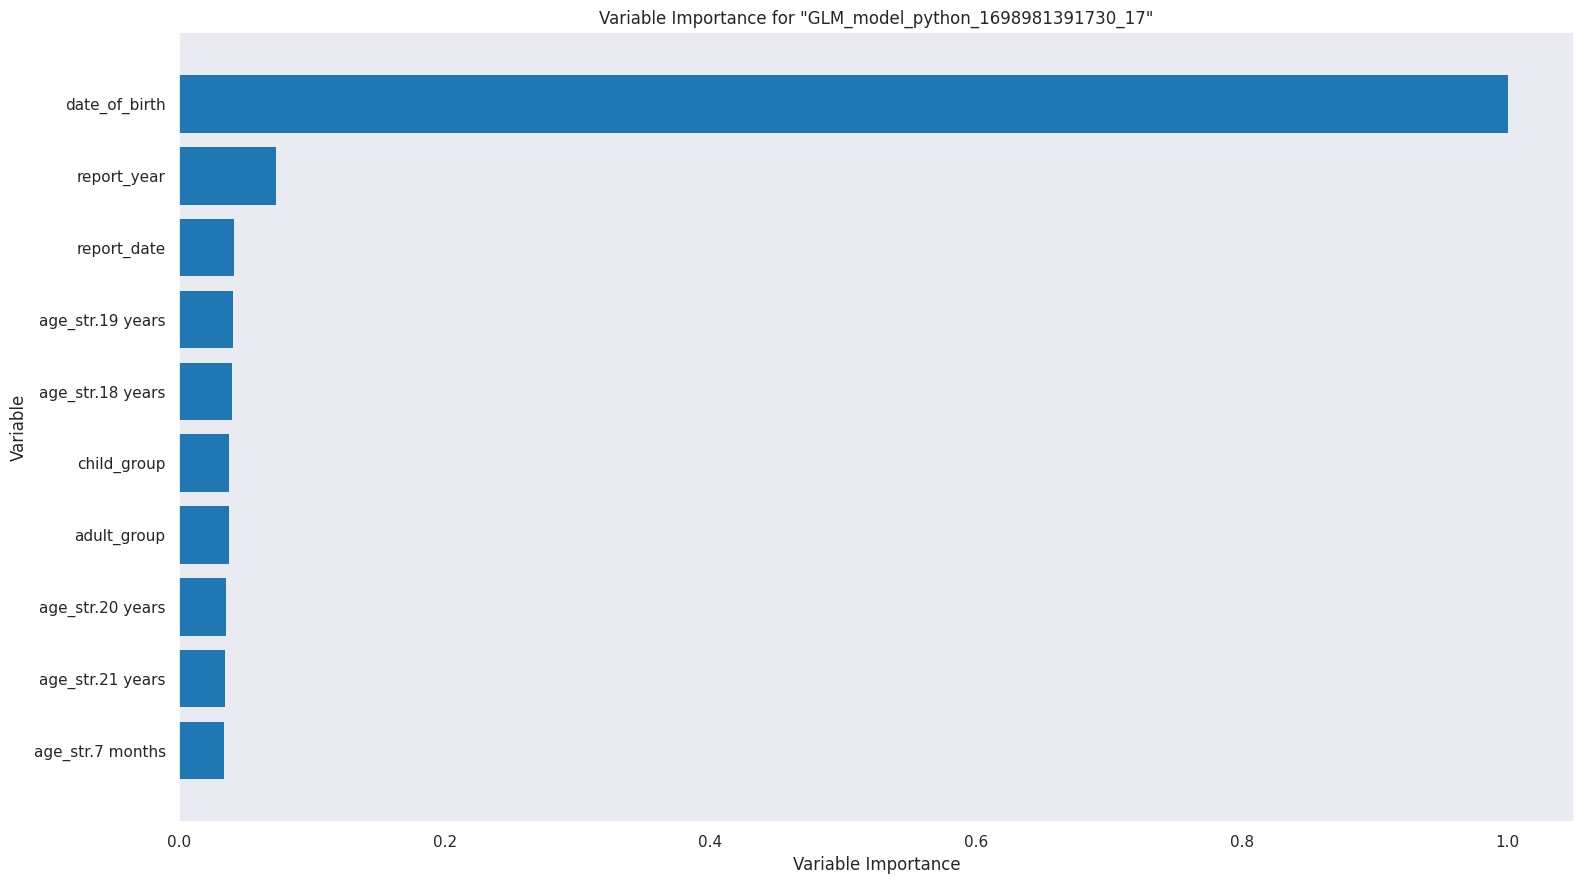

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

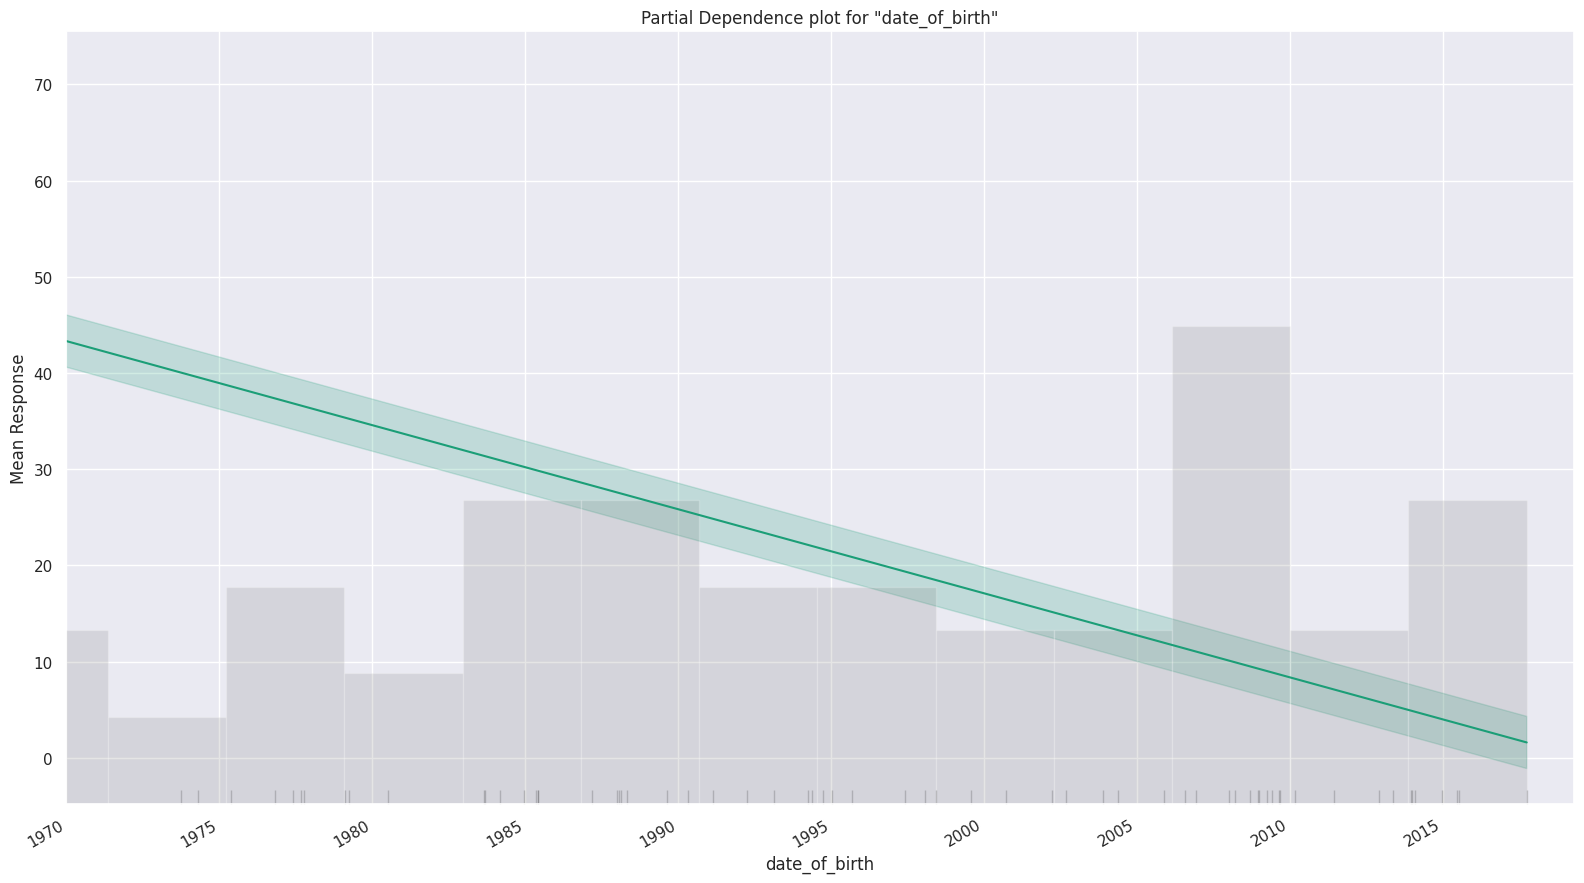

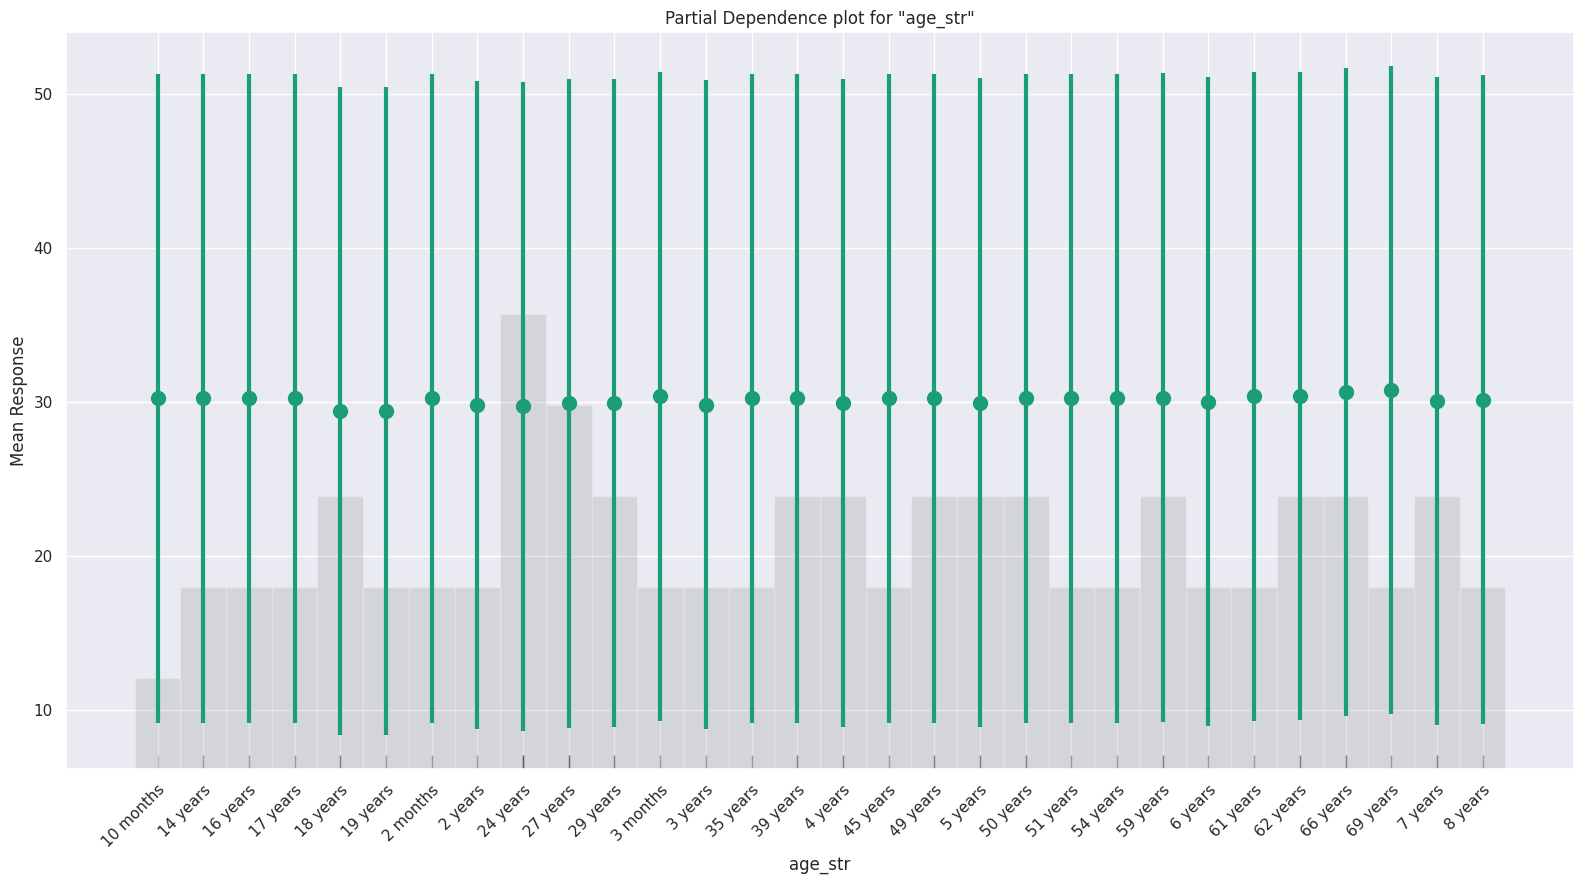

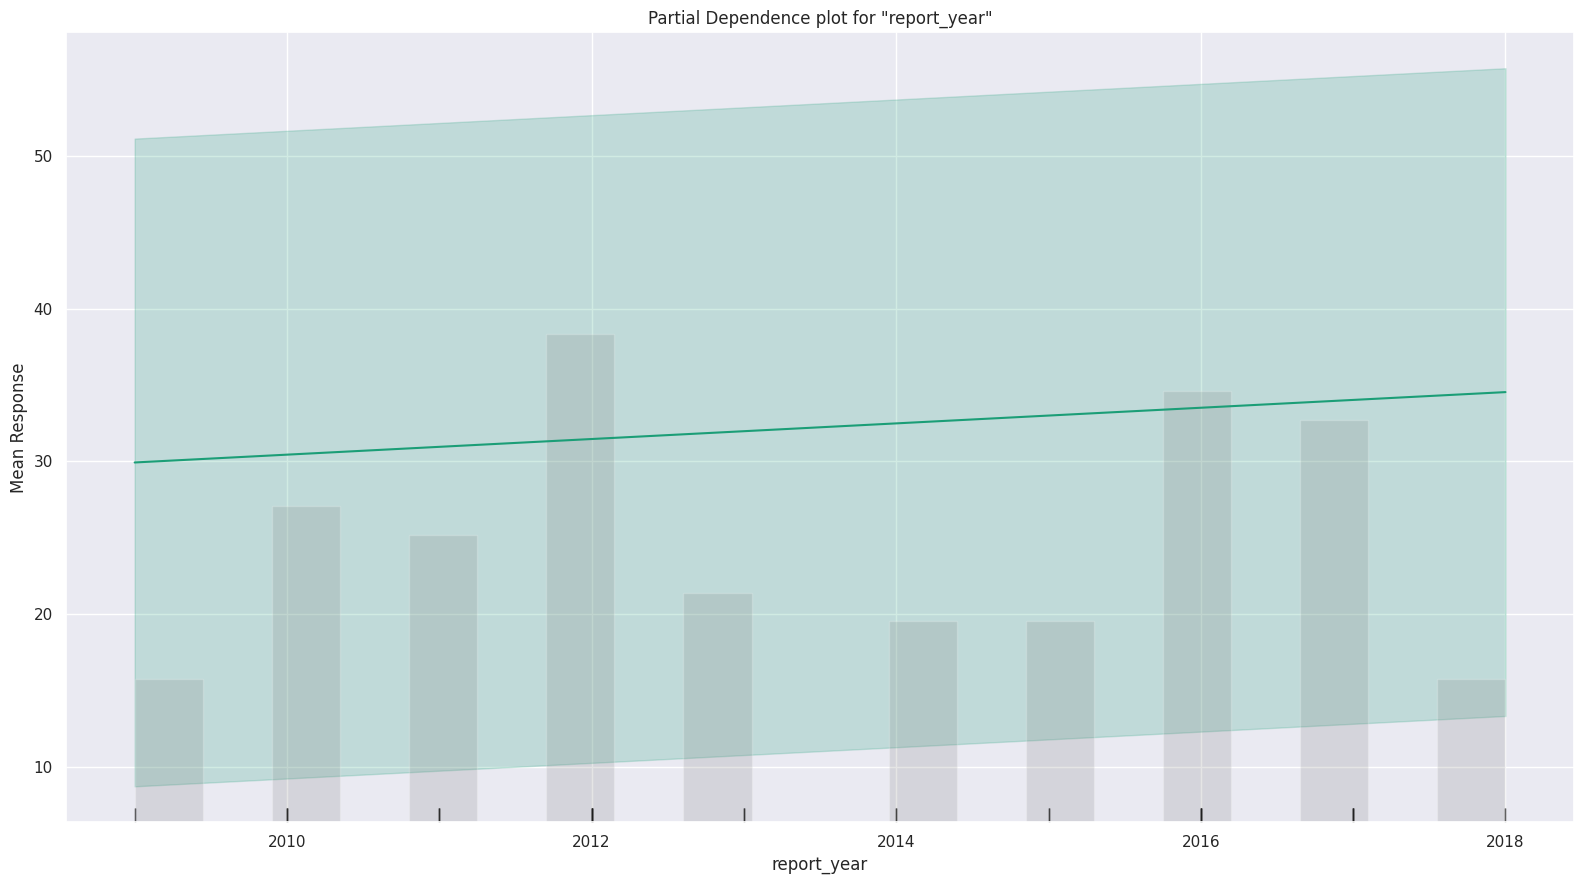

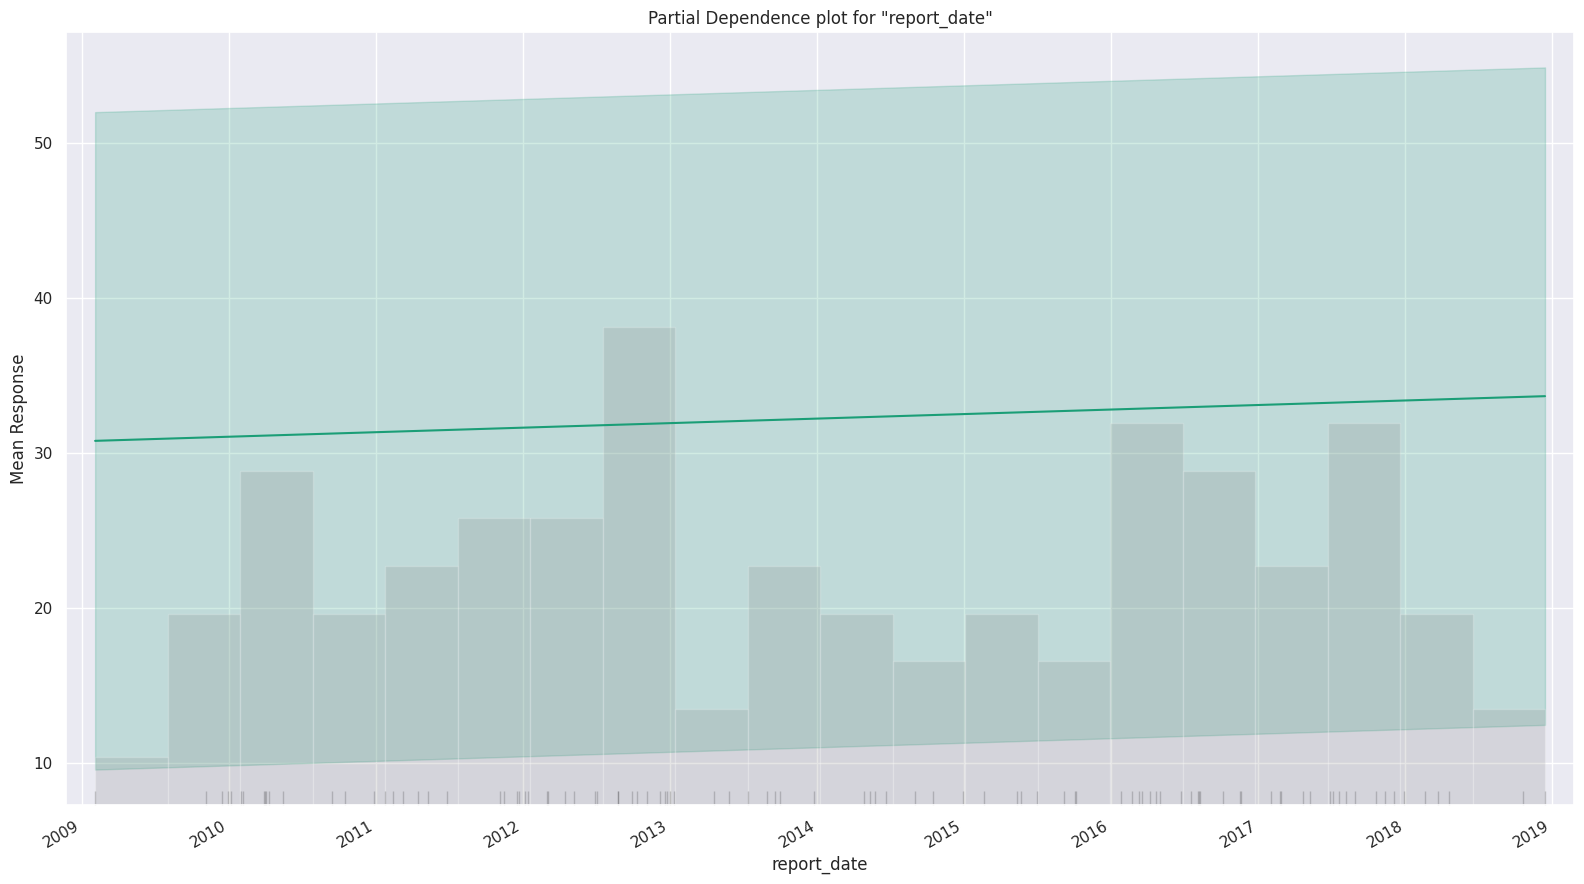

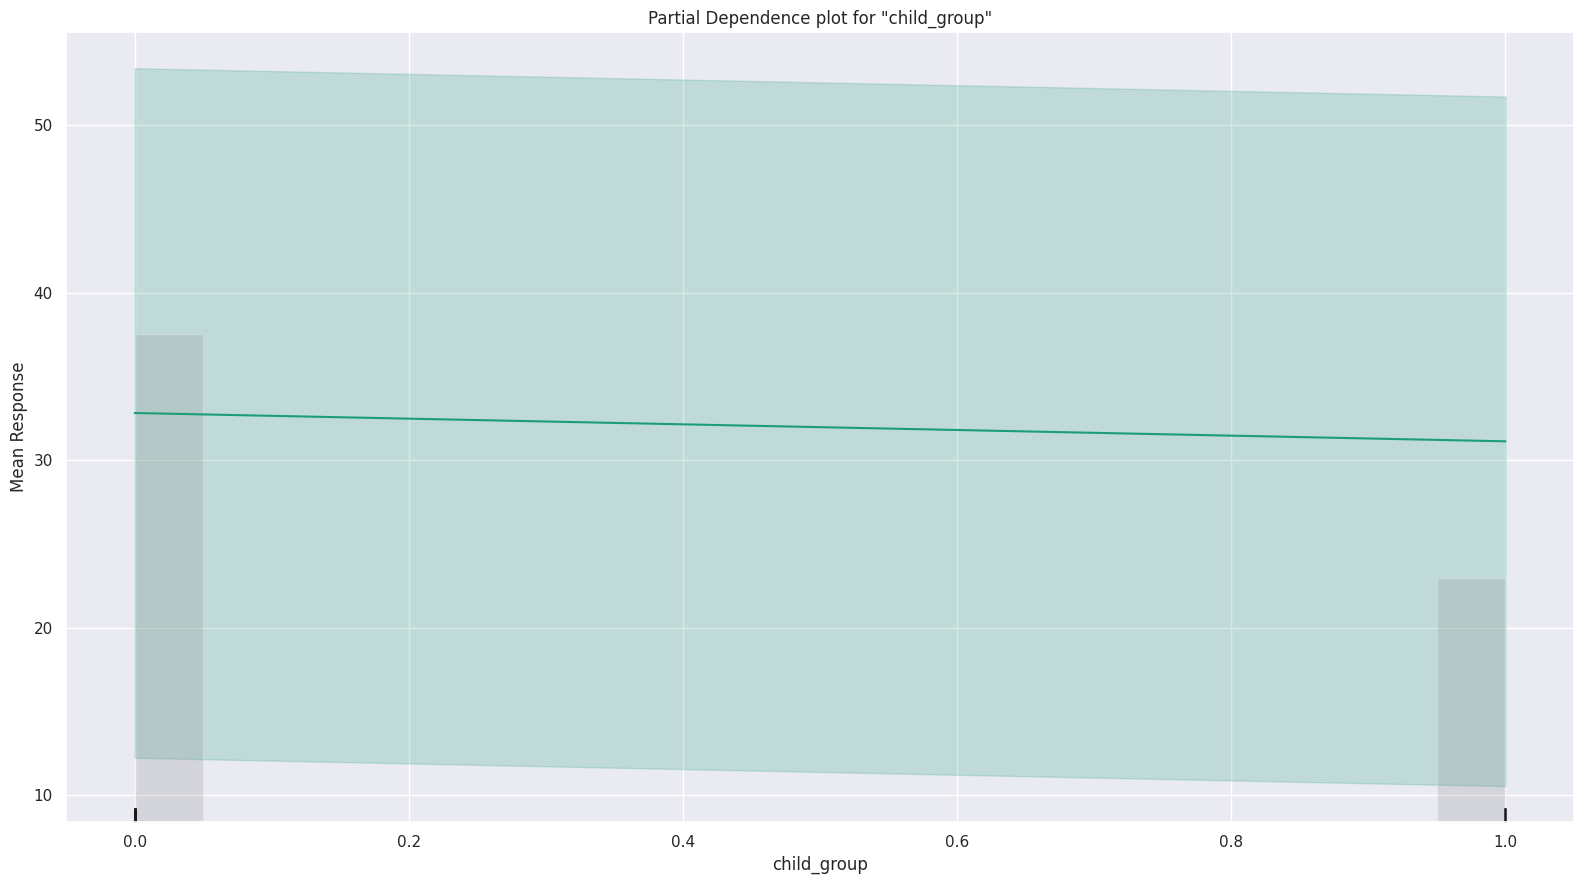

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

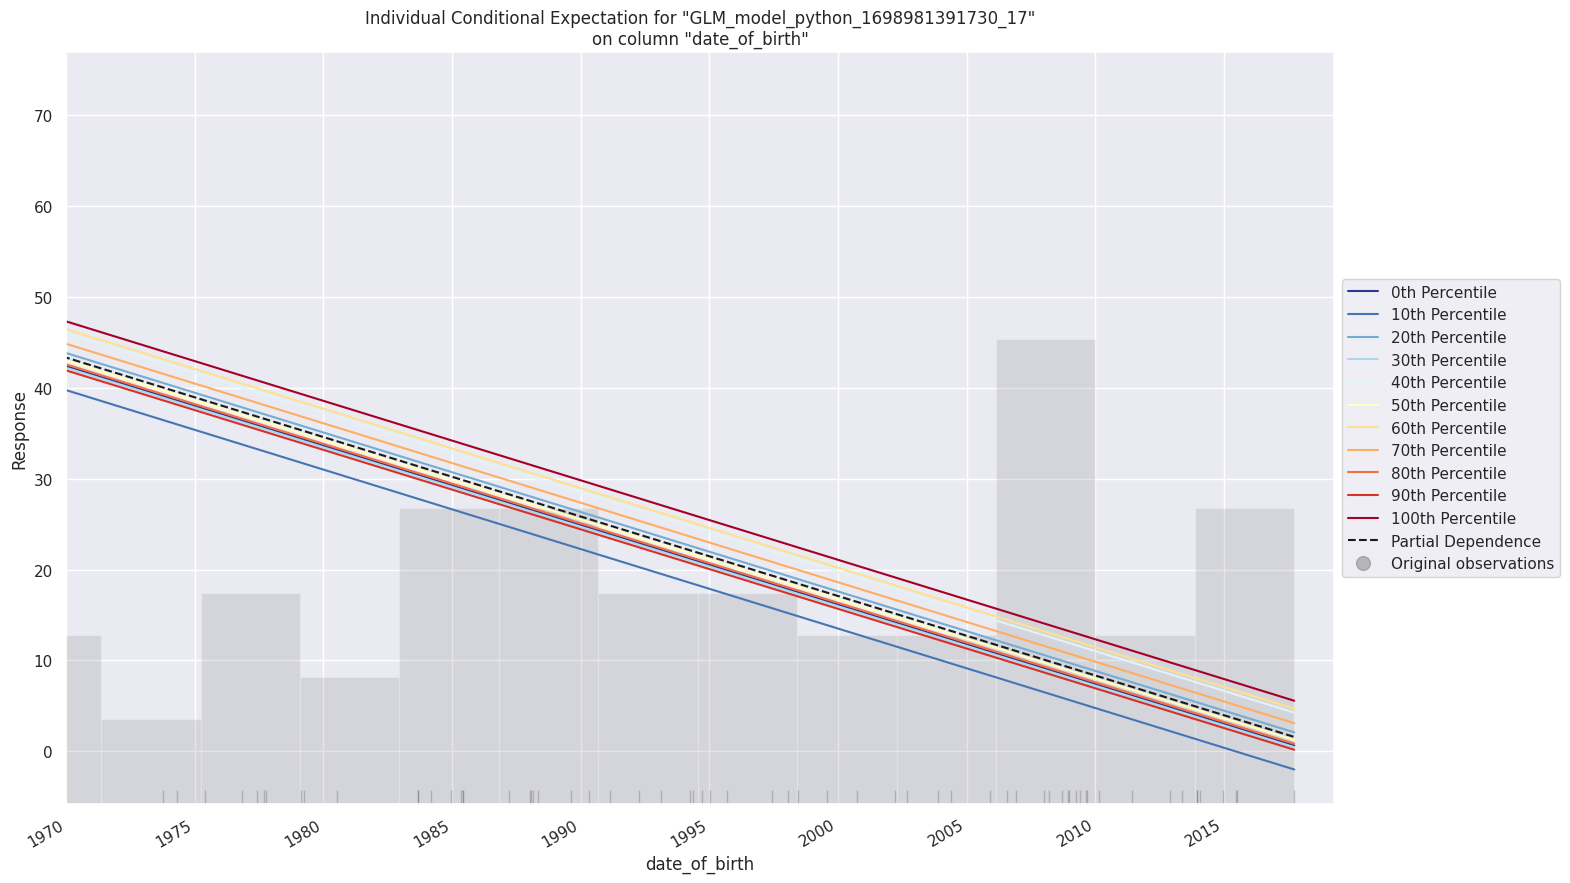

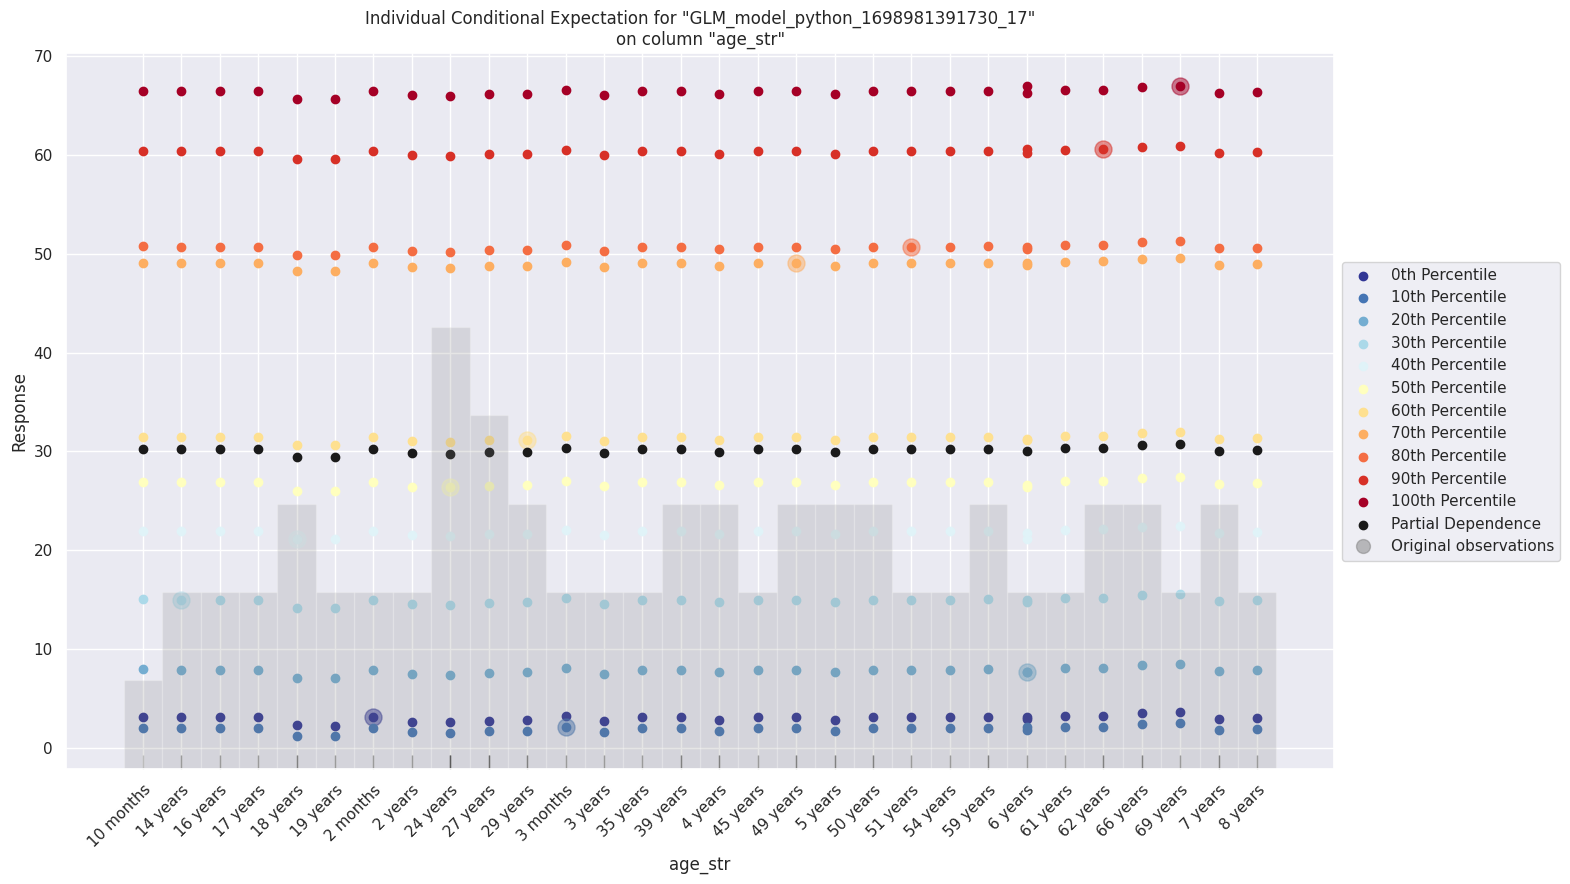

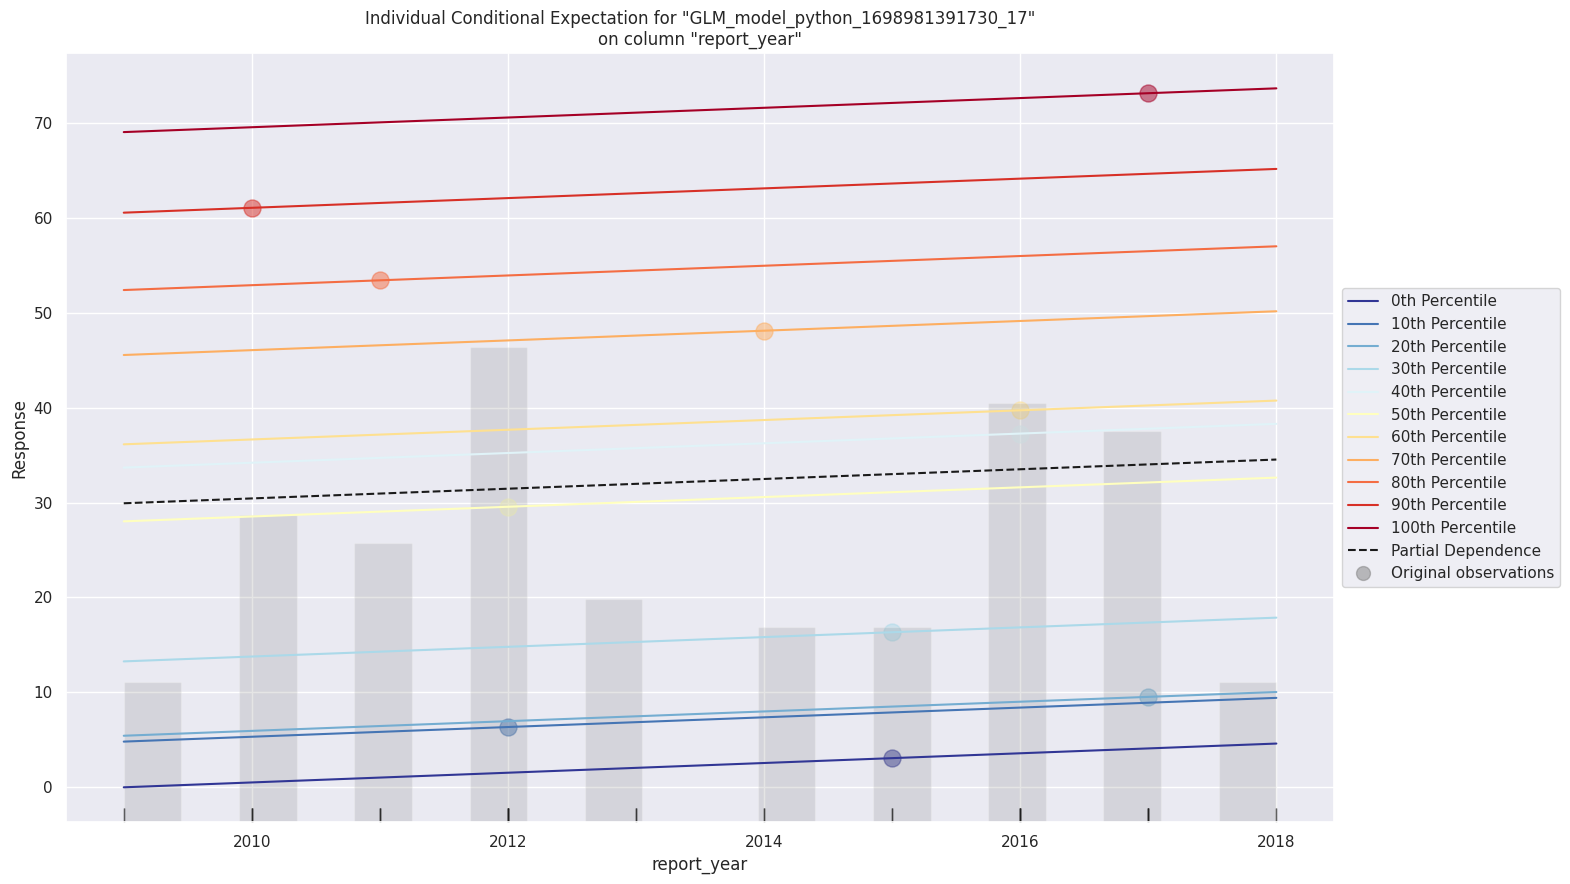

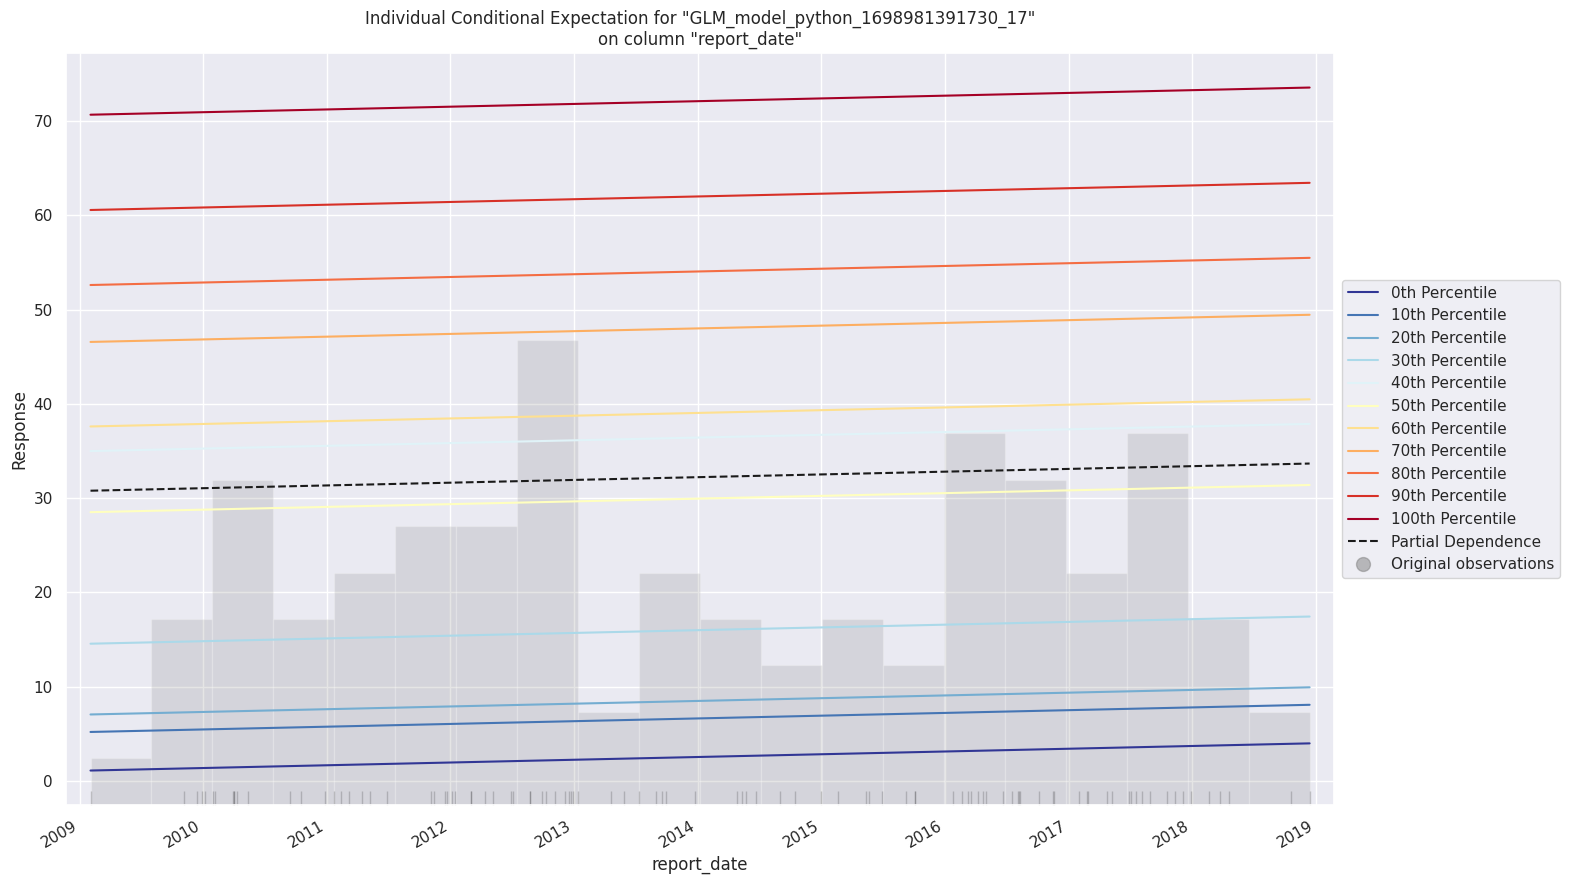

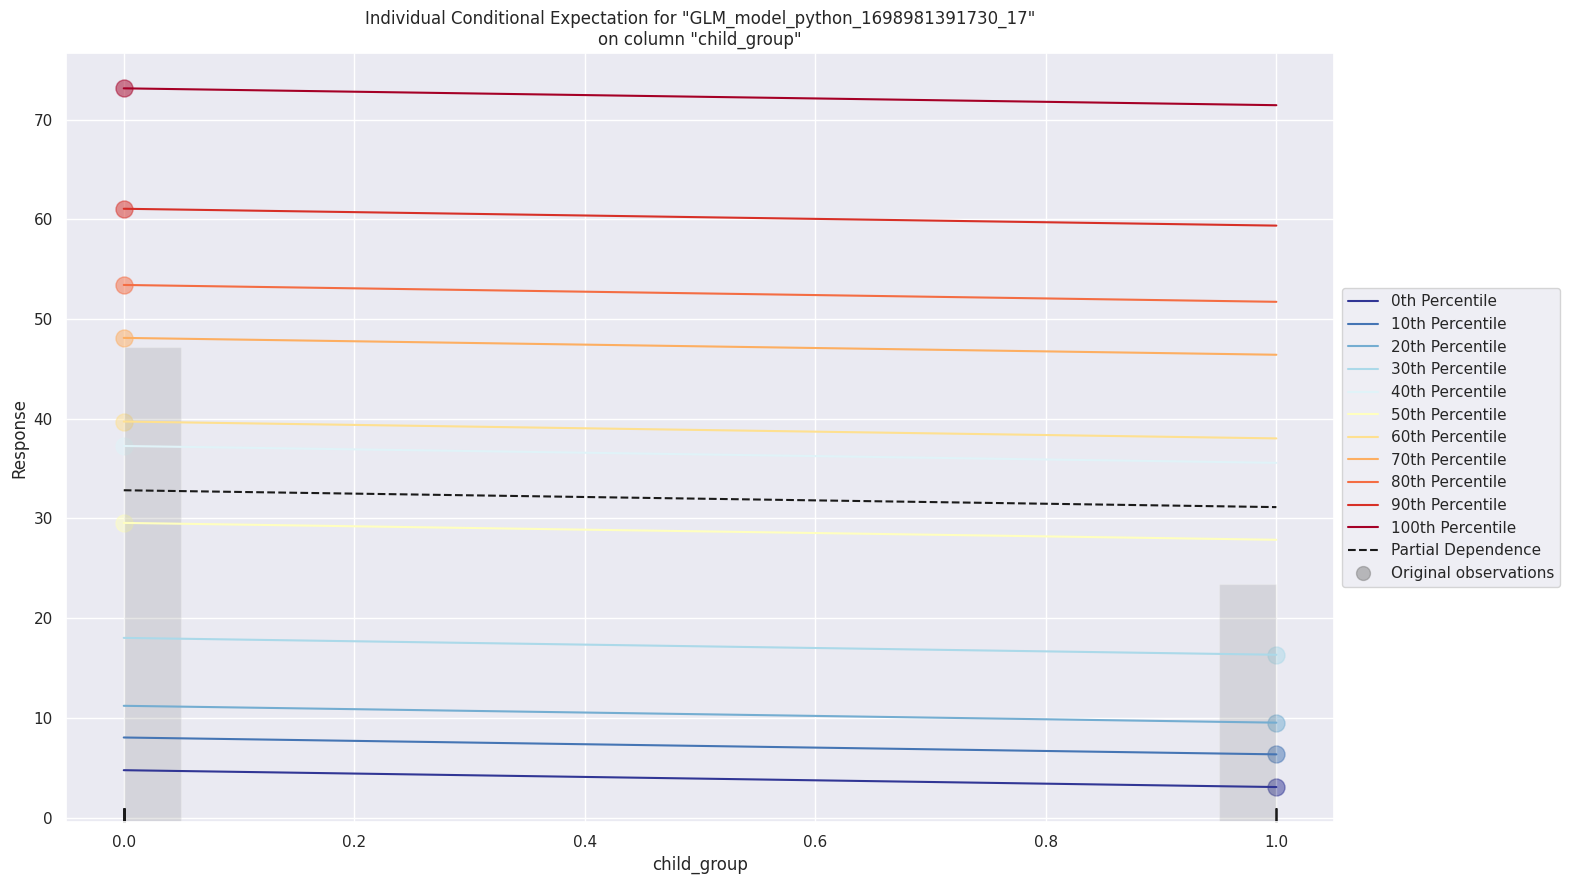

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

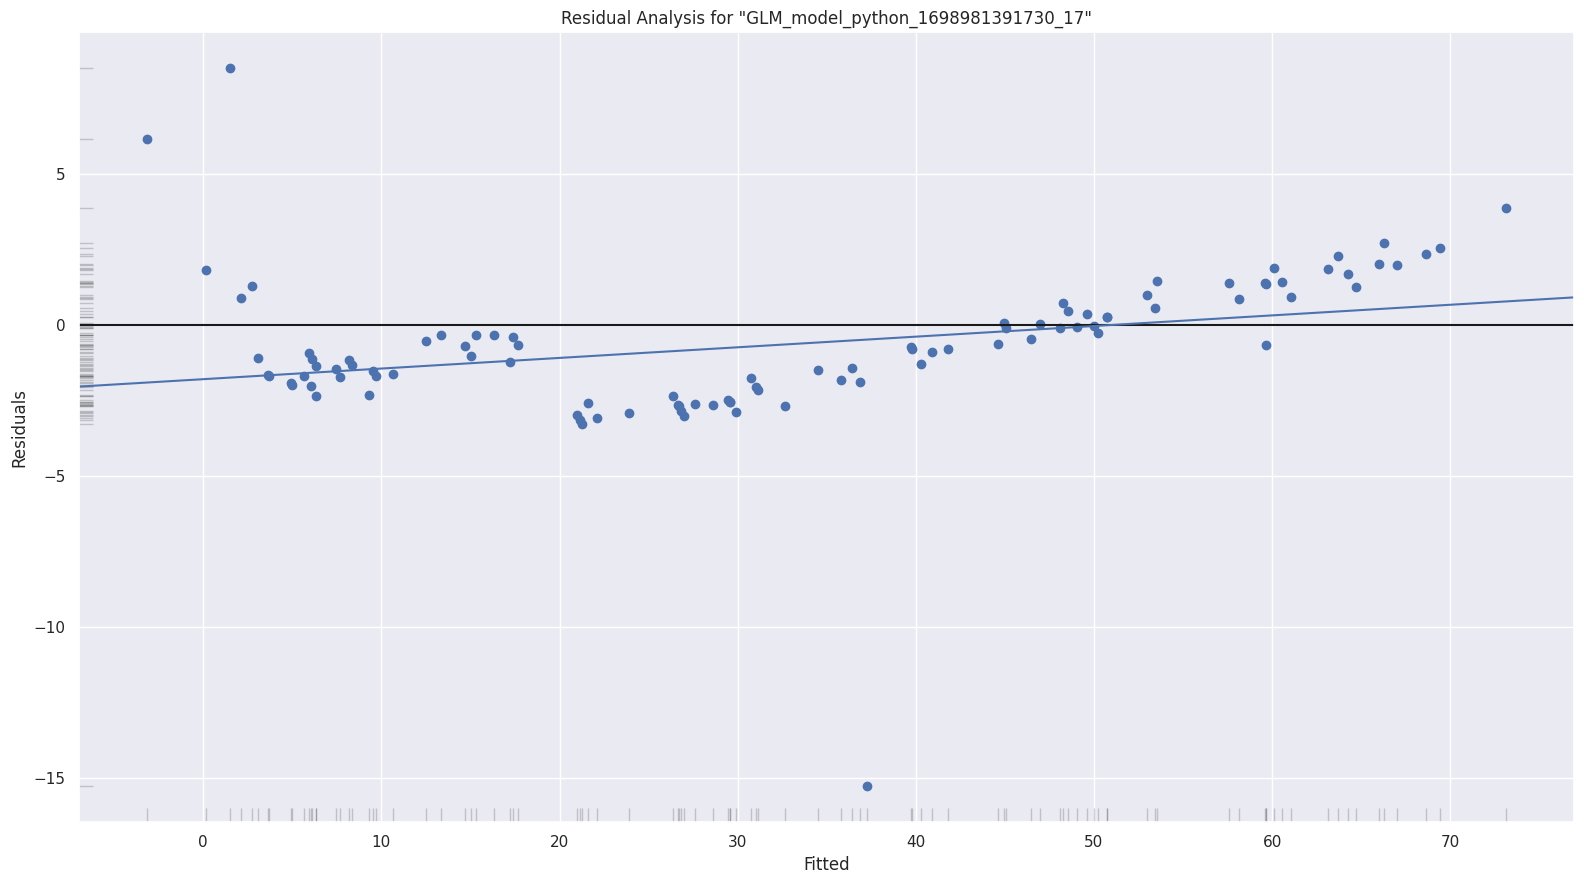

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

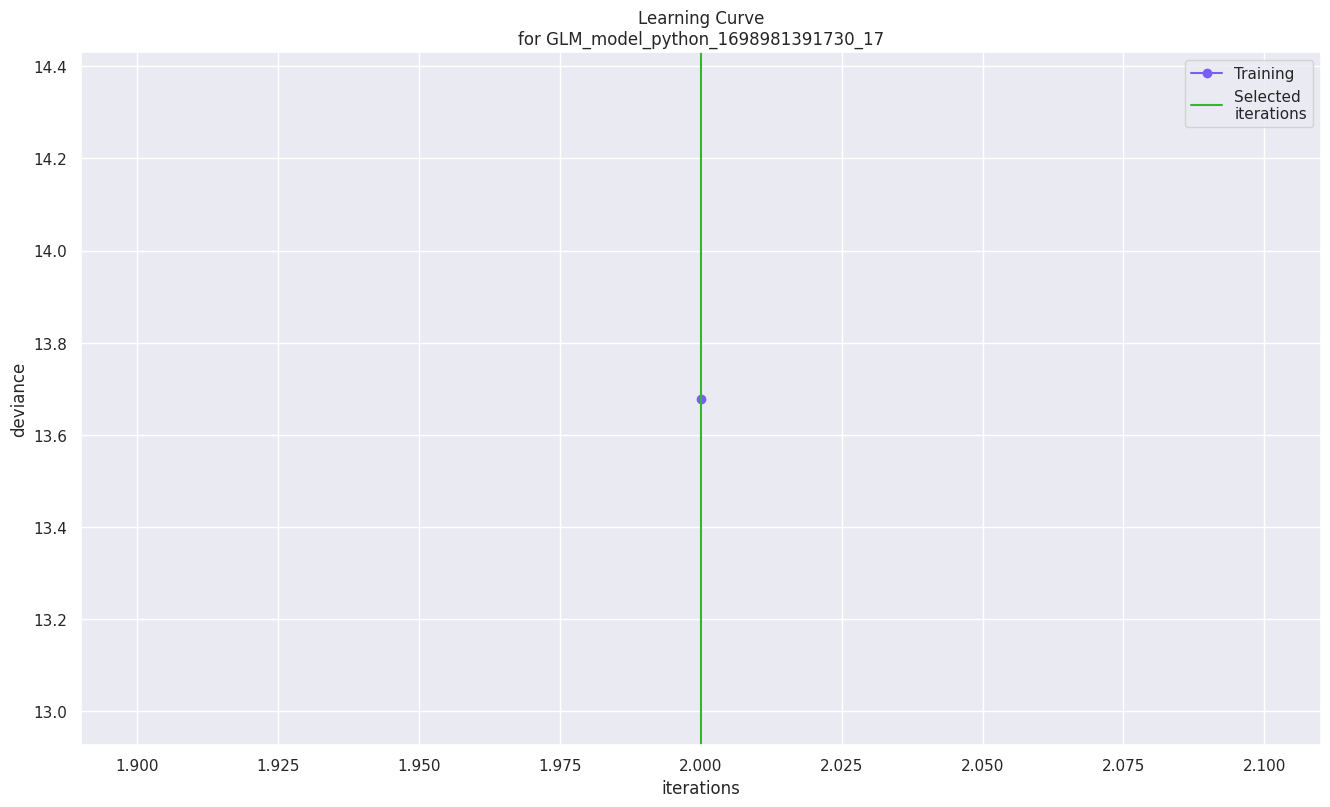

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

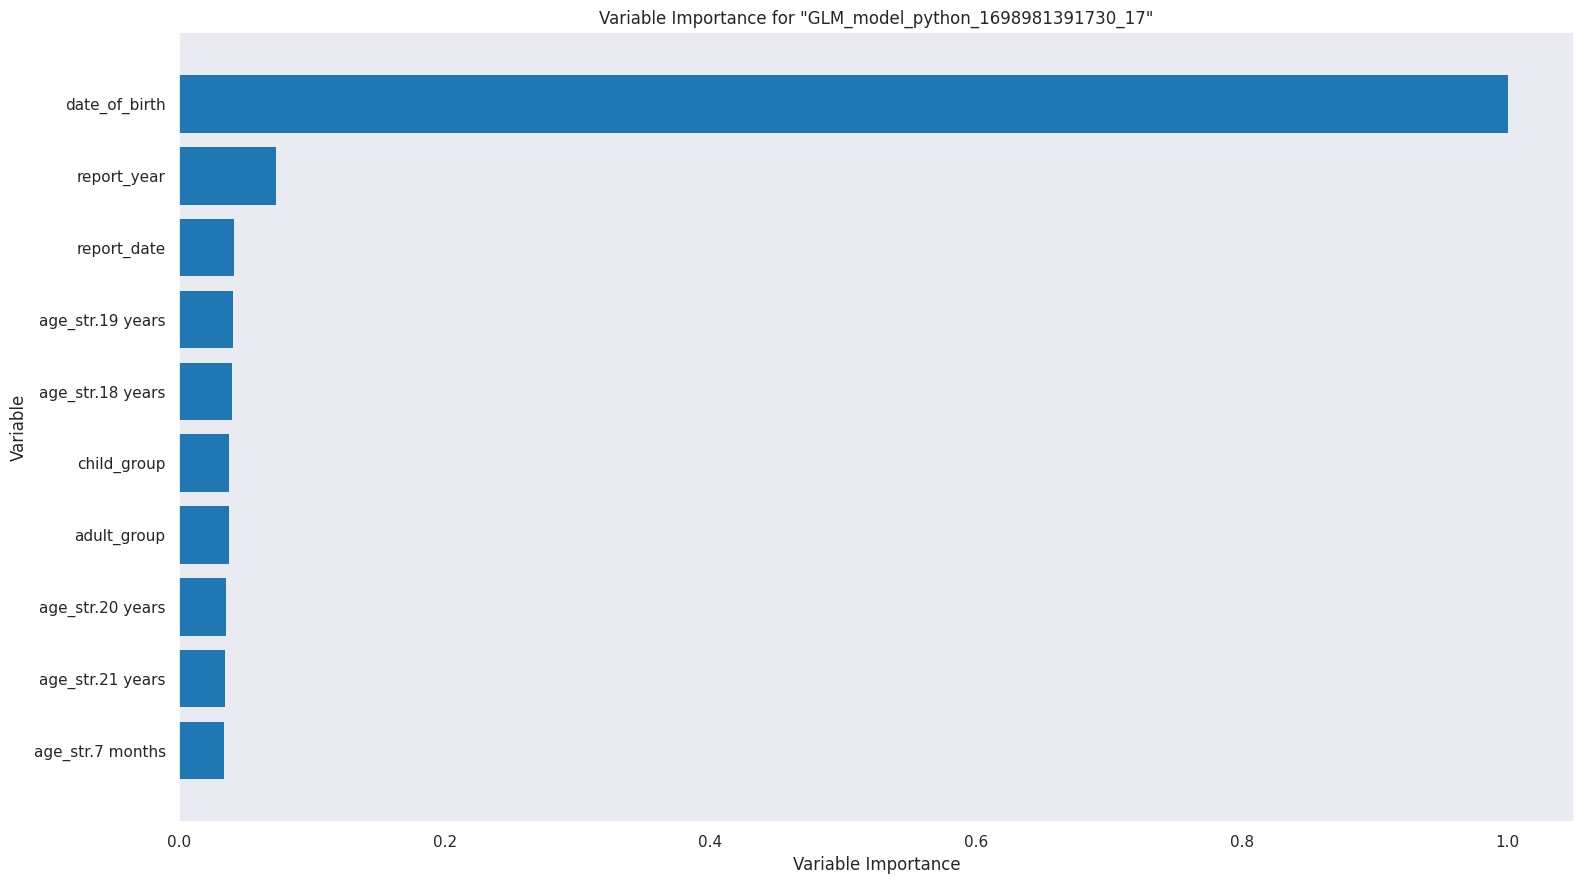

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

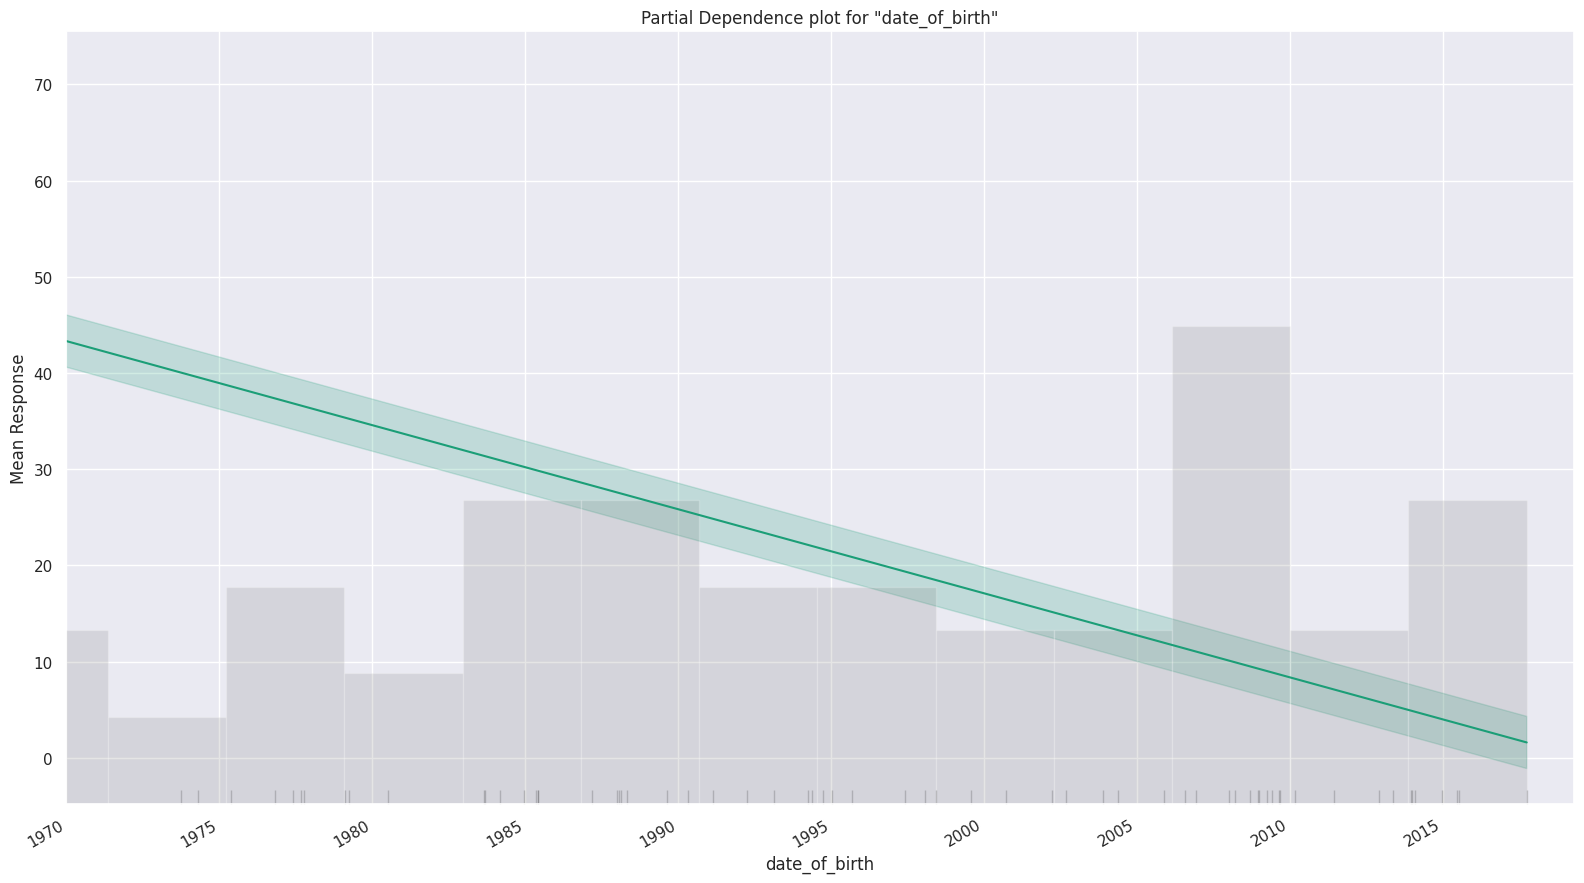

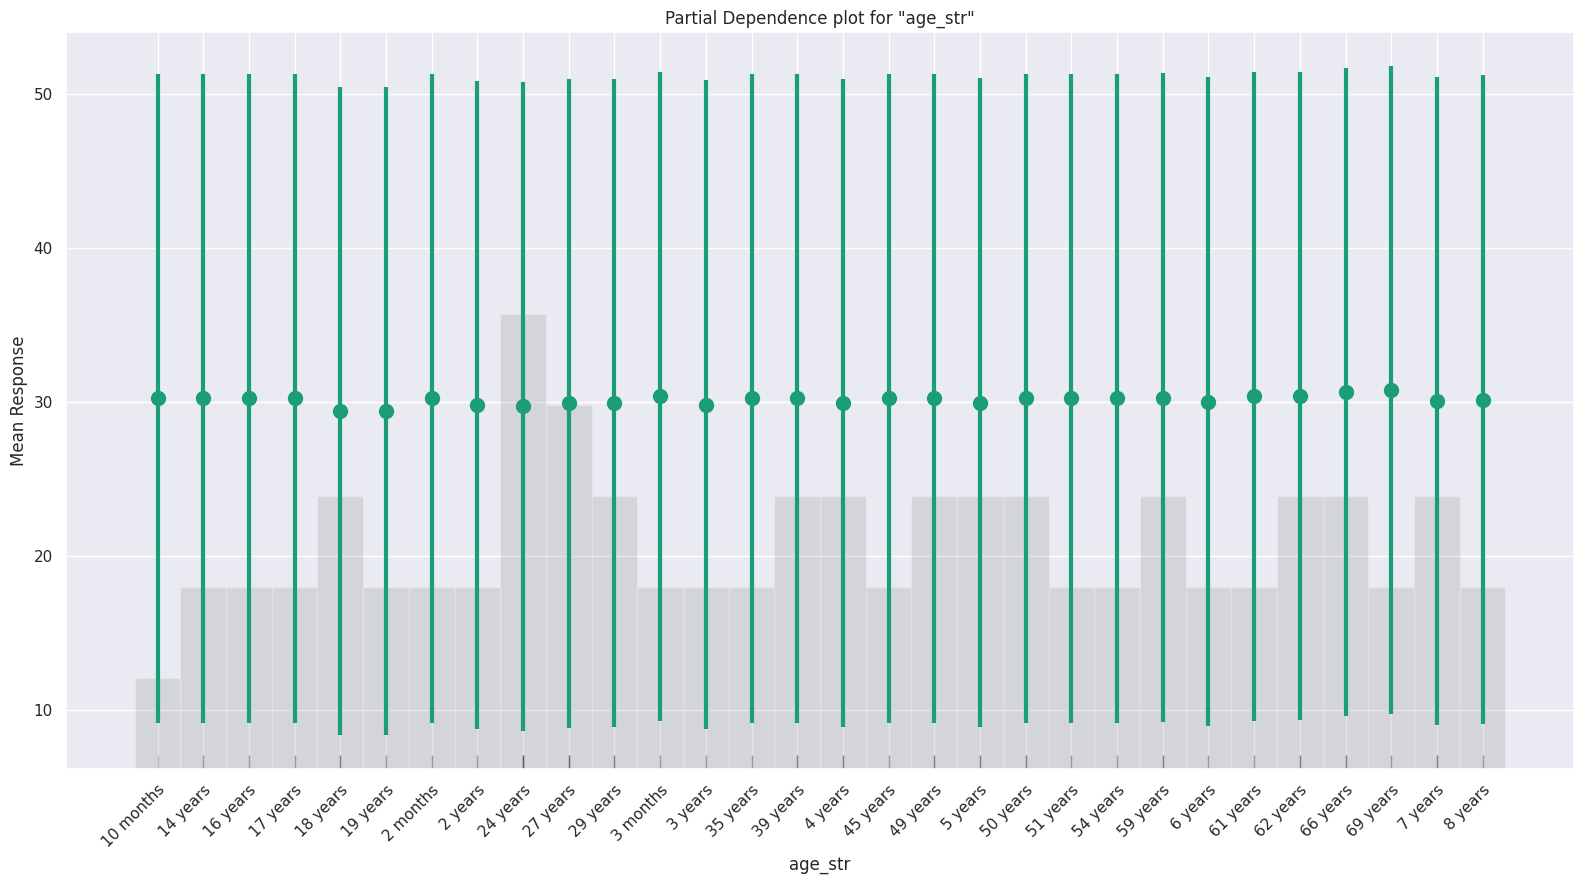

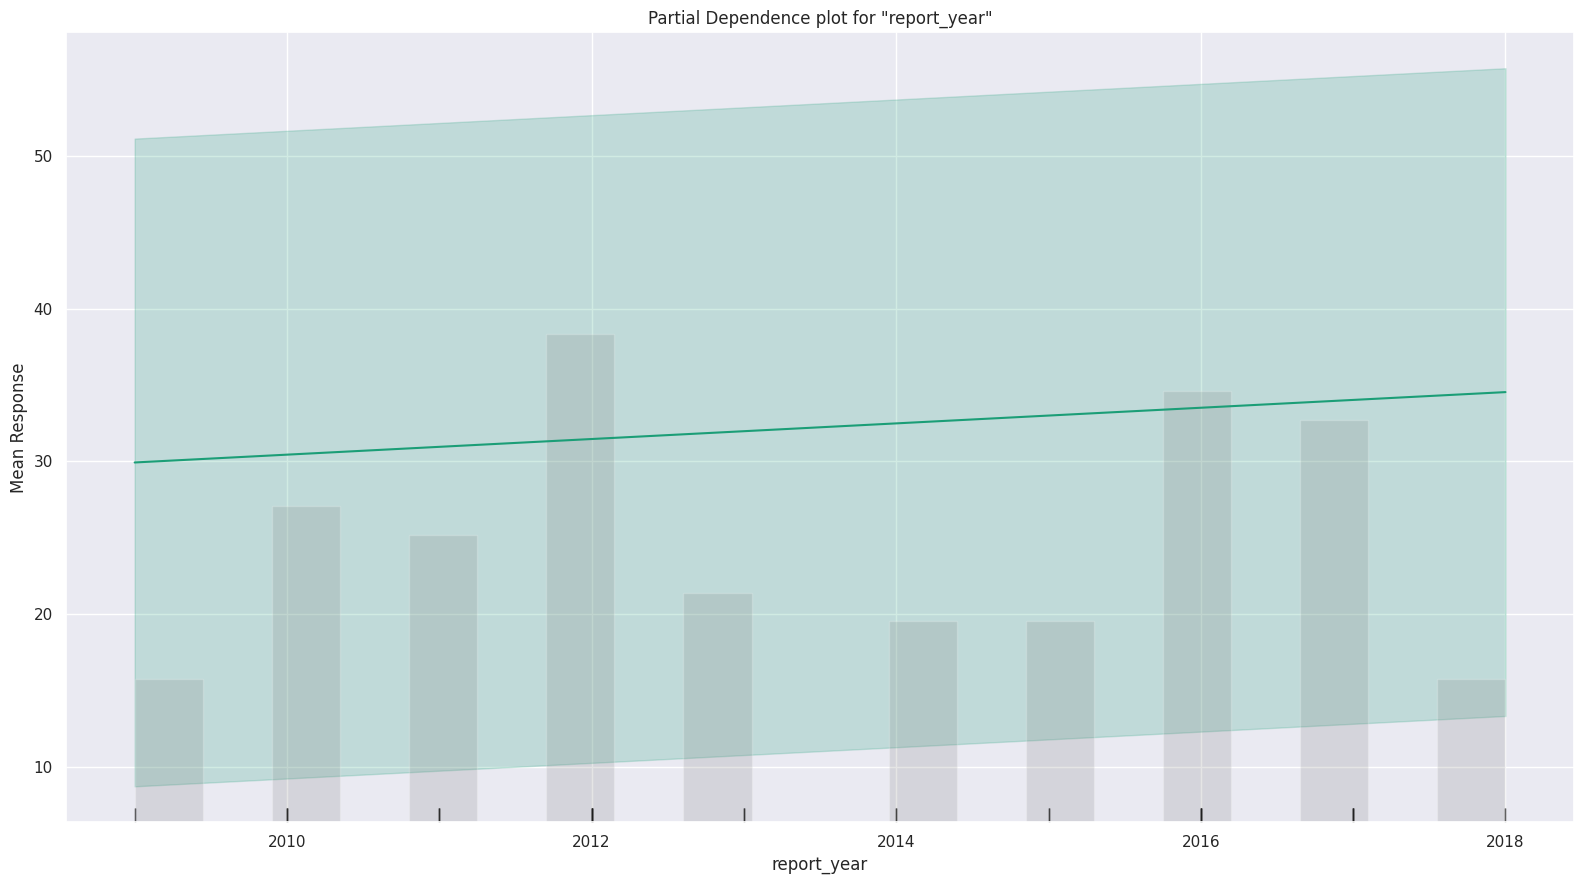

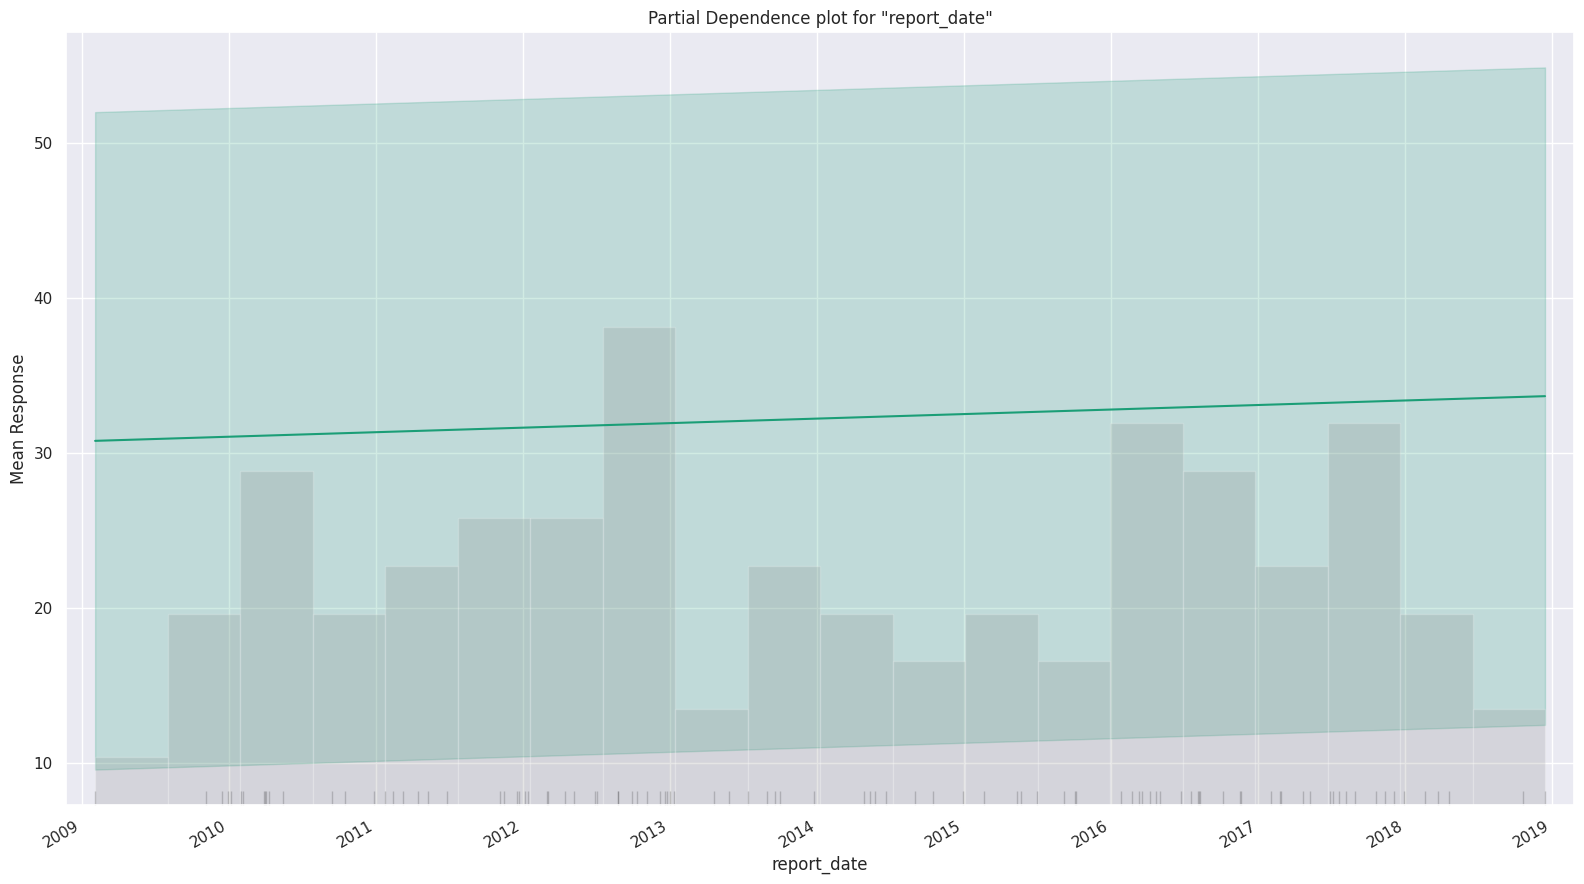

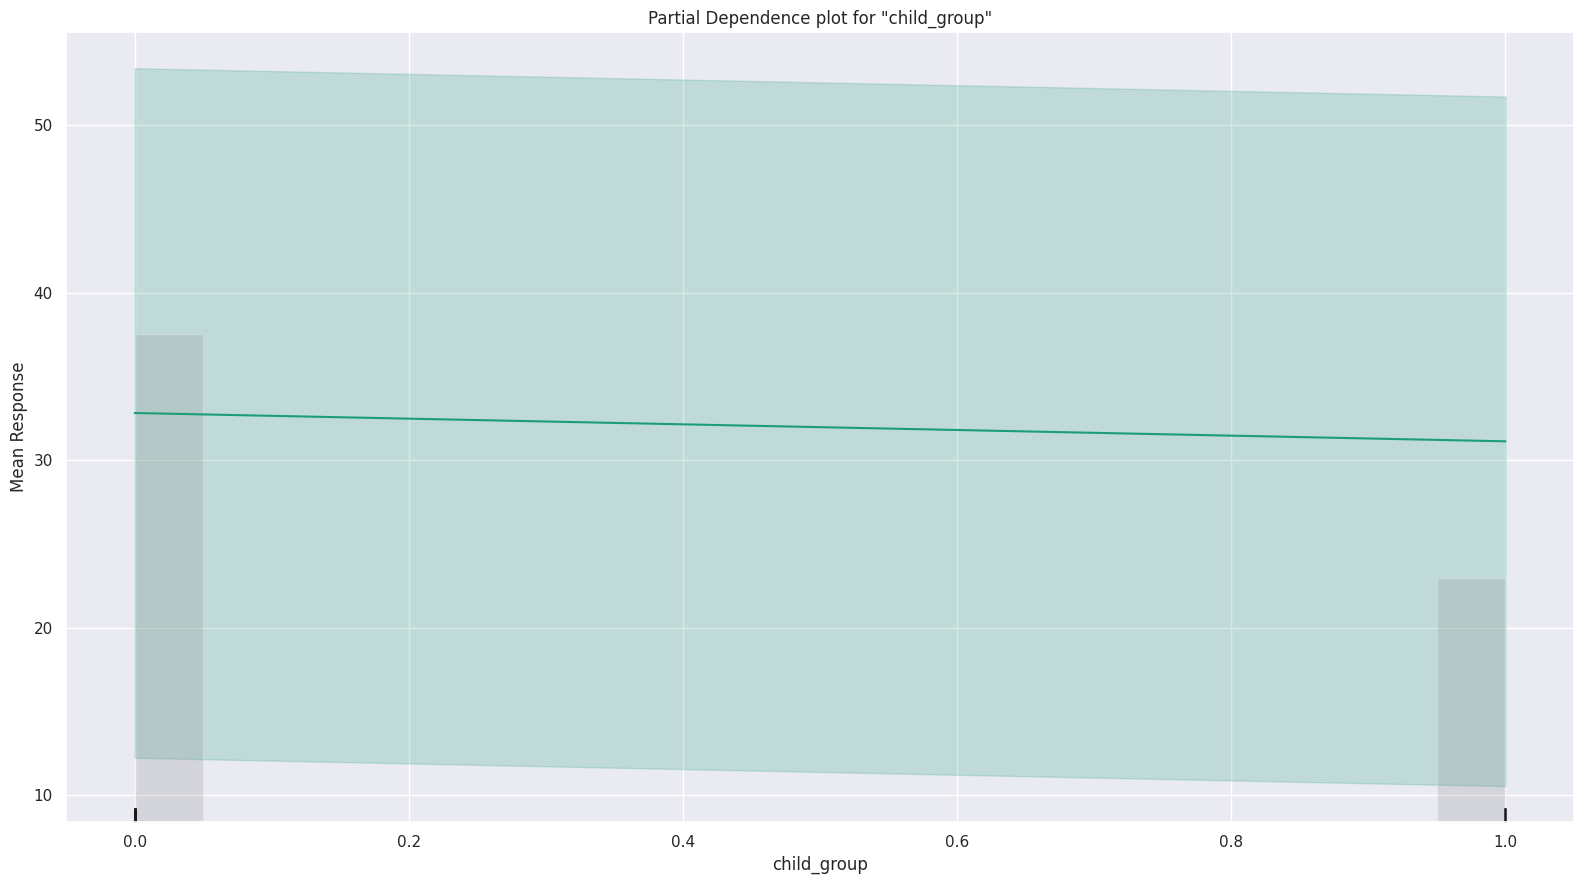

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

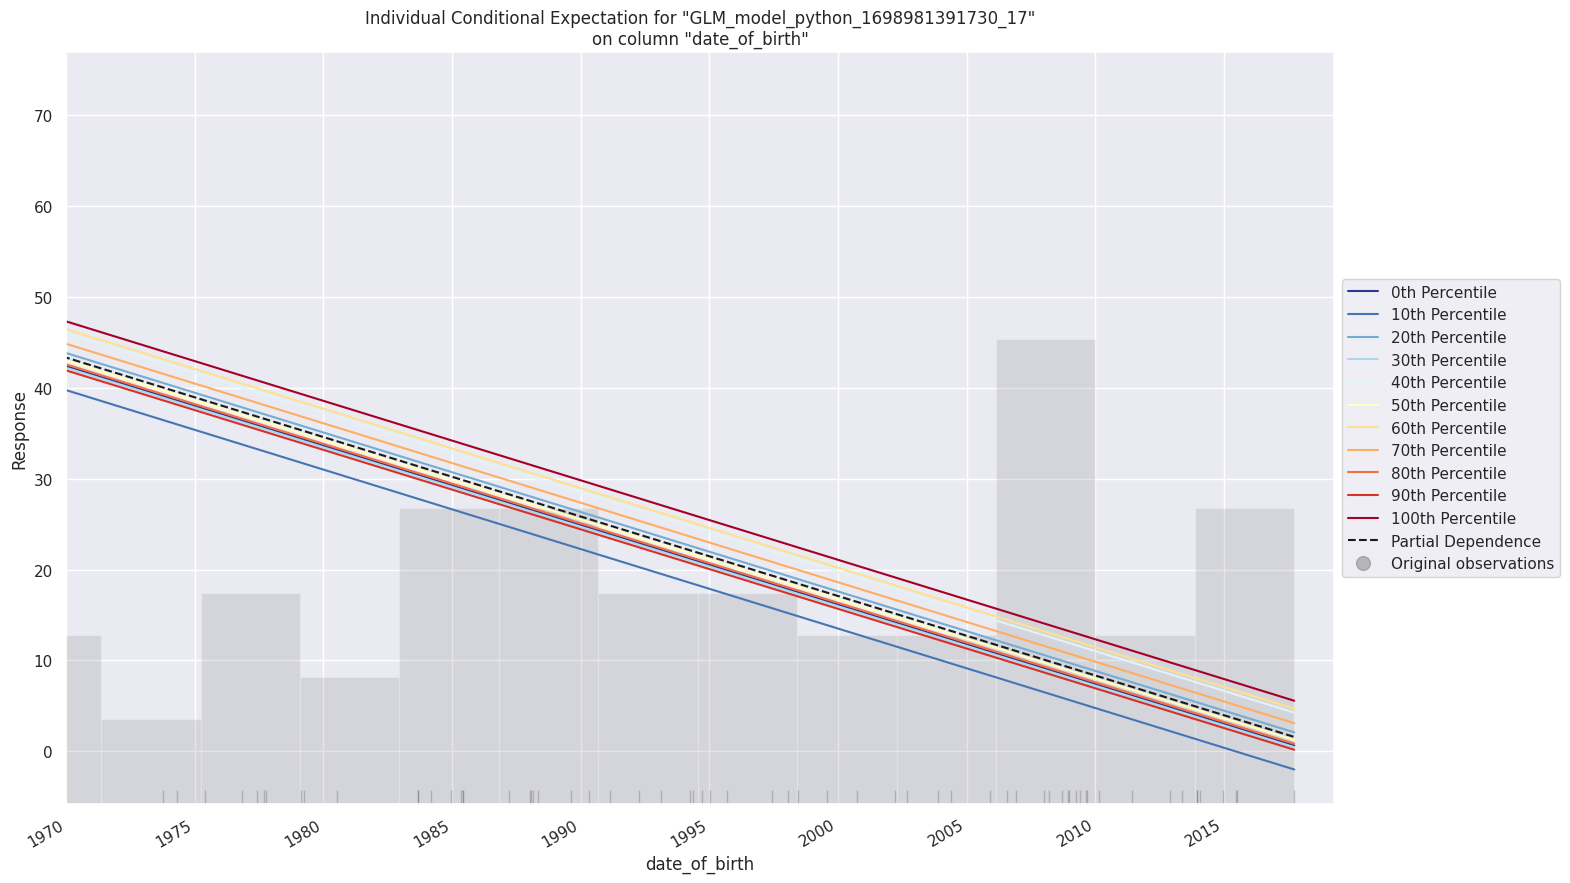

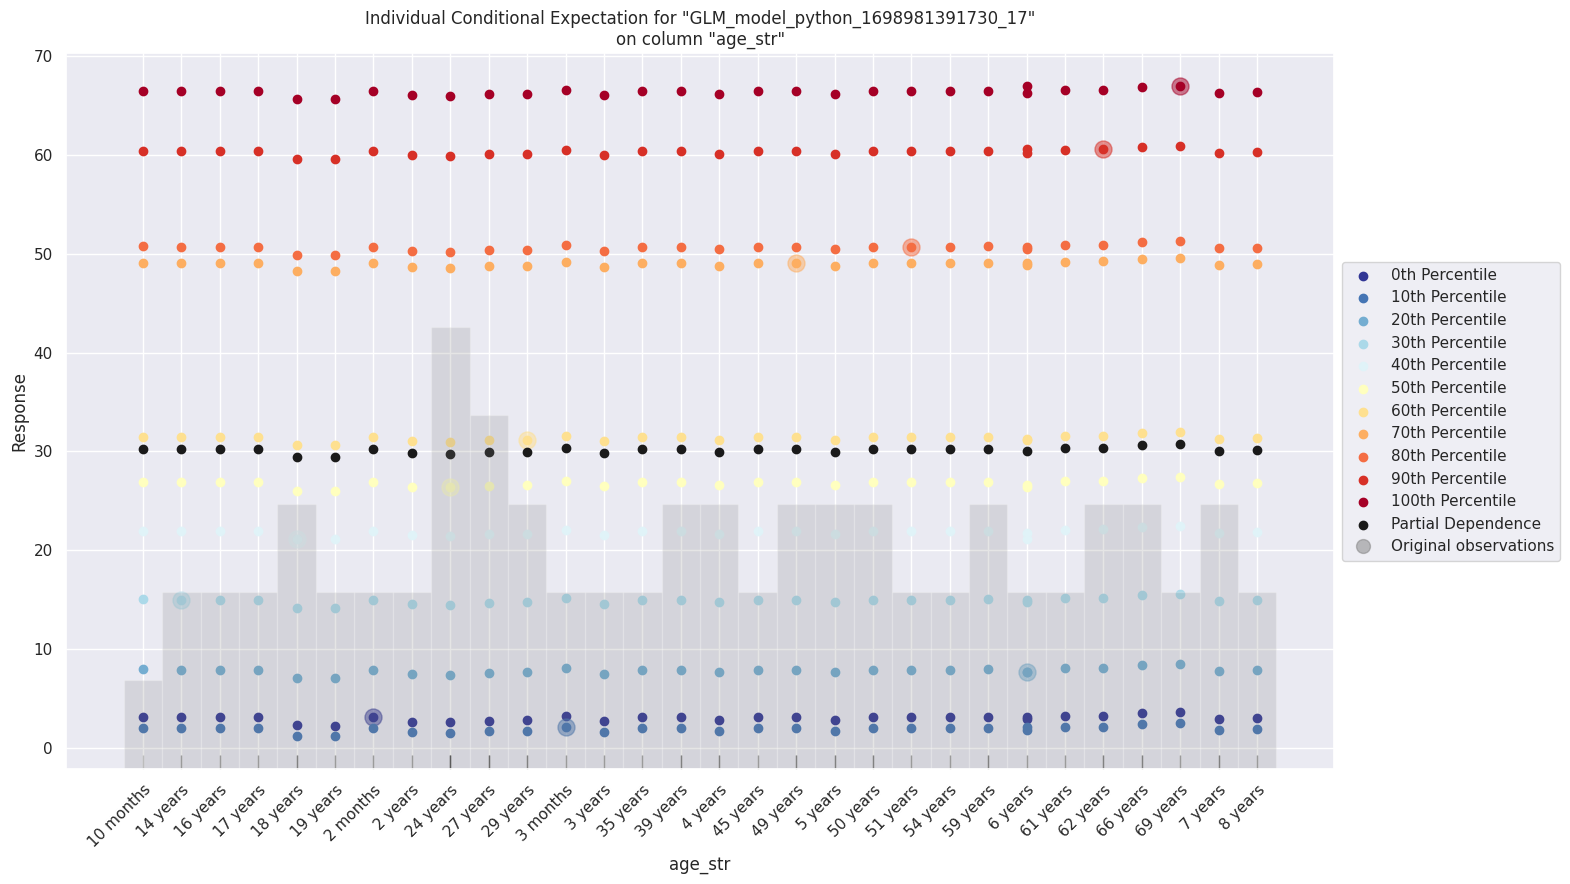

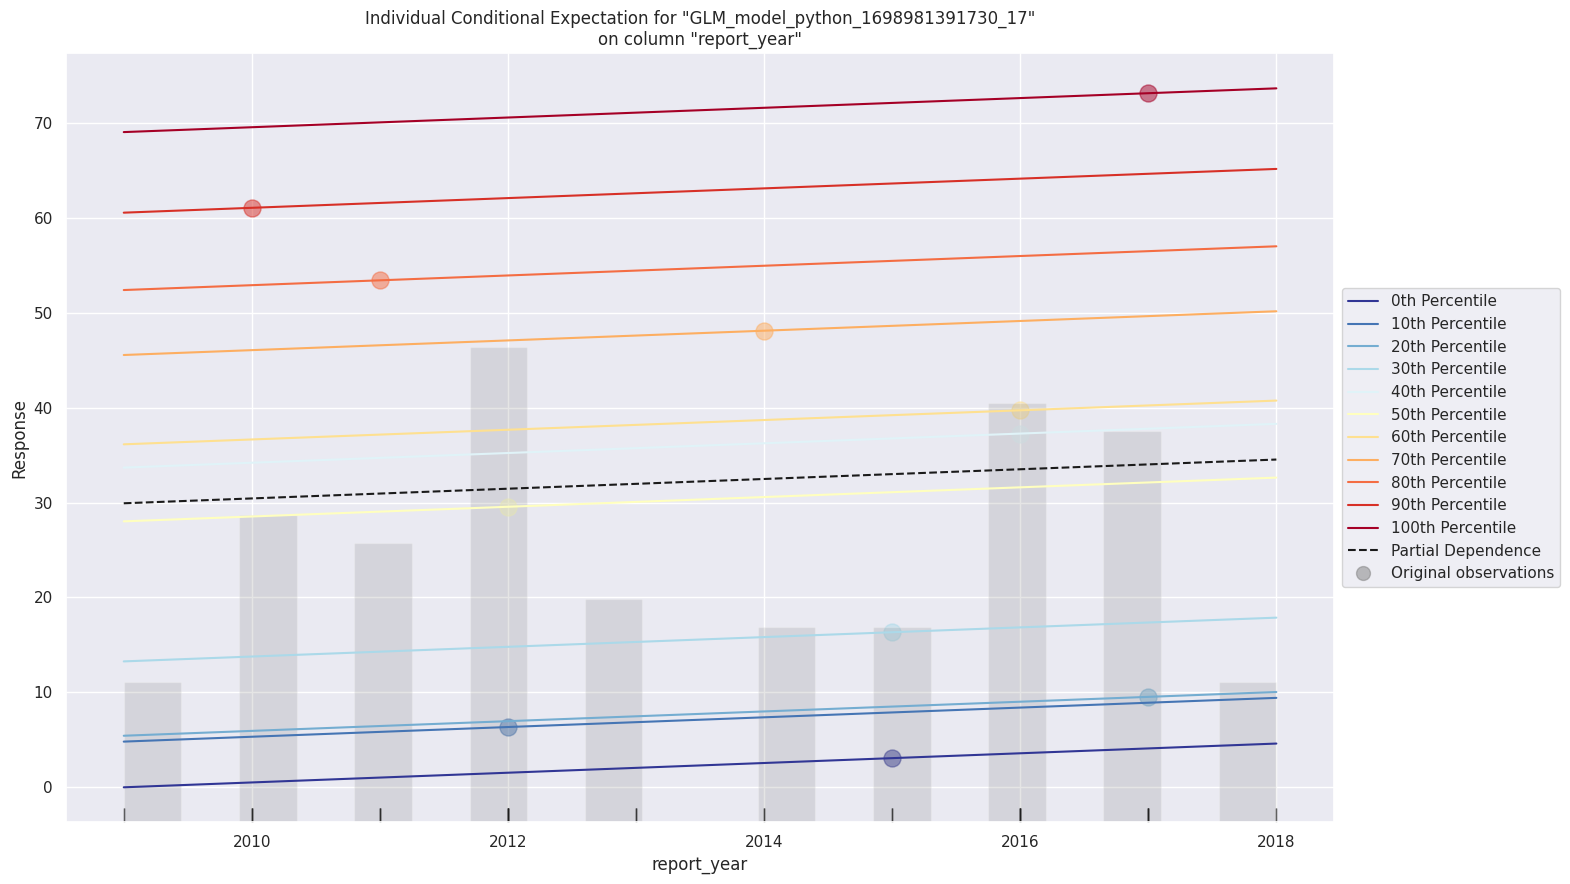

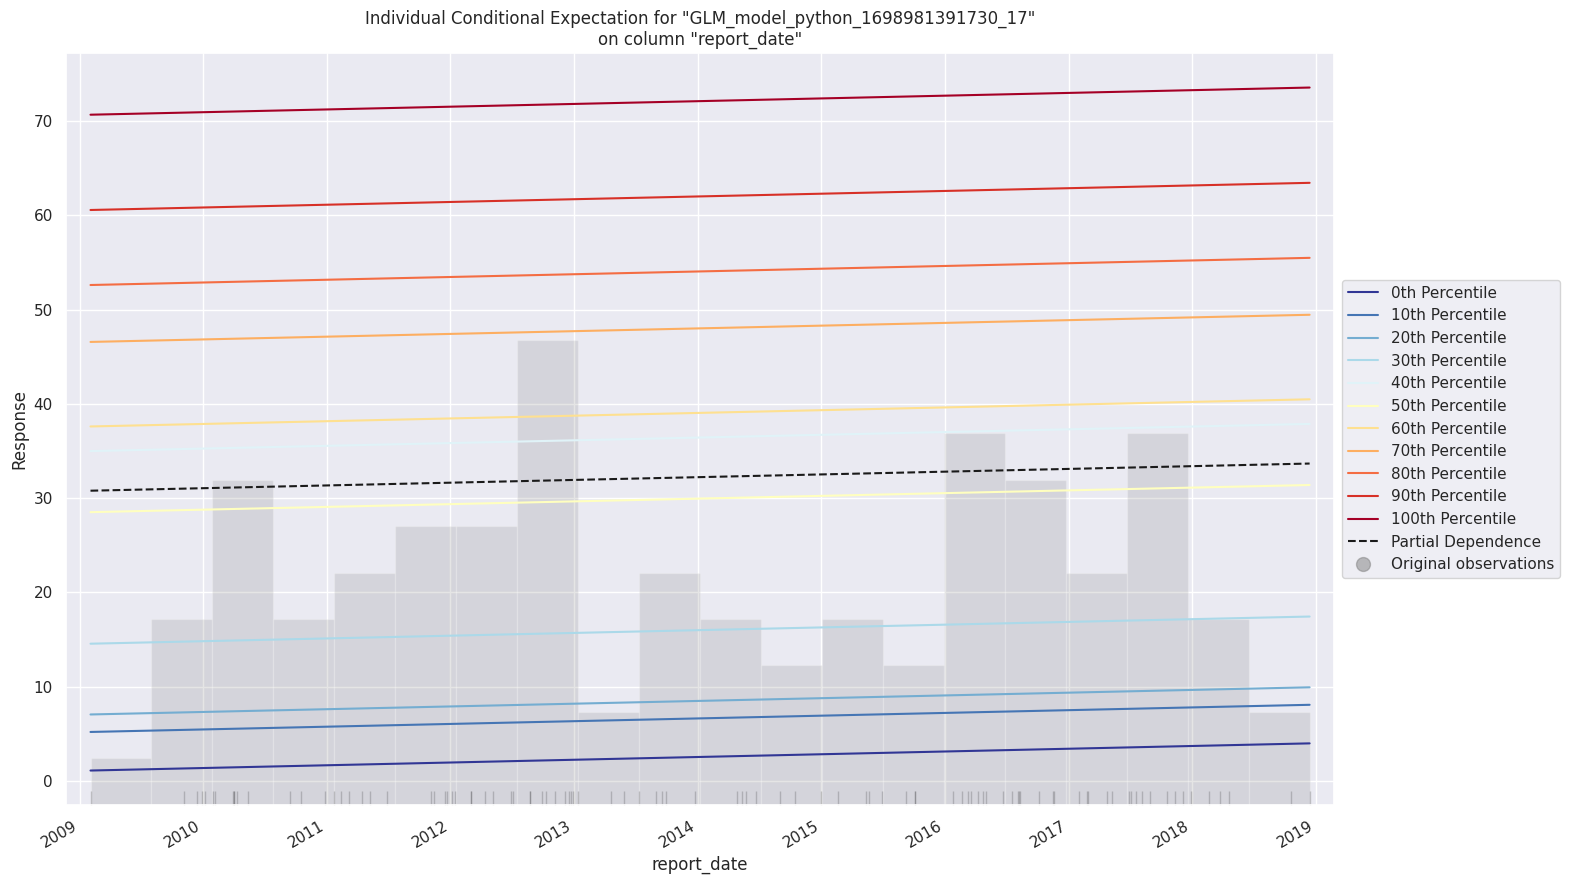

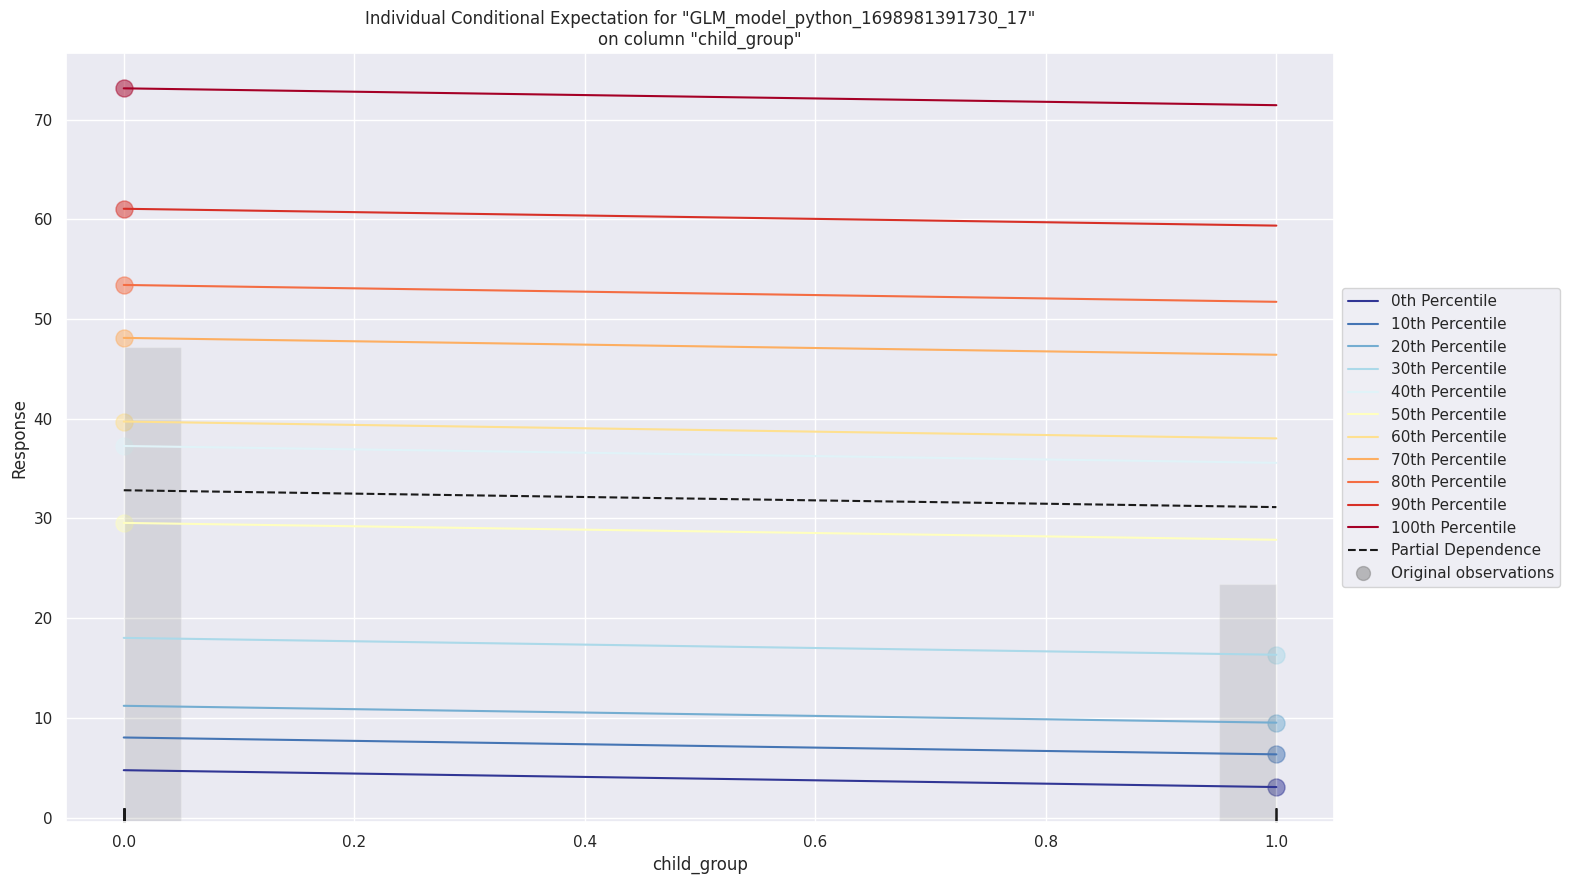

In [ ]:
data_glm.explain(df_train[1:100,:])

Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.


#Model Assumptions

We can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. Here no heteroscadasticity is observed in the residual plot, hence this assumption is not violated. If we look at the Correlation Heatmap closely - we can see that there is little to no collinearity among the variables. If we look closely at the Pair-Plot - we can notice that every independent variable has linear relationship with the target variable. Based on the distributions I described earlier, it is possible that some of the variables violate the assumption of normality.

# Questions answered:

# Is the relationship significant?

A relationship is said to be statistically significant when the p value for the variables is less than 0.05.P value is probability of obtaining a result at least as extreme as the current one, assuming null hypothesis is true. A small p value depicts that there is very little similarity between the two groups and hence null hypothesis can be ignored. P-value was calculated by two ways for this model. From the OLS method it was observed that values for ‘Address’ and ‘Date’ were greater than 0.05. So, it can be concluded that other that p-value for all the variables of dataset is less than 0.05. Hence for the chosen dataset it can be concluded that the relationship is significant.

# Are any model assumptions violated?

Model assumptions for classification are as follows: • It assumes that there is minimal or no multicollinearity among the independent variables. • It usually requires a large sample size to predict properly. • No model assumptions are violated because no multicollinearity is observed in the model, sample size is large.

# Is there any multicollinearity in the model?

When one independent variable is related to another independent variable that is its highly correlated then multicollinearity exists in the model. It’s an issue as it undermines the statistical significance of an independent variable. Multicollinearity can be determined by computing correlation matrix or calculating VIF value of all variables. In correlation matrix a coefficient closer to +1 or -1 tells us that those two variables are highly correlated. For VIF values a value above 10 tells us that multicollinearity exists. In this model -

It is evident from the heatmap that most of the features are non-collinear as most of the values are close to 0

The feature hours-per-week shows slight collinarity with age and educational_num

While training the model we have used the parameter remove_collinear_coumns and hence the model is trained without any collinear features

The assumption is followed while training the model

# In the multivariate models are predictor variables independent of all the other predictor variables?

As per the correlation matrix, all predictor variables are independent of all other predictor variables as the absolute value is less than 0.7 for all the predictor variables.

# Is there any multicollinearity in the model?

There is no sigificant multcollinarity in the model. We can verify this using the correlation matrix and the VIF scores for the data. Though some of the vif scores are high, there is nothing to worry about In the multivariate models are predictor variables independent of all the other predictor variables?

There is no strong evidence that the variables are dependent of each other. After observing the correlation matrix, it is concluded that no predictor variable is related to any other predictor variable because the absolute value of correlation coefficient is less than 0.7 for all the predictor variables. Hence, there is no multicollinearity observed in the model.

# Does the model make sense?

Yes our model makes sense. The logistic regression model has the highest recall while the XG Boost model has the highest accuracy. The model selection is based on what we want. We are aiming here for high recall and f1 though it may trade off the accuracy. Here, recall is more important than precision. Predicting false negative may be lethal rather than predicting false postive. Moreover, initially there was an imbalance in the data in predicting the stroke- 0's- 4500 1's-300 This high imbalance in data is not good for our training model and we saw that the model performed well on accuracy and precision but has poor F1 score and recall when predicting for a stroke. Therefore we resampled the data and saw a significant increase in the recall and f1 score.

# Does regularization help?

Regularization is a technique used for tuning the random noise function by adding an additional term to noise function. This additional term controls the excessively fluctuating function such that the coefficients don’t take extreme values and the prediction of target value for test data is not highly affected.Yes, regularization does help. With model regularization, the difference in error values for train and test data is relatively small, whereas the difference in error values for unregularized data is much larger. As a result, regularization aids in overcoming overfitting. All hyperparameters are important because they determined the way model works, however, there are some more important one, such as booster,max_depth, ntrees in XGBOOST and learn_rate in GBM. Regularization didn't really help us.

# Which independent variables are significant?

We can see from feature importance and visualizations that the disease, date and settlement are the most important parameters in predicting heart stroke. These variables are significant in predicting our target variable.

# Which hyperparameters are important?

We can get all the parameters of the model using model_name.params.keys(). The parameters of our GLM model are as follows :

Out of all the parameters the two most important parametrs in GLM models are lambda and alpha Lambda - It defines the regularization strength When performing regularization, penalties are introduced to the model buidling process to avoid overfitting, to reduce variance of the prediction error, and to handle correlated predictors Alpha - Specify the regularization distribution between L1 and L2

Observations -

1) As we can clearly see that the AUC score varies a lot when we change the values of Regularization strength lambda and alpha the regularization distribution

2) As we increase the Regularization strength to some higher positive value(i.e 10) the AUC drops significantly



#Conclusion:

In this assignment, I employed the H2O.ai AutoML library to develop predictive models for forecasting meningitis disease outbreaks in Nigeria. My focus was on identifying significant relationships within the data and building robust multivariate models for analysis. While assuming the data's quality for this phase, I recognized the need for subsequent data cleaning, feature engineering, and exploratory data analysis to enhance the models in future assignments.

Throughout the process, I examined key aspects such as the significance of relationships, adherence to model assumptions, the presence of multicollinearity, and the independence of predictor variables. Furthermore, I evaluated the influence of regularization and the significance of independent variables and hyperparameters in the models.

The primary goal was to establish an effective linear regression model for predicting disease outbreaks, with a focus on identifying the most influential factors driving the occurrence of meningitis. Moving forward, I aim to prioritize comprehensive data cleaning and feature engineering to ensure the models accurately reflect the underlying data patterns, providing reliable insights for disease prediction.


#License:

Copyright (c) 2024 Ronak Mishra

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



